# Pipeline for CNN with P300 data

## Environment
conda create -n P300_pipeline python=3.11 \
conda activate P300_pipeline

## Packages

pip install \
  "numpy<2" \
  "moabb<1.4" \
  "pyriemann<0.9" \
  braindecode \
  mne \
  scipy \
  pandas \
  scikit-learn\
  optuna


python -m pip install -U ipykernel\
python -m ipykernel install --user --name P300_pipeline --display-name "Python (P300_pipeline)"


## Dataset (one subject)

In [46]:
from braindecode.datasets import MOABBDataset

# all subjects (BNCI2014_009 has 10 subjects)
dataset_full = MOABBDataset(dataset_name="BNCI2014_009")

print("Number of recordings:", len(dataset_full.datasets))
print(dataset_full.description.head())
print(dataset_full.description.columns)


Number of recordings: 30
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
3        2       0   0
4        2       1   0
Index(['subject', 'session', 'run'], dtype='object')


In [47]:
from braindecode.datasets import MOABBDataset

subject_id = 1
dataset = MOABBDataset(dataset_name="BNCI2014_009", subject_ids=[subject_id])

### Inspect dataset

In [48]:
# see subjects and their sessions
import pandas as pd
pd.set_option("display.max_columns", None)

dataset_full.description.groupby("subject").size()

subject
1     3
2     3
3     3
4     3
5     3
6     3
7     3
8     3
9     3
10    3
dtype: int64

In [49]:
# One subject → one or more MNE Raw objects
raw = dataset.datasets[0].raw

print(raw)

# Channel names
print(raw.ch_names)

# Channel types (EEG, stim, etc.)
print(raw.get_channel_types())


<RawArray | 18 x 50184 (196.0 s), ~6.9 MiB, data loaded>
['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4', 'Target stim', 'Flash stim']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim', 'stim']


In [50]:
import mne
#  Number of channels
print("n_channels:", raw.info["nchan"])

# Sampling frequency
print("sfreq:", raw.info["sfreq"])

# Pick only EEG channels
eeg_picks = mne.pick_types(raw.info, eeg=True, stim=False)
print("EEG channel indices:", eeg_picks)
print("EEG channel names:", [raw.ch_names[i] for i in eeg_picks])


n_channels: 18
sfreq: 256.0
EEG channel indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
EEG channel names: ['Fz', 'Cz', 'Pz', 'Oz', 'P3', 'P4', 'PO7', 'PO8', 'F3', 'F4', 'FCz', 'C3', 'C4', 'CP3', 'CPz', 'CP4']


In [51]:
# Get EEG data as numpy array (shape: n_channels x n_samples))
data = raw.get_data(picks="eeg")

print("EEG data shape:", data.shape)


EEG data shape: (16, 50184)


In [52]:
# check events and labels 
events, event_id = mne.events_from_annotations(raw)

print("Event IDs:", event_id)
print("First 10 events:\n", events[:10])

Used Annotations descriptions: ['NonTarget', 'Target']
Event IDs: {'NonTarget': 1, 'Target': 2}
First 10 events:
 [[1544    0    1]
 [1608    0    1]
 [1672    0    2]
 [1736    0    1]
 [1800    0    1]
 [1864    0    1]
 [1928    0    1]
 [1992    0    1]
 [2056    0    2]
 [2120    0    1]]


Using matplotlib as 2D backend.


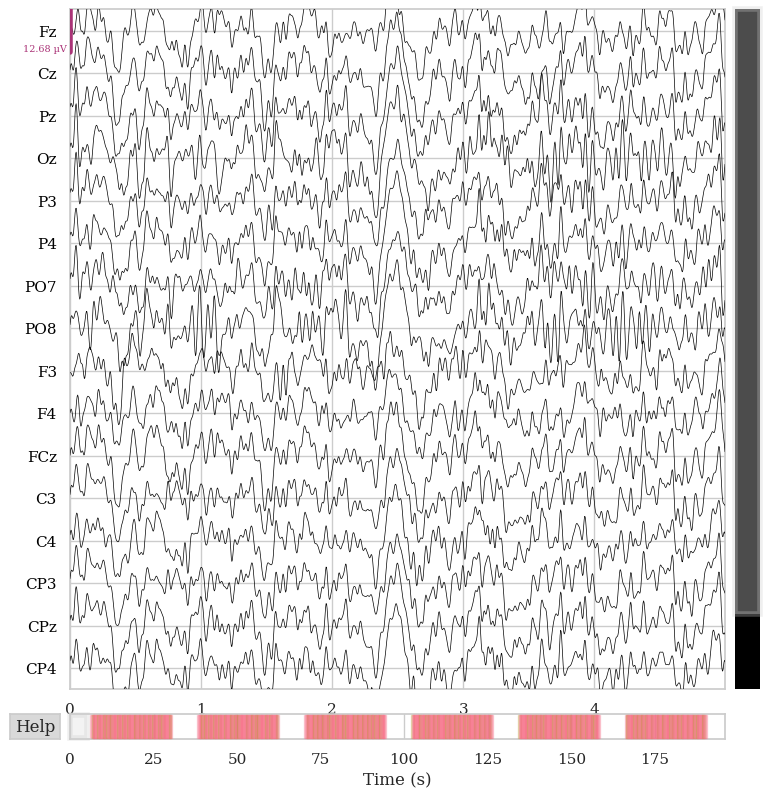

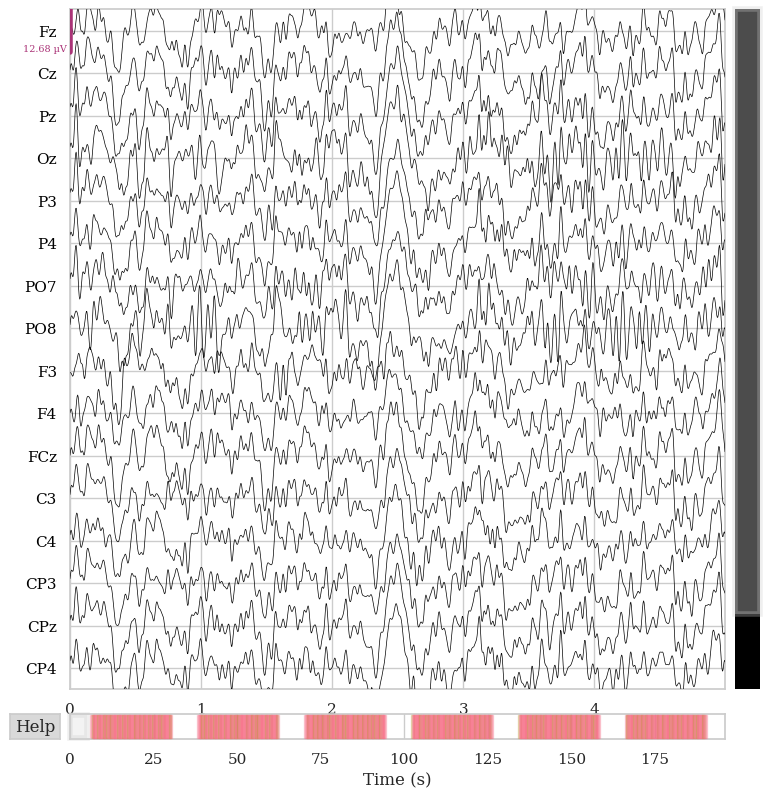

In [53]:
# Plot a few seconds of EEG
raw.plot(n_channels=16, duration=5, scalings="auto")


## Dataset (1 subject, 8 channels)

In [54]:
from braindecode.datasets import MOABBDataset

# all subjects (BNCI2014_009 has 10 subjects)
dataset_full = MOABBDataset(dataset_name="BNCI2014_009")

print("Number of recordings:", len(dataset_full.datasets))
print(dataset_full.description.head())
print(dataset_full.description.columns)

Number of recordings: 30
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
3        2       0   0
4        2       1   0
Index(['subject', 'session', 'run'], dtype='object')


In [55]:
subject_id = 1
dataset = MOABBDataset(dataset_name="BNCI2014_009", subject_ids=[subject_id])

In [56]:
unicorn_channels = [
    "Fz",
    "C3",
    "Cz",
    "C4",
    "Pz",
    "PO7",
    "Oz",
    "PO8",
]

for ds in dataset.datasets:
    ds.raw.pick_channels(unicorn_channels)

raw = dataset.datasets[0].raw

print("Channels after selection:", raw.ch_names)
print("Number of channels after selection:", len(raw.ch_names))




NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Channels after selection: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']
Number of channels after selection: 8


## Dataset (all subjects, 8 channels)

In [1]:
from braindecode.datasets import MOABBDataset

dataset = MOABBDataset(dataset_name="BNCI2014_009")  # all subjects by default
print("Number of recordings:", len(dataset.datasets))
print("Unique subjects:", sorted(dataset.description["subject"].unique()))

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of recordings: 30
Unique subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [2]:
unicorn_channels = ["Fz", "C3", "Cz", "C4", "Pz", "PO7", "Oz", "PO8"]

for ds in dataset.datasets:
    ds.raw.pick_channels(unicorn_channels)

raw0 = dataset.datasets[0].raw
print("Channels after picking:", raw0.ch_names)
print("n_channels:", len(raw0.ch_names))

# quick subject check
print("Subjects:", sorted(dataset.description["subject"].unique()))

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy functi

## Preprocessing

In [3]:
import numpy as np
from braindecode.preprocessing import (
    Preprocessor,
    preprocess,
)

# bandpass filter that matches dataset 
low_cut_hz = 0.1
high_cut_hz = 20.0
factor = 1e6 # to convert from V to uV
#resample_sfreq = 128  # set to none if you want to keep it at 256 Hz

def to_microvolts(data):
    return data * factor

preprocessors = [
    # keep only EEG channels
    Preprocessor("pick_types", eeg=True, meg=False, stim=False),
    # scale the data
    Preprocessor(to_microvolts),
    # bandpass filter for ERPs
    Preprocessor("filter", l_freq=low_cut_hz, h_freq=high_cut_hz),
]

# apply the preprocessors to the dataset
preprocess(dataset, preprocessors, n_jobs=-1)

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/preprocessing/preprocess.py:76: UserWarning: apply_on_array can only be True if fn is a callable function. Automatically correcting to apply_on_array=False.
  warn(


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 8449 samples (33.004 s)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband rip

## Creating trial windows

In [4]:
from braindecode.preprocessing import create_windows_from_events

# read sampling frequency from the data
sfreq = dataset.datasets[0].raw.info["sfreq"]
print("sampling frequency:", sfreq)

# trial window setting for P300
tmin = 0.0
tmax = 0.8 # P300 window 300ms to 800ms

start_offset = int(np.round(tmin * sfreq))
stop_offset = int(np.round(tmax * sfreq))

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=start_offset,
    trial_stop_offset_samples=stop_offset,
    preload=True,
)

print(windows_dataset)
print(windows_dataset.description.head())
print(windows_dataset.description.columns)


sampling frequency: 256.0
   subject session run
0        1       0   0
1        1       1   0
2        1       2   0
3        2       0   0
4        2       1   0
Index(['subject', 'session', 'run'], dtype='object')


In [5]:
# count number of target and non-target trials
y = np.array([windows_dataset[i][1] for i in range(len(windows_dataset))])

n_nontarget = np.sum(y == 0)
n_target = np.sum(y == 1)

print(f"NonTarget (0): {n_nontarget}")
print(f"Target (1): {n_target}")
print(f"Total windows: {len(y)}")



NonTarget (0): 14400
Target (1): 2880
Total windows: 17280


## Splitting the dataset into training and validation sets
- one subject

In [62]:
# check how many sessions 
print(windows_dataset.description["session"].unique())

['0' '1' '2']


In [63]:
from braindecode.datasets import BaseConcatDataset

# Split dataset into training and test based on sessions
splits = windows_dataset.split("session")
session_keys = sorted(list(splits.keys()), key=str)

print("Available sessions:", session_keys)

if len(session_keys) < 2:
    raise RuntimeError("Not enough sessions found for a cross-session split.")

train_keys = session_keys[:-1]
test_key = session_keys[-1]

# Collect datasets for training sessions
train_datasets = []
for k in train_keys:
    train_datasets.extend(splits[k].datasets)

# Build new BaseConcatDataset
train_set = BaseConcatDataset(train_datasets)

# Test set is just one split
test_set = splits[test_key]

print("Train windows:", len(train_set), "Test windows:", len(test_set))
print("Train sessions:", train_keys, "Test session:", test_key)


Available sessions: ['0', '1', '2']
Train windows: 11520 Test windows: 5760
Train sessions: ['0', '1'] Test session: 2


In [64]:
# count number of target and non-target trials in train and test sets
def get_labels_from_base_concat(dataset):
    labels = []
    for ds in dataset.datasets:
        labels.extend(ds.y)
    return np.array(labels)

y_train = get_labels_from_base_concat(train_set)
y_test = get_labels_from_base_concat(test_set)

print("Training set:")
print("  NonTarget:", np.sum(y_train == 0))
print("  Target:", np.sum(y_train == 1))

print("Test set:")
print("  NonTarget:", np.sum(y_test == 0))
print("  Target:", np.sum(y_test == 1))



Training set:
  NonTarget: 9600
  Target: 1920
Test set:
  NonTarget: 4800
  Target: 960


## Train and test splits
- full dataset

In [6]:
from braindecode.datasets import BaseConcatDataset

# choose the held-out participant
test_subject = 10

# split windows by subejct 
by_subject = windows_dataset.split("subject")
subject_keys = sorted(list(by_subject.keys()), key=int)
print("Available subjects:", subject_keys)

# build training set from all but the held-out subject
train_datasets = []
for s in subject_keys:
    if int(s) == int(test_subject):
        continue
    train_datasets.extend(by_subject[s].datasets)

train_set = BaseConcatDataset(train_datasets)
test_set = by_subject[str(test_subject)] if str(test_subject) in by_subject else by_subject[test_subject]

print("Train windows:", len(train_set), "Test windows:", len(test_set))
print("Train subjects:", [s for s in subject_keys if int(s) != int(test_subject)], "Test subject:", test_subject)


Available subjects: ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
Train windows: 15552 Test windows: 1728
Train subjects: ['1', '2', '3', '4', '5', '6', '7', '8', '9'] Test subject: 10


## Create groups for CV (session-based)
- One participant

In [66]:
# For Braindecode BaseConcatDataset, this gives per-window metadata (one row per window)
train_meta = train_set.get_metadata()

print("Metadata columns:", train_meta.columns.tolist())
print("Unique sessions in TRAIN:", train_meta["session"].unique())

# Groups must have length == number of windows
groups = train_meta["session"].to_numpy()

n_sessions = len(np.unique(groups))
print("Number of sessions in TRAIN:", n_sessions)

if n_sessions < 2:
    raise RuntimeError("Need at least 2 sessions in training set for session-based CV.")

Metadata columns: ['i_window_in_trial', 'i_start_in_trial', 'i_stop_in_trial', 'target', 'subject', 'session', 'run']
Unique sessions in TRAIN: ['0' '1' '2']
Number of sessions in TRAIN: 3


In [67]:
from sklearn.model_selection import GroupKFold
from skorch.callbacks import EpochScoring

# define cross validation splitter
# if you have 2 training sessions, this becomes 2-fold GroupKFold (each session is used once as validation)
cv = GroupKFold(n_splits=n_sessions)

# callbacks for logging
train_acc_cb = EpochScoring(scoring="accuracy", on_train=True, name="train_accuracy")
train_bacc_cb = EpochScoring(scoring="balanced_accuracy", on_train=True, name="train_bacc")

## CV split 
- all participants

In [7]:
from sklearn.model_selection import LeaveOneGroupOut

train_meta = train_set.get_metadata()
groups = train_meta["subject"].to_numpy()

cv = LeaveOneGroupOut()

print("groups_train:", groups.shape, "unique:", np.unique(groups))

groups_train: (15552,) unique: [1 2 3 4 5 6 7 8 9]


# ShallowFBCSPNet

## Model from Schirrmeister et al., 2017

Adapted from https://braindecode.org/stable/auto_examples/model_building/plot_bcic_iv_2a_moabb_trial.html

## Build the model

In [69]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available() # check if GPU is available and if true chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
# set random seed to be able to roughly reproduce results
# note that with cudnn benchmark set to true, GPU indeterminism
# may still make results substantially different between runs
# to obtain more consistent results at the cost of increased computation time,
# you can set the cudnn_benchmark to False in 'set_random_seed'
# or remove 'torch.backends.cudnn.benchmark = True' 
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

# for P300, infer number of classes from labels in train set
y_train = train_set.y if hasattr(train_set, "y") else np.array([train_set[i][1] for i in range(len(train_set))])
classes = np.unique(y_train)
n_classes = len(classes)

# Same as tutorial: infer input dims from one batch element
n_chans = train_set[0][0].shape[0]
n_times = train_set[0][0].shape[1]

print("Detected classes:", classes, "n_classes:", n_classes)
print("n_chans:", n_chans, "n_times:", n_times)

model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    n_times = n_times,
    final_conv_length="auto", # braindecode runs a dummy forward pass to infer the final layer size
)

model.to(device) # send the model to GPU if available or CPU
print(model)

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


Detected classes: [0 1] n_classes: 2
n_chans: 8 n_times: 409
Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)             [1, 8, 409]               [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1                  [1, 8, 409]               [1, 8, 409, 1]            --                        --
├─Rearrange (dimshuffle): 1-2                 [1, 8, 409, 1]            [1, 1, 409, 8]            --                        --
├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 8]            [1, 40, 385, 1]           13,840                    --
├─BatchNorm2d (bnorm): 1-4                    [1, 40, 385, 1]           [1, 40, 385, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5           [1, 40, 385, 1]           [1, 40, 385, 1]           --                        --
├─AvgPool2d (pool): 1-6                 

## Model training (With CV and HPO)

### HPO with CV
This picks the best paramters according to a primary metric

In [70]:
from torch.utils.data import Subset

from skorch.callbacks import EpochScoring, EarlyStopping
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skorch.helper import predefined_split

from braindecode import EEGClassifier

def build_shallow_clf(
    n_chans,
    n_times,
    n_classes,
    device,
    lr,
    batch_size,
    weight_decay,
    drop_prob,
    n_filters_time,
    filter_time_length,
    max_epochs,
    n_filters_spat,
    pool_time_length,
    pool_time_stride,
    valid_ds=None,
    patience=10,
    monitor="valid_loss",
):
    
    # Accuracy (train)
    train_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=True,
        name="train_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (train)
    train_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=True,
        name="train_balanced_accuracy",
        lower_is_better=False,
    )

    # Accuracy (valid)
    valid_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=False,
        name="valid_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (valid)
    valid_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=False,
        name="valid_balanced_accuracy",
        lower_is_better=False,
    )
    
    # Build a fresh ShallowFBCSPNet + EEGClassifier for one hyperparameter configuration.
    # Always build a new model per fold/trial to avoid state leakage.

    model = ShallowFBCSPNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        drop_prob=drop_prob,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
    ).to(device)

    callbacks = [
        ("train_bacc", train_bacc_cb),
        ("valid_bacc", valid_bacc_cb),
    ]

    train_split = None

    if valid_ds is not None:
        train_split = predefined_split(valid_ds)
        callbacks.append(
            ("early_stopping", EarlyStopping(
                monitor=monitor,
                patience=patience,
                lower_is_better=True,
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True,
            ))
        )

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        train_split=(predefined_split(valid_ds) if valid_ds is not None else None),  # we do external CV, so no internal split
        classes=list(range(n_classes)),
        callbacks=callbacks,
    )
    return clf

In [71]:
import numpy as np
import optuna
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, average_precision_score, accuracy_score

MAX_EPOCHS = 80
# Choose what Optuna should optimize
primary_metric = "bacc"  # options: "bacc", "acc", "auc", "ap"

def objective(trial: optuna.Trial) -> float:
    print(f"Trial {trial.number} started")
    # Training hyperparameters
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    max_epochs = MAX_EPOCHS
    patience = trial.suggest_int("patience", 8, 15)
    drop_prob = trial.suggest_float("drop_prob", 0.05, 0.6)
    
    # ShallowFBCSPNet architecture hyperparameters
    n_filters_time = trial.suggest_categorical("n_filters_time", [16, 24, 32, 40, 48, 64])
    filter_time_length = trial.suggest_categorical("filter_time_length", [33, 49, 65, 97])
    n_filters_spat = trial.suggest_categorical("n_filters_spat", [16, 24, 32, 40, 48])
    pool_time_length = trial.suggest_categorical("pool_time_length", [25, 50, 75, 100])
    pool_time_stride = pool_time_length // 2  
    

    fold_scores = []

    # trial.set_user_attr("fold_metrics", [])  # uncomment if you want per-fold dicts

    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(np.zeros(len(train_set)), y_train, groups)):
        # Keep your seeding scheme consistent with your EEGNet objective
        set_random_seeds(seed=2025 + fold_idx, cuda=cuda)

        tr_ds_full = Subset(train_set, tr_idx)
        va_ds = Subset(train_set, va_idx)

        # Internal split for early stopping (within tr_ds_full)
        n_tr = len(tr_ds_full)  
        rng = np.random.RandomState(2025 + fold_idx)
        perm = rng.permutation(n_tr)
        n_valid_inner = max(1, int(0.2 * n_tr))

        inner_valid_idx = perm[:n_valid_inner]
        inner_train_idx = perm[n_valid_inner:]

        inner_train_ds = Subset(tr_ds_full, inner_train_idx)
        inner_valid_ds = Subset(tr_ds_full, inner_valid_idx)

        clf = build_shallow_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            drop_prob=drop_prob,
            n_filters_time=n_filters_time,
            filter_time_length=filter_time_length,
            max_epochs=max_epochs,
            n_filters_spat=n_filters_spat,
            pool_time_length=pool_time_length,
            pool_time_stride=pool_time_stride,
            valid_ds=inner_valid_ds,
            patience=patience,
            monitor="valid_loss",
        )

        clf.fit(inner_train_ds, y=None)

        y_va_true = y_train[va_idx]
        y_va_proba = clf.predict_proba(va_ds)
        y_va_pred = np.argmax(y_va_proba, axis=1)

        # Compute metrics
        acc = accuracy_score(y_va_true, y_va_pred)
        bacc = balanced_accuracy_score(y_va_true, y_va_pred)

        # Only meaningful for binary
        if len(np.unique(y_va_true)) == 2:
            auc = roc_auc_score(y_va_true, y_va_proba[:, 1])
            ap = average_precision_score(y_va_true, y_va_proba[:, 1])
        else:
            auc = np.nan
            ap = np.nan

        if primary_metric == "bacc":
            fold_value = bacc
        elif primary_metric == "acc":
            fold_value = acc
        elif primary_metric == "auc":
            fold_value = auc
        elif primary_metric == "ap":
            fold_value = ap
        else:
            raise ValueError(f"Unknown primary_metric: {primary_metric}")

        fold_scores.append(float(fold_value))

        # Report intermediate mean so Optuna can prune
        trial.report(float(np.nanmean(fold_scores)), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # Save fold stats for this completed trial
    bacc_arr = np.array(fold_scores, dtype=float)
    trial.set_user_attr("fold_bacc", bacc_arr.tolist())
    trial.set_user_attr("fold_bacc_mean", float(np.mean(bacc_arr)))
    trial.set_user_attr("fold_bacc_std", float(np.std(bacc_arr)))

    mean_score = float(np.nanmean(fold_scores))
    print(f"Trial {trial.number} finished | mean {primary_metric}: {mean_score:.4f}")

    return float(np.nanmean(fold_scores))

Run the HPO

In [ ]:
# starting small to verify everything runs
n_trials = 40

sampler = optuna.samplers.TPESampler(seed=2025)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=n_trials)

print("Best CV score (mean balanced accuracy):", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")


Trial 0 started


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_balanced_accuracy    train_loss    valid_acc    valid_balanced_accuracy    valid_loss     dur
-------  -------------------------  ------------  -----------  -------------------------  ------------  ------
      1                     0.5583        0.6328       0.8209                     0.5423        0.4519  2.7000
      2                     0.5613        0.5340       0.8354                     0.5462        0.4156  1.6440
      3                     0.5643        0.4887       0.8477                     0.5469        0.3995  1.5302
      4                     0.5615        0.4709       0.8524                     0.5441        0.3840  1.5219
      5                     0.5842        0.4369       0.8542                     0.5480        0.3721  1.6075
      6                     0.5879        0.4206       0.8593                     0.5762        0.3616  1.5125
      7                     0.5995        0.4043       0.8607                     0.5771        0.3508  1.3100
 

In [ ]:
# After the run: inspect the best trial's fold stats
best = study.best_trial
print("Best trial fold bacc:", best.user_attrs.get("fold_bacc"))
print("Best trial mean bacc:", best.user_attrs.get("fold_bacc_mean"))
print("Best trial std bacc:", best.user_attrs.get("fold_bacc_std"))

In [ ]:
# Build a dataframe of all trials (including fold stats)
import pandas as pd

rows = []
for t in study.trials:
    rows.append({
        "trial": t.number,
        "value": t.value,
        "mean_bacc": t.user_attrs.get("fold_bacc_mean"),
        "std_bacc": t.user_attrs.get("fold_bacc_std"),
        "fold_bacc": t.user_attrs.get("fold_bacc"),
        **t.params,
    })

df = pd.DataFrame(rows)
df_sorted = df.sort_values("mean_bacc", ascending=False)
print(df_sorted.head(10)[["trial", "mean_bacc", "std_bacc"]])

### CV for epochs

In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset

# helpers (best epoch + indices by subject)
def best_epoch_from_history(net):
    """Return 1-indexed epoch of best validation loss from skorch history."""
    hist = pd.DataFrame(net.history)

    if "valid_loss" not in hist.columns:
        raise ValueError(
            "No valid_loss in net.history. Make sure you pass valid_ds and use predefined_split(valid_ds)."
        )
    if hist["valid_loss"].isna().all():
        raise ValueError("valid_loss is all NaN. Validation may not be wired correctly.")

    return int(hist["valid_loss"].astype(float).idxmin() + 1)

def indices_for_subject(meta_df, subj_id):
    subj = meta_df["subject"].to_numpy()
    return np.where(subj == subj_id)[0]

def indices_not_subject(meta_df, subj_id):
    subj = meta_df["subject"].to_numpy()
    return np.where(subj != subj_id)[0]

In [ ]:
# get subjects + choose params for calibration
meta = train_set.get_metadata()
subjects_cv = np.unique(meta["subject"].to_numpy())

params = fallback_params_shallow  

MAX_EPOCHS_CAL = 80   # high cap; early stopping decides
BUFFER = 1.15         # 10–15% buffer for final refit

print("n_subjects:", len(subjects_cv))
print("subjects:", subjects_cv)

n_subjects: 9
subjects: [1 2 3 4 5 6 7 8 9]


In [ ]:
from sklearn.metrics import balanced_accuracy_score

# LOGO epoch calibration (each subject is validation once)
best_epochs = []
valid_baccs = []

for s in subjects_cv:
    tr_idx = indices_not_subject(meta, s)
    va_idx = indices_for_subject(meta, s)

    train_ds = Subset(train_set, tr_idx)
    valid_ds = Subset(train_set, va_idx)

    net = build_shallow_clf(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=params["lr"],
        batch_size=params["batch_size"],
        weight_decay=params["weight_decay"],
        drop_prob=params["drop_prob"],
        n_filters_time=params["n_filters_time"],
        filter_time_length=params["filter_time_length"],
        max_epochs=MAX_EPOCHS_CAL,
        n_filters_spat=params["n_filters_spat"],
        pool_time_length=params["pool_time_length"],
        pool_time_stride=params["pool_time_stride"],
        valid_ds=valid_ds,
        patience=params["patience"],
        monitor="valid_loss",
    )

    net.fit(train_ds, y=None)

    # best epoch based on valid_loss curve
    e_best = best_epoch_from_history(net)
    best_epochs.append(e_best)

    # evaluate on the held-out subject using the best-restored weights (load_best=True)
    y_true = np.array([valid_ds[i][1] for i in range(len(valid_ds))])
    y_pred = net.predict(valid_ds)  # class labels
    bacc = balanced_accuracy_score(y_true, y_pred)
    valid_baccs.append(bacc)

    print(
        f"val_subject={s} | best_epoch={e_best} | "
        f"valid_bacc={bacc:.3f} | ran_epochs={len(net.history)}"
    )

best_epochs = np.array(best_epochs, dtype=int)
valid_baccs = np.array(valid_baccs, dtype=float)

E_ref = int(np.median(best_epochs))
max_epochs_final = int(np.ceil(E_ref * BUFFER))

  epoch    train_balanced_accuracy    train_loss    valid_acc    valid_balanced_accuracy    valid_loss     dur
-------  -------------------------  ------------  -----------  -------------------------  ------------  ------
      1                     0.5525        0.6207       0.8356                     0.5250        0.4499  1.1489
      2                     0.6866        0.3640       0.8443                     0.5330        0.4916  1.1549
      3                     0.7279        0.3085       0.8501                     0.5628        0.3867  1.0986
      4                     0.7456        0.2920       0.8582                     0.6135        0.3665  1.1174
      5                     0.7598        0.2832       0.8478                     0.5601        0.4479  1.1727
      6                     0.7641        0.2790       0.8542                     0.5750        0.4178  1.1435
      7                     0.7703        0.2779       0.8582                     0.6010        0.3754  1.1584
 

In [ ]:
print("\nBest epochs per val subject:", best_epochs.tolist())
print("E_ref (median):", E_ref)
print("max_epochs_final (buffered):", max_epochs_final)
print("valid_bacc mean±std:", f"{valid_baccs.mean():.3f} ± {valid_baccs.std():.3f}")
print(valid_baccs)


Best epochs per val subject: [11, 8, 2, 20, 9, 12, 10, 19, 11]
E_ref (median): 11
max_epochs_final (buffered): 13
valid_bacc mean±std: 0.741 ± 0.068
[0.62743056 0.73055556 0.71944444 0.77673611 0.82083333 0.734375
 0.66701389 0.73402778 0.86145833]


### Final refit on full training set 

In [ ]:
fallback_params_shallow = {
    "lr": 0.002718940016156451,
    "batch_size": 128,
    "weight_decay": 0.00010871003877839412,
    "patience": 11,
    "drop_prob": 0.4920220213261243,
    "n_filters_time": 40,
    "filter_time_length": 65,
    "n_filters_spat": 32,
    "pool_time_length": 25,
    "pool_time_stride": 25 // 2,
}

In [ ]:
MAX_EPOCHS = 13

try:
    p = study.best_params
    source = "study.best_params"
except NameError:
    p = fallback_params_shallow
    source = "fallback_params_shallow"

set_random_seeds(seed=2025, cuda=torch.cuda.is_available())

final_clf_shallow = build_shallow_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=p["lr"],
    batch_size=p["batch_size"],
    weight_decay=p["weight_decay"],
    drop_prob=p["drop_prob"],
    n_filters_time=p["n_filters_time"],
    filter_time_length=p["filter_time_length"],
    max_epochs=MAX_EPOCHS,
    n_filters_spat=p["n_filters_spat"],
    pool_time_length=p["pool_time_length"],
    pool_time_stride=p["pool_time_length"] // 2,
    valid_ds=None,       
)

final_clf_shallow.fit(train_set, y=None)

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_balanced_accuracy    train_loss     dur
-------  -------------------------  ------------  ------
      1                     0.5671        0.6110  1.1887
      2                     0.6805        0.3517  1.1741
      3                     0.7344        0.3089  1.1682
      4                     0.7519        0.2956  1.1154
      5                     0.7468        0.2970  1.1571
      6                     0.7557        0.2819  1.1695
      7                     0.7582        0.2857  1.1611
      8                     0.7708        0.2734  1.1608
      9                     0.7610        0.2767  1.1951
     10                     0.7735        0.2713  1.1599
     11                     0.7766        0.2710  1.1422
     12                     0.7743        0.2696  1.1181
     13                     0.7838        0.2641  1.1906
     14                     0.7775        0.2669  1.1577
     15                     0.7847        0.2633  1.1594
     16                     0.7

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_==================================================================================================================================================
  Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
  =================================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)             [1, 8, 409]               [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                  [1, 8, 409]               [1, 8, 409, 1]            --                        --
  ├─Rearrange (dimshuffle): 1-2                 [1, 8, 409, 1]            [1, 1, 409, 8]            --                        --
  ├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 8]            [1, 32, 345, 1]           12,880                    --
  ├─BatchNorm2d (bnorm): 1-4                    [1, 32, 345, 1]           [1, 32, 345, 1]           64                        --
  ├─Expression (conv_nonlin_exp): 1-5           [1, 32, 345, 1]           [1, 32, 345, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                       [1, 32, 345, 1]           [1, 32, 27, 1]            --                        [25, 1]
  ├─SafeLog (pool_nonlin_exp): 1-7              [1, 32, 27, 1]            [1, 32, 27, 1]            --                        --
  ├─Dropout (drop): 1-8                         [1, 32, 27, 1]            [1, 32, 27, 1]            --                        --
  ├─Sequential (final_layer): 1-9               [1, 32, 27, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1          [1, 32, 27, 1]            [1, 2, 1, 1]              1,730                     [27, 1]
  │    └─SqueezeFinalOutput (squeeze): 2-2      [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-1          [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =================================================================================================================================================
  Total params: 14,674
  Trainable params: 14,674
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  =================================================================================================================================================
  Input size (MB): 0.01
  Forward/backward pass size (MB): 0.09
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.11
  =================================================================================================================================================,
)

### Save model after fit

In [ ]:
import os

save_dir = "models_shallow"
os.makedirs(save_dir, exist_ok=True)

seed = 2025
run_id = "hpo_13Epochs"

path_shallow = os.path.join(
    save_dir,
    f"shallow_{run_id}_seed{seed}.pkl"
)

final_clf_shallow.save_params(f_params=path_shallow)

# use build_shallow_clf to build a new classifier instance
# then load the saved parameters
#clf.initialize()
#clf.load_params(f_params=path_shallow)

### Test

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, balanced_accuracy_score, accuracy_score
import numpy as np

meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

proba = final_clf_shallow.predict_proba(test_set)
y_pred = np.argmax(proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, proba[:, 1])
    ap = average_precision_score(y_true, proba[:, 1])
else:
    auc = np.nan
    ap = np.nan

print("Held-out test Acc:", round(float(acc), 3))
print("Held-out test BAcc:", round(float(bacc), 3))
print("Held-out test AUC:", round(float(auc), 3) if not np.isnan(auc) else "nan")
print("Held-out test AP:", round(float(ap), 3) if not np.isnan(ap) else "nan")


Held-out test Acc: 0.924
Held-out test BAcc: 0.868
Held-out test AUC: 0.948
Held-out test AP: 0.831


In [ ]:
p

{'lr': 0.002718940016156451,
 'batch_size': 128,
 'weight_decay': 0.00010871003877839412,
 'patience': 11,
 'drop_prob': 0.4920220213261243,
 'n_filters_time': 40,
 'filter_time_length': 65,
 'n_filters_spat': 32,
 'pool_time_length': 25,
 'pool_time_stride': 12}

### Results

20 trials
- {'lr': 0.0020290177394029388,
- 'batch_size': 128,
- 'weight_decay': 0.0009130273914206462,
- 'max_epochs': 14,
- 'n_filters_time': 60,
- 'filter_time_length': 35,
- 'drop_prob': 0.567686120090055}

30 trials (first time)
- {'lr': 0.0006697844425596637,
- 'batch_size': 64,
- 'weight_decay': 0.0003374623018539655,
- 'patience': 13,
- 'drop_prob': 0.2153401882629321,
- 'n_filters_time': 40,
- 'filter_time_length': 97,
- 'n_filters_spat': 32,
- 'pool_time_length': 50}
- pool_time_stride = pool_time_length / 2
- max epochs = 80


30 trials (second time)
- {'lr': 0.002718940016156451,
- 'batch_size': 128,
- 'weight_decay': 0.00010871003877839412,
- 'patience': 11,
- 'drop_prob': 0.4920220213261243,
-  'n_filters_time': 40,
- 'filter_time_length': 65,
- 'n_filters_spat': 32,
-  'pool_time_length': 25}
- pool_time_stride = pool_time_length / 2
- max_epochs=80



## Model training (without CV and HPO)

In [ ]:
import torch
from braindecode import EEGClassifier
from skorch.callbacks import EpochScoring

best = {
    "lr": 0.004918979421142806,
    "batch_size": 64,
    "weight_decay": 0.0006549074844111317,
    "max_epochs": 22,
    "n_filters_time": 60,
    "filter_time_length": 15,
    "drop_prob": 0.3743087320311387,
}

train_acc_cb = EpochScoring(scoring="accuracy", on_train=True, name="train_accuracy")
train_bacc_cb = EpochScoring(scoring="balanced_accuracy", on_train=True, name="train_bacc")

fast_model = ShallowFBCSPNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto",
    n_filters_time=best["n_filters_time"],
    filter_time_length=best["filter_time_length"],
    drop_prob=best["drop_prob"],
).to(device)

fast_clf = EEGClassifier(
    fast_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=best["lr"],
    batch_size=best["batch_size"],
    max_epochs=30,          # use more epochs than your quick test run
    device=device,
    train_split=None,       # pure training, no CV inside this run
    iterator_train__shuffle=True,
    classes=[0, 1],
    callbacks=[
        ("train_accuracy", train_acc_cb),
        ("train_bacc", train_bacc_cb),
    ],
)

fast_clf.fit(train_set, y=None)


  epoch    train_accuracy    train_bacc    train_loss     dur
-------  ----------------  ------------  ------------  ------
      1            0.8284        0.6293        0.4373  1.3562
      2            0.8597        0.6937        0.3464  0.9804
      3            0.8650        0.7115        0.3441  0.9783
      4            0.8647        0.7122        0.3417  0.9781
      5            0.8740        0.7321        0.3186  0.9709
      6            0.8774        0.7342        0.3090  0.9952
      7            0.8785        0.7410        0.3050  0.9993
      8            0.8814        0.7435        0.2966  0.9864
      9            0.8861        0.7547        0.2934  0.9801
     10            0.8859        0.7516        0.2843  0.9718
     11            0.8882        0.7564        0.2826  0.9769
     12            0.8864        0.7505        0.2836  0.9738
     13            0.8903        0.7573        0.2747  0.9785
     14            0.8904        0.7557        0.2780  0.9825
     15 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_==================================================================================================================================================
  Layer (type (var_name):depth-idx)             Input Shape               Output Shape              Param #                   Kernel Shape
  =================================================================================================================================================
  ShallowFBCSPNet (ShallowFBCSPNet)             [1, 8, 409]               [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                  [1, 8, 409]               [1, 8, 409, 1]            --                        --
  ├─Rearrange (dimshuffle): 1-2                 [1, 8, 409, 1]            [1, 1, 409, 8]            --                        --
  ├─CombinedConv (conv_time_spat): 1-3          [1, 1, 409, 8]            [1, 40, 395, 1]           20,160                    --
  ├─BatchNorm2d (bnorm): 1-4                    [1, 40, 395, 1]           [1, 40, 395, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 1-5           [1, 40, 395, 1]           [1, 40, 395, 1]           --                        --
  ├─AvgPool2d (pool): 1-6                       [1, 40, 395, 1]           [1, 40, 22, 1]            --                        [75, 1]
  ├─SafeLog (pool_nonlin_exp): 1-7              [1, 40, 22, 1]            [1, 40, 22, 1]            --                        --
  ├─Dropout (drop): 1-8                         [1, 40, 22, 1]            [1, 40, 22, 1]            --                        --
  ├─Sequential (final_layer): 1-9               [1, 40, 22, 1]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-1          [1, 40, 22, 1]            [1, 2, 1, 1]              1,762                     [22, 1]
  │    └─SqueezeFinalOutput (squeeze): 2-2      [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-1          [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =================================================================================================================================================
  Total params: 22,002
  Trainable params: 22,002
  Non-trainable params: 0
  Total mult-adds (Units.MEGABYTES): 0.00
  =================================================================================================================================================
  Input size (MB): 0.01
  Forward/backward pass size (MB): 0.13
  Params size (MB): 0.01
  Estimated Total Size (MB): 0.15
  =================================================================================================================================================,
)

### Test

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    precision_recall_curve,
)

# get true labels from metadata (robust label column)
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy().astype(int)

# predict proba and labels
y_proba = fast_clf.predict_proba(test_set)          # shape (N, 2)
y_pred = np.argmax(y_proba, axis=1)

# metrics
acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

# Only compute AUC/AP if both classes exist in y_true
has_both = (len(np.unique(y_true)) == 2)
auc = roc_auc_score(y_true, y_proba[:, 1]) if has_both else float("nan")
ap  = average_precision_score(y_true, y_proba[:, 1]) if has_both else float("nan")

print(f"Test accuracy:          {acc:.3f}")
print(f"Test balanced accuracy: {bacc:.3f}")
print(f"Test ROC AUC:           {auc:.3f}")
print(f"Test Avg Precision:     {ap:.3f}")



Test accuracy:          0.907
Test balanced accuracy: 0.810
Test ROC AUC:           0.933
Test Avg Precision:     0.799


## Plot Results (CV + HPO)

In [ ]:
# collect predictions and metrics

import numpy as np
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, accuracy_score

# probabilities and predictions
proba = final_clf_shallow.predict_proba(test_set)
y_pred = np.argmax(proba, axis=1)

# extract true labels robustly
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy()

# metrics
auc = roc_auc_score(y_true, proba[:, 1])
bacc = balanced_accuracy_score(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

print(f"AUC: {auc:.3f}")
print(f"Balanced Accuracy: {bacc:.3f}")
print(f"Accuracy: {acc:.3f}")


AUC: 0.941
Balanced Accuracy: 0.848
Accuracy: 0.902


TRAIN y_true counts: Counter({0: 12960, 1: 2592})
TRAIN y_pred counts: Counter({0: 13479, 1: 2073})


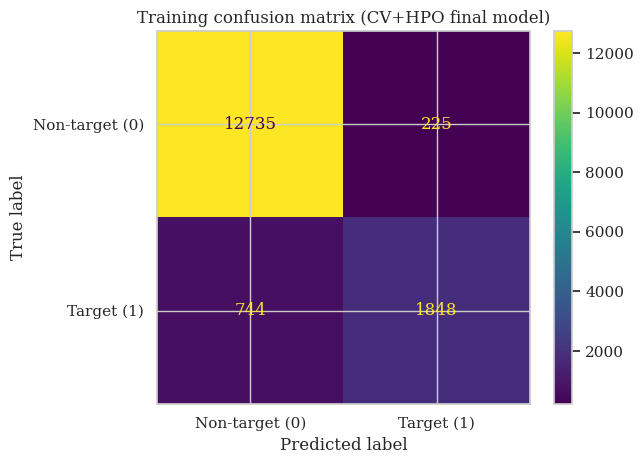

History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_balanced_accuracy', 'train_balanced_accuracy_best']


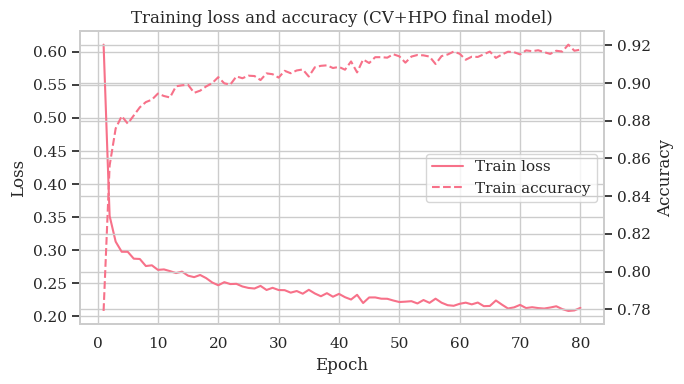

TEST y_true counts: Counter({0: 1440, 1: 288})
TEST y_pred counts: Counter({0: 1404, 1: 324})


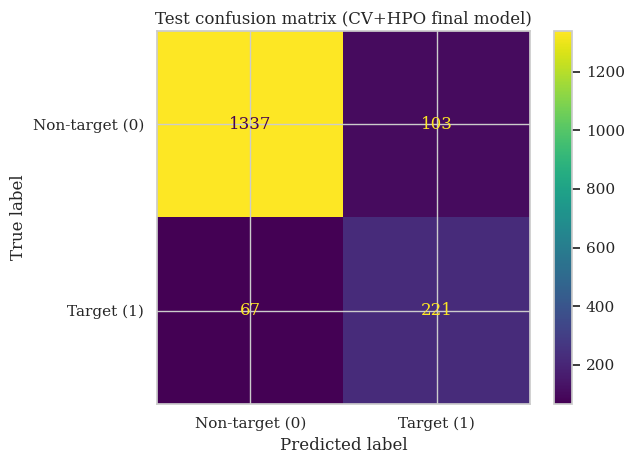

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# choose the model you want to plot for (CV+HPO final refit)
clf = final_clf_shallow

# label column (robust)
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"

# TRAIN confusion matrix
y_true_train = meta_train[label_col].to_numpy().astype(int)
y_proba_train = clf.predict_proba(train_set)
y_pred_train = np.argmax(y_proba_train, axis=1)

print("TRAIN y_true counts:", Counter(y_true_train))
print("TRAIN y_pred counts:", Counter(y_pred_train))

cm_train = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])
ConfusionMatrixDisplay(cm_train, display_labels=["Non-target (0)", "Target (1)"]).plot(values_format="d")
plt.title("Training confusion matrix (CV+HPO final model)")
plt.tight_layout()
plt.show()

# TRAIN loss + accuracy curves (together)

history = pd.DataFrame(clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# accuracy (right axis) if logged
if "train_accuracy" in history.columns:
    ax2 = ax1.twinx()
    ax2.plot(epochs, history["train_accuracy"], linestyle="--", label="Train accuracy")
    ax2.set_ylabel("Accuracy")

    # merged legend
    l1, lab1 = ax1.get_legend_handles_labels()
    l2, lab2 = ax2.get_legend_handles_labels()
    ax1.legend(l1 + l2, lab1 + lab2, loc="center right")
else:
    ax1.legend(loc="upper right")
    ax1.text(
        0.02, 0.02,
        "train_accuracy not logged (add EpochScoring callback)",
        transform=ax1.transAxes
    )

plt.title("Training loss and accuracy (CV+HPO final model)")
plt.tight_layout()
plt.show()

# 3) TEST confusion matrix
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true_test = meta_test[label_col_test].to_numpy().astype(int)

y_proba_test = clf.predict_proba(test_set)
y_pred_test = np.argmax(y_proba_test, axis=1)

print("TEST y_true counts:", Counter(y_true_test))
print("TEST y_pred counts:", Counter(y_pred_test))

cm_test = confusion_matrix(y_true_test, y_pred_test, labels=[0, 1])
ConfusionMatrixDisplay(cm_test, display_labels=["Non-target (0)", "Target (1)"]).plot(values_format="d")
plt.title("Test confusion matrix (CV+HPO final model)")
plt.tight_layout()
plt.show()


History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_balanced_accuracy', 'train_balanced_accuracy_best']


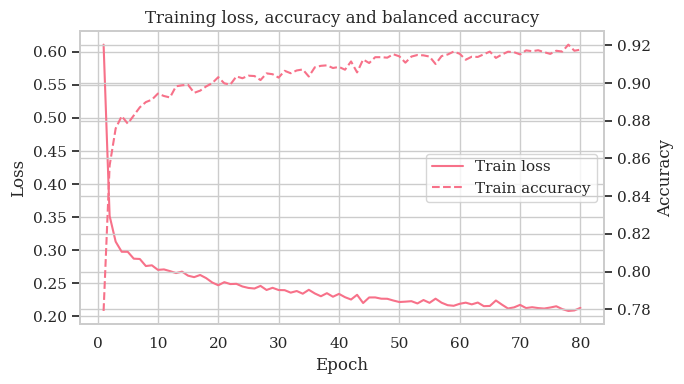

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# Loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Accuracy metrics (right axis)
ax2 = ax1.twinx()

if "train_accuracy" in history.columns:
    ax2.plot(
        epochs,
        history["train_accuracy"],
        linestyle="--",
        label="Train accuracy",
    )

if "train_bacc" in history.columns:
    ax2.plot(
        epochs,
        history["train_bacc"],
        linestyle=":",
        label="Train balanced accuracy",
    )

ax2.set_ylabel("Accuracy")

# Merge legends
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="center right")

plt.title("Training loss, accuracy and balanced accuracy")
plt.tight_layout()
plt.show()


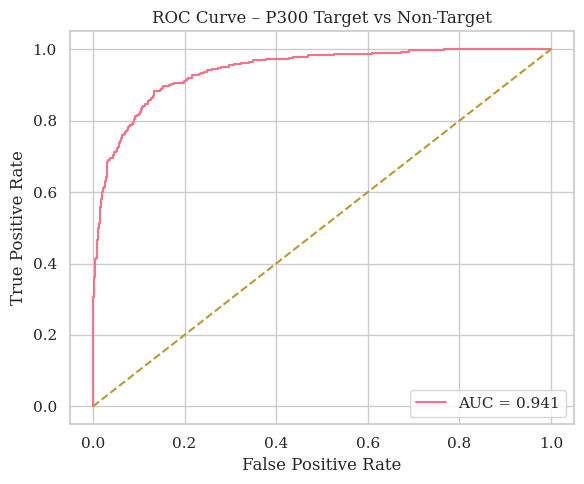

In [ ]:
#ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, proba[:, 1])

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – P300 Target vs Non-Target")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


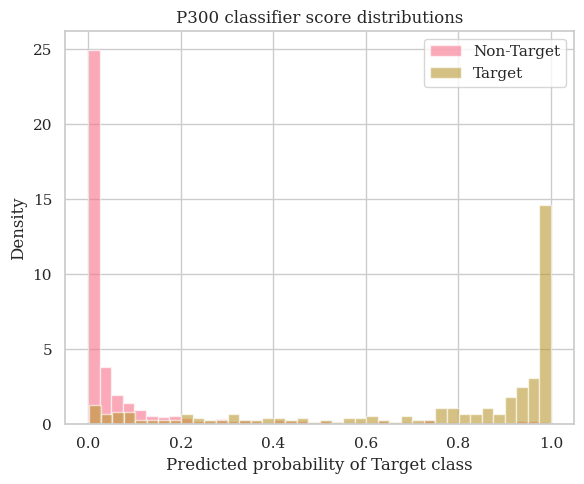

In [ ]:
# predicted probability distributions

plt.figure(figsize=(6, 5))

plt.hist(
    proba[y_true == 0, 1],
    bins=40,
    alpha=0.6,
    label="Non-Target",
    density=True,
)

plt.hist(
    proba[y_true == 1, 1],
    bins=40,
    alpha=0.6,
    label="Target",
    density=True,
)

plt.xlabel("Predicted probability of Target class")
plt.ylabel("Density")
plt.title("P300 classifier score distributions")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Plot Results (without CV and HPO)

TRAIN y_true counts: Counter({0: 960, 1: 192})
TRAIN y_pred counts: Counter({0: 960, 1: 192})


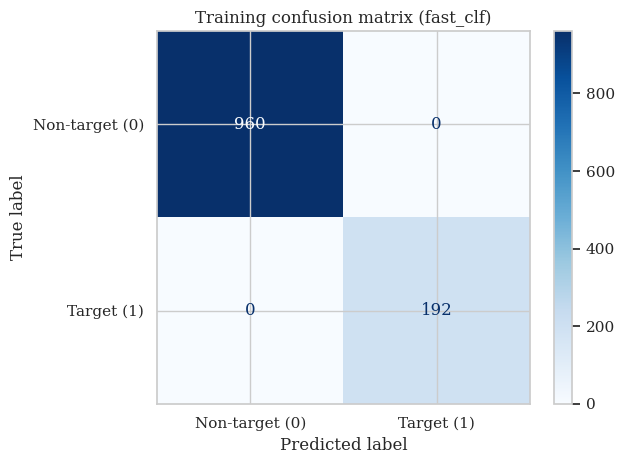

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# true labels from training metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_true_train = meta_train[label_col].to_numpy().astype(int)

# predictions on training set
y_proba_train = fast_clf.predict_proba(train_set)
y_pred_train = np.argmax(y_proba_train, axis=1)

# sanity checks (helps catch class collapse)
print("TRAIN y_true counts:", Counter(y_true_train))
print("TRAIN y_pred counts:", Counter(y_pred_train))

# confusion matrix (force 2x2)
cm_train = confusion_matrix(y_true_train, y_pred_train, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_train,
    display_labels=["Non-target (0)", "Target (1)"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Training confusion matrix (fast_clf)")
plt.tight_layout()
plt.show()


History columns: ['batches', 'epoch', 'train_batch_count', 'dur', 'train_loss', 'train_loss_best', 'train_accuracy', 'train_accuracy_best', 'train_bacc', 'train_bacc_best']


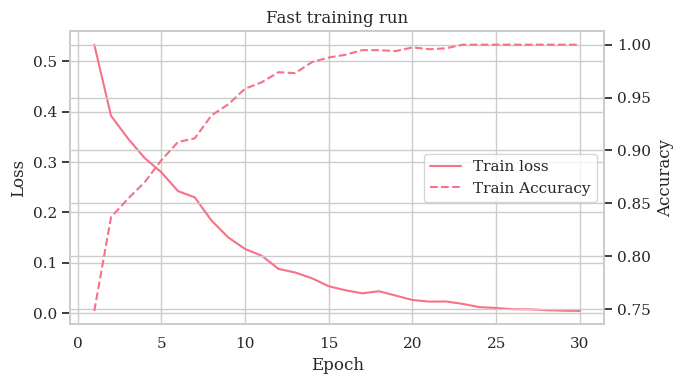

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_loss_and_accuracy(clf, title="Training curves"):
    hist = pd.DataFrame(clf.history)
    print("History columns:", list(hist.columns))

    epochs = hist["epoch"]

    fig, ax1 = plt.subplots(figsize=(7, 4))

    # Left axis: loss
    ax1.plot(epochs, hist["train_loss"], label="Train loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # Right axis: accuracy (only if logged)
    acc_cols = [c for c in ["train_accuracy", "valid_accuracy"] if c in hist.columns]
    if acc_cols:
        ax2 = ax1.twinx()
        for c in acc_cols:
            ax2.plot(epochs, hist[c], linestyle="--", label=c.replace("_", " ").title())
        ax2.set_ylabel("Accuracy")

        # Merge legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="center right")
    else:
        ax1.legend(loc="upper right")

    plt.title(title)
    plt.tight_layout()
    plt.show()

# Usage
plot_loss_and_accuracy(fast_clf, title="Fast training run")
# plot_loss_and_accuracy(best_clf, title="Best HPO training run")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

history = pd.DataFrame(fast_clf.history)
print("History columns:", list(history.columns))

epochs = history["epoch"]

fig, ax1 = plt.subplots(figsize=(7, 4))

# Loss (left axis)
ax1.plot(epochs, history["train_loss"], label="Train loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.grid(True)

# Accuracy metrics (right axis)
ax2 = ax1.twinx()

if "train_accuracy" in history.columns:
    ax2.plot(
        epochs,
        history["train_accuracy"],
        linestyle="--",
        label="Train accuracy",
    )

if "train_bacc" in history.columns:
    ax2.plot(
        epochs,
        history["train_bacc"],
        linestyle=":",
        label="Train balanced accuracy",
    )

ax2.set_ylabel("Accuracy")

# Merge legends
l1, lab1 = ax1.get_legend_handles_labels()
l2, lab2 = ax2.get_legend_handles_labels()
ax1.legend(l1 + l2, lab1 + lab2, loc="center right")

plt.title("Training loss, accuracy and balanced accuracy (no CV/HPO)")
plt.tight_layout()
plt.show()


y_true counts: Counter({0: 480, 1: 96})
y_pred counts: Counter({0: 501, 1: 75})


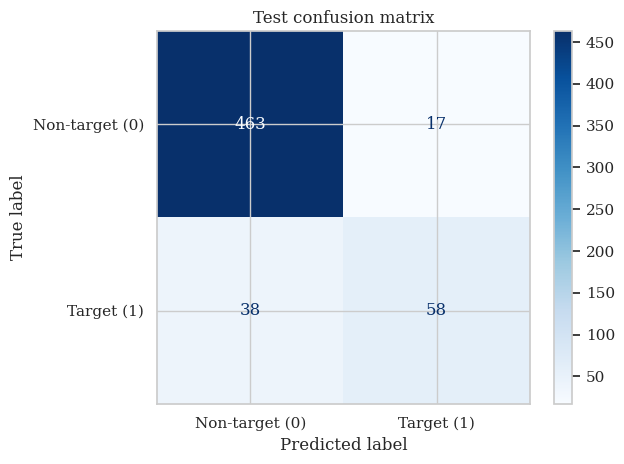

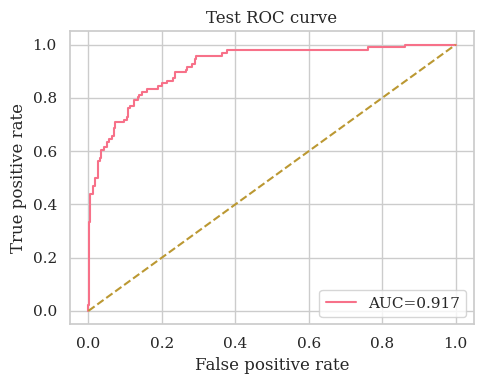

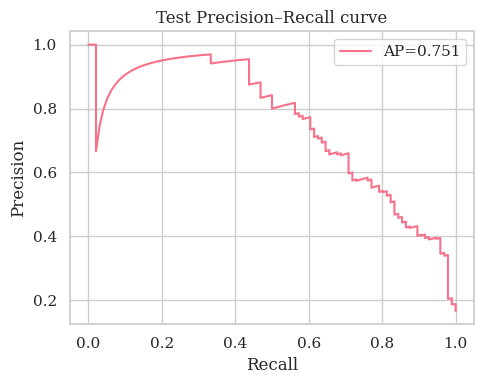

y_true counts: Counter({0: 480, 1: 96})
y_pred counts: Counter({0: 501, 1: 75})


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# extract true labels from test metadata
meta_test = test_set.get_metadata()
label_col = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col].to_numpy().astype(int)

# model predictions
y_proba = fast_clf.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

# sanity checks (VERY useful)
print("y_true counts:", Counter(y_true))
print("y_pred counts:", Counter(y_pred))

# confusion matrix (force 2x2)
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Non-target (0)", "Target (1)"]
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Test confusion matrix")
plt.tight_layout()
plt.show()


# ROC curve
if has_both:
    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.title("Test ROC curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Precision-Recall curve (often more informative for P300 imbalance)
if has_both:
    precision, recall, _ = precision_recall_curve(y_true, y_proba[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(recall, precision, label=f"AP={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Test Precision–Recall curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# sanity prints for the "only two squares filled" confusion matrix issue
from collections import Counter
print("y_true counts:", Counter(y_true))
print("y_pred counts:", Counter(y_pred))

# EEGNet

Adapted from https://braindecode.org/stable/generated/braindecode.models.EEGNet.html
We train the model on the same exact windows and data splits as before but use EEGNet instead. 

### Model from Lawhern et al., 2018

## Infer input dimensions
We try to infer n_chans and n_times from the first window in training set. Braindecode WindowDataset returns (X,y,i) in __getitem__, where X is a torch.Tensor with shape (n_chans, n_times) OR sometimes (1, n_chans, n_times) depending on transforms. 

In [ ]:
import torch
import numpy as np
from collections import Counter

from braindecode.models import EEGNet
from braindecode import EEGClassifier

X0 = train_set[0][0]  # get first window data
if isinstance(X0, np.ndarray):
    X0 = torch.tensor(X0)

# Sometimes people end up with (1, n_chans, n_times) depending on transforms
if X0.ndim == 3 and X0.shape[0] == 1:
    X0 = X0.squeeze(0)

if X0.ndim != 2:
    raise RuntimeError(f"Expected 2D data (n_chans, n_times), got shape: {tuple(X0.shape)}")

n_chans = int(X0.shape[0])
n_times = int(X0.shape[1])

# infer label columns name from metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_train = meta_train[label_col].to_numpy().astype(int)

classes = np.unique(y_train)
n_classes = int(classes.size)

print("Label column:", label_col)
print("Classes found:", classes, "n_classes:", n_classes)
print("EEGNet input dims:", "n_chans =", n_chans, "n_times =", n_times)
print("Train label counts:", Counter(y_train))


Label column: target
Classes found: [0 1] n_classes: 2
EEGNet input dims: n_chans = 8 n_times = 409
Train label counts: Counter({0: 12960, 1: 2592})


In [ ]:
# set device (check if GPU is available) and seeds (for reproducibility)
from braindecode.util import set_random_seeds

cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"

if cuda:
    torch.backends.cudnn.benchmark = True

set_random_seeds(seed=20200220, cuda=cuda)

print("Using device:", device)

Using device: cuda


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


## Build EEGNet model

In [ ]:
# EEGNet has several architecture paramters
# We keep defaults first -> After you get a baseline, you can tune F1, D, kernel_length, drop_prob, etc.

eegnet_model = EEGNet(
    n_chans=n_chans,
    n_outputs=n_classes,
    n_times=n_times,
    final_conv_length="auto", # infer final layer size
    # pool_mode="mean", # default; you can switch to "max" pooling if you want
    # drop_prob=0.25,   # default dropout probability
).to(device)

print(eegnet_model)


Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGNet (EEGNet)                                              [1, 8, 409]               [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1                                 [1, 8, 409]               [1, 8, 409, 1]            --                        --
├─Rearrange (dimshuffle): 1-2                                [1, 8, 409, 1]            [1, 1, 8, 409]            --                        --
├─Conv2d (conv_temporal): 1-3                                [1, 1, 8, 409]            [1, 8, 8, 410]            512                       [1, 64]
├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 8, 410]            [1, 8, 8, 410]            16                        --
├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 8, 410]            [1, 16, 1, 410]           --                  

## EEGNet fast baseline (no CV, no HPO)

In [ ]:
from skorch.callbacks import EpochScoring
from sklearn.metrics import balanced_accuracy_score, make_scorer

# Accuracy (train)
train_acc_cb = EpochScoring(
    scoring="accuracy",
    on_train=True,
    name="train_accuracy",
    lower_is_better=False,
)

# Balanced accuracy (train)
train_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=True,
    name="train_balanced_accuracy",
    lower_is_better=False,
)
# Accuracy (valid)
valid_acc_cb = EpochScoring(
    scoring="accuracy",
    on_train=False,
    name="valid_accuracy",
    lower_is_better=False,
)
# Balanced accuracy (valid)
valid_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=False,
    name="valid_balanced_accuracy",
    lower_is_better=False,
)


# Fast baseline hyperparams based on first run of CV and HPO
lr = 0.00038809762950116534
batch_size = 32
weight_decay: 0.000997517836738623
drop_prob: 0.530710204487765
F1: 16
D: 4
kernel_length: 128
max_epochs = 21

clf_eegnet_fast = EEGClassifier(
    eegnet_model,
    criterion=torch.nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    optimizer__lr=lr,
    batch_size=batch_size,
    max_epochs=max_epochs,
    device=device,
    iterator_train__shuffle=True,
    train_split=None,
    classes=list(range(n_classes)),
    callbacks=[
        ("train_accuracy", train_acc_cb),
        ("train_balanced_accuracy", train_bacc_cb),
        ("valid_accuracy", valid_acc_cb),
        ("valid_balanced_accuracy", valid_bacc_cb),
    ],
)

# Fit once on full training set
clf_eegnet_fast.fit(train_set, y=None)

  epoch    train_accuracy    train_balanced_accuracy    train_loss     dur
-------  ----------------  -------------------------  ------------  ------
      1            0.9661                     0.9297        0.0875  6.2189
      2            0.9644                     0.9245        0.0995  4.5728
      3            0.9679                     0.9411        0.0895  2.9721
      4            0.9688                     0.9354        0.0866  2.9535
      5            0.9549                     0.9062        0.0963  2.5902
      6            0.9653                     0.9333        0.0863  2.7161
      7            0.9618                     0.9208        0.0940  2.4877
      8            0.9696                     0.9359        0.0800  2.5340
      9            0.9635                     0.9302        0.0833  2.5244
     10            0.9757                     0.9479        0.0769  2.6581
     11            0.9679                     0.9328        0.0937  2.5279
     12            0.9740

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=================================================================================================================================================================
  Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
  ================================================================================================================================================================
  EEGNet (EEGNet)                                              [1, 16, 409]              [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1                                 [1, 16, 409]              [1, 16, 409, 1]           --                        --
  ├─Rearrange (dimshuffle): 1-2                                [1, 16, 409, 1]           [1, 1, 16, 409]           --                        --
  ├─Conv2d (conv_temporal): 1-3                                [1, 1, 16, 409]           [1, 8, 16, 410]           512                       [1, 64]
  ├─BatchNorm2d (bnorm_temporal): 1-4                          [1, 8, 16, 410]           [1, 8, 16, 410]           16                        --
  ├─ParametrizedConv2dWithConstraint (conv_spatial): 1-5       [1, 8, 16, 410]           [1, 16, 1, 410]           --                        [16, 1]
  │    └─ModuleDict (parametrizations): 2-1                    --                        --                        --                        --
  │    │    └─ParametrizationList (weight): 3-1                --                        [16, 1, 16, 1]            256                       --
  ├─BatchNorm2d (bnorm_1): 1-6                                 [1, 16, 1, 410]           [1, 16, 1, 410]           32                        --
  ├─ELU (elu_1): 1-7                                           [1, 16, 1, 410]           [1, 16, 1, 410]           --                        --
  ├─AvgPool2d (pool_1): 1-8                                    [1, 16, 1, 410]           [1, 16, 1, 102]           --                        [1, 4]
  ├─Dropout (drop_1): 1-9                                      [1, 16, 1, 102]           [1, 16, 1, 102]           --                        --
  ├─Conv2d (conv_separable_depth): 1-10                        [1, 16, 1, 102]           [1, 16, 1, 103]           256                       [1, 16]
  ├─Conv2d (conv_separable_point): 1-11                        [1, 16, 1, 103]           [1, 16, 1, 103]           256                       [1, 1]
  ├─BatchNorm2d (bnorm_2): 1-12                                [1, 16, 1, 103]           [1, 16, 1, 103]           32                        --
  ├─ELU (elu_2): 1-13                                          [1, 16, 1, 103]           [1, 16, 1, 103]           --                        --
  ├─AvgPool2d (pool_2): 1-14                                   [1, 16, 1, 103]           [1, 16, 1, 12]            --                        [1, 8]
  ├─Dropout (drop_2): 1-15                                     [1, 16, 1, 12]            [1, 16, 1, 12]            --                        --
  ├─Sequential (final_layer): 1-16                             [1, 16, 1, 12]            [1, 2]                    --                        --
  │    └─Conv2d (conv_classifier): 2-2                         [1, 16, 1, 12]            [1, 2, 1, 1]              386                       [1, 12]
  │    └─Rearrange (permute_back): 2-3                         [1, 2, 1, 1]              [1, 2, 1, 1]              --                        --
  │    └─SqueezeFinalOutput (squeeze): 2-4                     [1, 2, 1, 1]              [1, 2]                    --                        --
  │    │    └─Rearrange (squeeze): 3-2                         [1, 2, 1, 1]              [1, 2, 1]                 --                        --
  =========================================================================================================

### Evaluate of test set

In [ ]:
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

y_proba = clf_eegnet_fast.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet FAST baseline (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")

EEGNet FAST baseline (test)
  accuracy: 0.9080
  balanced_accuracy: 0.8365
  roc_auc: 0.9144
  avg_precision: 0.7961


## EEGNet with HPO and CV

In this section we tune EEGNet hyperparamters using optuna. Each optuna trial is evaluated via GroupKFold cross-validation and we optimise mean balanced accuracy across folds.

In [ ]:
from sklearn.model_selection import GroupKFold
from torch.utils.data import Subset

from skorch.callbacks import EpochScoring, EarlyStopping
from sklearn.metrics import balanced_accuracy_score, make_scorer
from skorch.helper import predefined_split

def build_eegnet_clf(
    n_chans, 
    n_times, 
    n_classes, 
    device, 
    lr, 
    batch_size, 
    weight_decay, 
    drop_prob, 
    F1, 
    D, 
    kernel_length, 
    depthwise_kernel_length,
    max_epochs,
    valid_ds=None,
    patience=10,
    monitor="valid_loss",
):
    
    # Accuracy (train)
    train_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=True,
        name="train_accuracy",
        lower_is_better=False,
    )

    # Balanced accuracy (train)
    train_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=True,
        name="train_balanced_accuracy",
        lower_is_better=False,
    )
    # Accuracy (valid)
    valid_acc_cb = EpochScoring(
        scoring="accuracy",
        on_train=False,
        name="valid_accuracy",
        lower_is_better=False,
    )
    # Balanced accuracy (valid)
    valid_bacc_cb = EpochScoring(
        scoring=make_scorer(balanced_accuracy_score),
        on_train=False,
        name="valid_balanced_accuracy",
        lower_is_better=False,
    )
    # Create a fresh EEGNet + EEGClassifier for a given hyperparameter configuration.
    # We build a new model each time so folds and trials do not leak state.
    model = EEGNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        drop_prob=drop_prob,
        F1=F1,
        D=D,
        kernel_length=kernel_length,
        depthwise_kernel_length=depthwise_kernel_length,
    ).to(device)

    callbacks = [
        ("train_bacc", train_bacc_cb),
        ("valid_bacc", valid_bacc_cb),
    ]

    train_split = None

    if valid_ds is not None:
        train_split = predefined_split(valid_ds)
        callbacks.append(
            ("early_stopping", EarlyStopping(
                monitor=monitor,
                patience=patience,
                lower_is_better=True,
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True,
            ))
        )

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        train_split=(predefined_split(valid_ds) if valid_ds is not None else None), 
        classes=list(range(n_classes)),
        callbacks=callbacks,
    )
    return clf


**Trying with optuna**
- Automated loop that tries hyperparamter combinations and keeps best one depending on single score chosen (different than one used in ShallowNet).
- Optuna keeps track of scores and decides what to do next. 
- Optuna prunes trials that look bad based on intermediate results.
    - MedianPruner logic:
        - Optuna looks at the distribution of intermediate scores from previous trials in that step and if current trial's intermediate score is worse than median, it gets pruned.
- Every paramter combination trained and evaluated across CV folds (unless pruned).
    - The loop folds:
        - build model with those hyperparameters.
        - fit on training fold.
        - predict on validation fold.
        - compute balanced accuracy.
    - Return mean fold score.
- study.optimize:
    - optuna runs objective(trial) up to n_trials and each run is a new hyperparameter suggestion.

**Continuous Paramters**
- Log: samples log space between values
    - lr
- Uniform sampling: samples over those ranges
    - weight decay, drop_prob
**Discrete choices**
- picks one option each
    - batch size, f1, D, kernel length
**Integer range**
- picks integer in range
    - max epochs

**TPE (tree-structured parzen estimator)**
- It is a Bayesian optimisation style sampler
- Intuition:
    - after some trials, Optuna splits observed trials into "good" trials (high objective values) and "bad" trials (low objective values)
    - It models where "good" hyperparamters tend to lie and then samples new candidates that are more likely to come from the "good" region"
- Early trials are more exploratory, while later trials are more likely to come from a good region

**Training parameters:**\
learning rate (lr): controls how big each gradient update is (too big=unstable training, too low=very slow learning).

batch_size: number of trials processed before one optimiser update (smaller=noisier gradients, more regularisation and larger=smoother gradients, can overfit more easily).

weight_decay: L2 regularisation strength (penalises large weights to prevent overfitting).

drop_prob (dropout prob): fraction of activations randomly set to zero during training (too low=weak regularisation and too high=underfitting).

max_epochs: number of full passes over training data (more=better convergence but risk of overfitting).

**EEGNet architecture parameters:**\
F1 (number of temporal filters): filters in first temporal convolution layer. Controls how many distinct temporal patterns are learned (larger=more expressive temporal modelling but higher risk of overfitting).

kernel_length: length of temporal convolution kernel (in samples). Determines the temporal window the model "sees" at once. Short kenerls capture sharp/fast components while longer ones capture slow/sustained ERP components.

D (depth multiplier): controls how many spatial filters are learned per temporal filter. Implemented via depthwise convolution. Larger D means more spatial patterns per frequency/temporal feature and more paramters.








In [ ]:
import optuna
from sklearn.metrics import balanced_accuracy_score, accuracy_score

MAX_EPOCHS = 80

def objective(trial: optuna.Trial) -> float:
    print(f"Trial {trial.number} started")
    # Hyperparameter search space (moderate ranges for EEGNet)
    lr = trial.suggest_float("lr", 1e-4, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    drop_prob = trial.suggest_float("drop_prob", 0.1, 0.6)

    # EEGNet architecture knobs
    F1 = trial.suggest_categorical("F1", [4, 8, 16, 32])
    D = trial.suggest_categorical("D", [1, 2, 4])
    kernel_length = trial.suggest_categorical("kernel_length", [16, 32, 64, 96, 128])
    depthwise_kernel_length = trial.suggest_categorical("depthwise_kernel_length", [8, 16, 24, 32])

    patience = trial.suggest_int("patience", 8, 15)

    max_epochs = MAX_EPOCHS

    fold_scores = []

    # Loop folds
    for fold_idx, (tr_idx, va_idx) in enumerate(cv.split(np.zeros(len(train_set)), y_train, groups)):
        set_random_seeds(seed=2025 + fold_idx, cuda=cuda)

        tr_ds_full = Subset(train_set, tr_idx)
        va_ds = Subset(train_set, va_idx)

        # Inner split inside the training fold for early stopping
        n_tr = len(tr_ds_full)
        rng = np.random.RandomState(2025 + fold_idx)
        perm = rng.permutation(n_tr)
        n_valid_inner = max(1, int(0.2 * n_tr))

        inner_valid_idx = perm[:n_valid_inner]
        inner_train_idx = perm[n_valid_inner:]

        inner_train_ds = Subset(tr_ds_full, inner_train_idx)
        inner_valid_ds = Subset(tr_ds_full, inner_valid_idx)

        clf = build_eegnet_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            batch_size=batch_size,
            weight_decay=weight_decay,
            drop_prob=drop_prob,
            F1=F1,
            D=D,
            kernel_length=kernel_length,
            max_epochs=max_epochs,
            depthwise_kernel_length=depthwise_kernel_length,
            valid_ds=inner_valid_ds,
            patience=patience,
            monitor="valid_loss",
        )

        clf.fit(inner_train_ds, y=None)

        # Validation predictions
        y_va_true = y_train[va_idx]
        y_va_proba = clf.predict_proba(va_ds)
        y_va_pred = np.argmax(y_va_proba, axis=1)

        fold_bacc = balanced_accuracy_score(y_va_true, y_va_pred)
        fold_scores.append(fold_bacc)

        # Report intermediate score so Optuna can prune bad trials
        trial.report(np.mean(fold_scores), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Save fold stats for this completed trial
    bacc_arr = np.array(fold_scores, dtype=float)
    trial.set_user_attr("fold_bacc", bacc_arr.tolist())
    trial.set_user_attr("fold_bacc_mean", float(np.mean(bacc_arr)))
    trial.set_user_attr("fold_bacc_std", float(np.std(bacc_arr)))


    mean_bacc = float(np.mean(bacc_arr))
    print(f"Trial {trial.number} finished | mean bacc: {mean_bacc:.4f}")

    return mean_bacc


Run the HPO

In [ ]:
# starting small to verify everything runs
n_trials = 40

sampler = optuna.samplers.TPESampler(seed=2025)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1)
optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study(direction="maximize", sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=n_trials)

print("Best CV score (mean balanced accuracy):", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

In [ ]:
# After the run: inspect the best trial's fold stats
best = study.best_trial
print("Best trial fold bacc:", best.user_attrs.get("fold_bacc"))
print("Best trial mean bacc:", best.user_attrs.get("fold_bacc_mean"))
print("Best trial std bacc:", best.user_attrs.get("fold_bacc_std"))


Best trial fold bacc: [0.7395833333333333, 0.8586805555555556, 0.8027777777777778, 0.8208333333333333, 0.8677083333333333, 0.7645833333333334, 0.7243055555555555, 0.7909722222222222, 0.8993055555555556]
Best trial mean bacc: 0.8076388888888889
Best trial std bacc: 0.056294516373543345


In [ ]:
# Build a dataframe of all trials (including fold stats)
import pandas as pd

rows = []
for t in study.trials:
    rows.append({
        "trial": t.number,
        "value": t.value,
        "mean_bacc": t.user_attrs.get("fold_bacc_mean"),
        "std_bacc": t.user_attrs.get("fold_bacc_std"),
        "fold_bacc": t.user_attrs.get("fold_bacc"),
        **t.params,
    })

df = pd.DataFrame(rows)
df_sorted = df.sort_values("mean_bacc", ascending=False)
print(df_sorted.head(15)[["trial", "mean_bacc", "std_bacc"]])

    trial  mean_bacc  std_bacc
33     33   0.807639  0.056295
32     32   0.806366  0.058489
21     21   0.802508  0.054301
23     23   0.800116  0.056471
25     25   0.799537  0.064239
20     20   0.797878  0.058972
22     22   0.796026  0.059465
17     17   0.794907  0.053688
16     16   0.793596  0.056963
31     31   0.791782  0.058190
14     14   0.791011  0.060048
15     15   0.790394  0.060227
12     12   0.786343  0.057528
11     11   0.780710  0.062723
2       2   0.780440  0.063772


### Plots for optuna trials

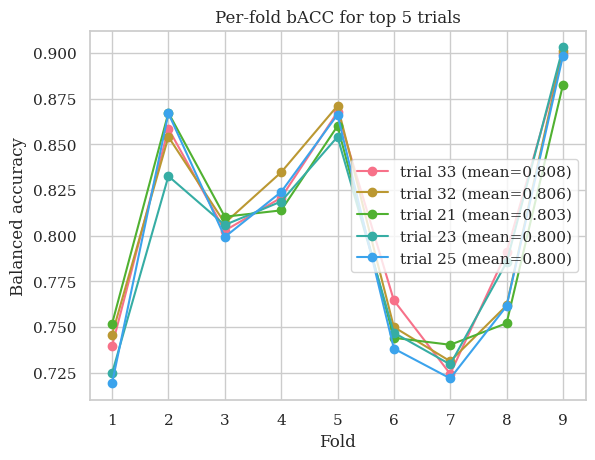

In [ ]:
top_k = 5
top = df_sorted.head(top_k)

plt.figure()
for _, r in top.iterrows():
    fb = r["fold_bacc"]
    if fb is None:
        continue
    plt.plot(range(1, len(fb) + 1), fb, marker="o",
             label=f"trial {int(r['trial'])} (mean={r['mean_bacc']:.3f})")

plt.xlabel("Fold")
plt.ylabel("Balanced accuracy")
plt.title(f"Per-fold bACC for top {top_k} trials")
plt.legend()
plt.show()


In [ ]:
stable_best = (
    df.dropna(subset=["mean_bacc", "std_bacc"])
      .sort_values(["mean_bacc", "std_bacc"], ascending=[False, True])
      .iloc[0]
)

print("Best stable trial:")
print(stable_best[["trial", "mean_bacc", "std_bacc"]])


Best stable trial:
trial              33
mean_bacc    0.807639
std_bacc     0.056295
Name: 33, dtype: object


### CV for epochs

In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset
from sklearn.metrics import balanced_accuracy_score

#helpers
def best_epoch_from_history(net):
    """Return 1-indexed epoch of best validation loss from skorch history."""
    hist = pd.DataFrame(net.history)
    if "valid_loss" not in hist.columns:
        raise ValueError("No valid_loss in net.history. Make sure valid_ds + predefined_split are used.")
    if hist["valid_loss"].isna().all():
        raise ValueError("valid_loss is all NaN. Validation may not be wired correctly.")
    return int(hist["valid_loss"].astype(float).idxmin() + 1)

def indices_for_subject(meta_df, subj_id):
    subj = meta_df["subject"].to_numpy()
    return np.where(subj == subj_id)[0]

def indices_not_subject(meta_df, subj_id):
    subj = meta_df["subject"].to_numpy()
    return np.where(subj != subj_id)[0]

def get_y_from_subset(ds_subset):
    # Works for braindecode datasets where __getitem__ returns (X, y)
    return np.array([ds_subset[i][1] for i in range(len(ds_subset))])


In [ ]:
# setup metadata + params for EEGNet calibration
meta = train_set.get_metadata()
subjects_cv = np.unique(meta["subject"].to_numpy())

params_eeg = fallback_params_eegnet

MAX_EPOCHS_CAL = 80  # generous cap, early stopping decides
BUFFER = 1.15        # 10–15% buffer for final refit (no validation)

print("n_subjects:", len(subjects_cv))
print("subjects:", subjects_cv)


n_subjects: 9
subjects: [1 2 3 4 5 6 7 8 9]


In [ ]:
# CELL 5: LOGO epoch calibration for EEGNet + print held-out subject BACC
best_epochs_eegnet = []
valid_baccs_eegnet = []

for s in subjects_cv:
    tr_idx = indices_not_subject(meta, s)
    va_idx = indices_for_subject(meta, s)

    train_ds = Subset(train_set, tr_idx)
    valid_ds = Subset(train_set, va_idx)

    net_eeg = build_eegnet_clf(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=params["lr"],
        batch_size=params["batch_size"],
        weight_decay=params["weight_decay"],
        drop_prob=params["drop_prob"],
        F1=params["F1"],
        D=params["D"],
        kernel_length=params["kernel_length"],
        depthwise_kernel_length=params["depthwise_kernel_length"],
        max_epochs=MAX_EPOCHS_CAL,
        valid_ds=valid_ds,
        patience=params["patience"],
        monitor="valid_loss",
    )

    net_eeg.fit(train_ds, y=None)

    e_best_eeg = best_epoch_from_history(net_eeg)
    best_epochs_eegnet.append(e_best_eeg)

    # Evaluate held-out subject with best-restored weights (load_best=True)
    y_true = get_y_from_subset(valid_ds)
    y_pred = net_eeg.predict(valid_ds)
    bacc_eeg = balanced_accuracy_score(y_true, y_pred)
    valid_baccs_eegnet.append(bacc_eeg)

    print(
        f"val_subject={s} | best_epoch={e_best_eeg} | "
        f"valid_bacc={bacc_eeg:.3f} | ran_epochs={len(net_eeg.history)}"
    )

best_epochs_eegnet = np.array(best_epochs_eegnet, dtype=int)
valid_baccs_eegnet = np.array(valid_baccs_eegnet, dtype=float)

E_ref_eegnet = int(np.median(best_epochs_eegnet))
max_epochs_final_eegnet = int(np.ceil(E_ref_eegnet * BUFFER))


  epoch    train_balanced_accuracy    train_loss    valid_acc    valid_balanced_accuracy    valid_loss     dur
-------  -------------------------  ------------  -----------  -------------------------  ------------  ------
      1                     0.6594        0.3265       0.8565                     0.6833        0.3679  6.0219
      2                     0.7432        0.2751       0.8495                     0.7389        0.3537  5.4897
      3                     0.7606        0.2608       0.8519                     0.7597        0.3448  5.4198
      4                     0.7668        0.2537       0.8571                     0.7684        0.3340  5.4644
      5                     0.7720        0.2493       0.8576                     0.7910        0.3377  5.4499
      6                     0.7833        0.2466       0.8478                     0.7462        0.3544  5.4719
      7                     0.7803        0.2442       0.8576                     0.7660        0.3466  5.2810
 

In [ ]:
print("\nEEGNet best epochs per subject:", best_epochs_eegnet.tolist())
print("EEGNet E_ref (median best epoch):", E_ref_eegnet)
print("EEGNet max_epochs_final (buffered):", max_epochs_final_eegnet)
print("EEGNet valid_bacc mean±std:", f"{valid_baccs_eegnet.mean():.3f} ± {valid_baccs_eegnet.std():.3f}")
print(valid_baccs_eegnet)


EEGNet best epochs per subject: [9, 18, 1, 14, 50, 2, 13, 1, 21]
EEGNet E_ref (median best epoch): 13
EEGNet max_epochs_final (buffered): 15
EEGNet valid_bacc mean±std: 0.806 ± 0.059
[0.71840278 0.85868056 0.79027778 0.83715278 0.87604167 0.77916667
 0.74791667 0.75451389 0.89513889]


### Refit best EEGNet on full training set and evaluate on test set

In [ ]:
fallback_params_eegnet = {
   'lr': 0.00035245793071781275,
    'batch_size': 32,
    'weight_decay': 7.4259271410164125e-06,
    'drop_prob': 0.5941040909682417,
    'F1': 32,
    'D': 4,
    'kernel_length': 64,
    'depthwise_kernel_length': 8,
    'patience': 8
    }

In [ ]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score

MAX_EPOCHS = 15

try:
    best = study.best_params
    source = "study.best_params"
except NameError:
    best = fallback_params_eegnet
    source = "fallback_params_eegnet"


# Build final clf using best params
set_random_seeds(seed=2025, cuda=torch.cuda.is_available())

final_clf_eegnet = build_eegnet_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=best["lr"],
    batch_size=best["batch_size"],
    weight_decay=best["weight_decay"],
    drop_prob=best["drop_prob"],
    F1=best["F1"],
    D=best["D"],
    kernel_length=best["kernel_length"],
    depthwise_kernel_length=best["depthwise_kernel_length"],
    max_epochs=MAX_EPOCHS,
)

final_clf_eegnet.fit(train_set, y=None)

# Test evaluation
meta_test = test_set.get_metadata()
label_col_test = "target" if "target" in meta_test.columns else "label"
y_true = meta_test[label_col_test].to_numpy().astype(int)

y_proba = final_clf_eegnet.predict_proba(test_set)
y_pred = np.argmax(y_proba, axis=1)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)

if y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2:
    auc = roc_auc_score(y_true, y_proba[:, 1])
    ap  = average_precision_score(y_true, y_proba[:, 1])
else:
    auc = float("nan")
    ap  = float("nan")

print("EEGNet HPO+CV (test)")
print(f"  accuracy: {acc:.4f}")
print(f"  balanced_accuracy: {bacc:.4f}")
print(f"  roc_auc: {auc:.4f}")
print(f"  avg_precision: {ap:.4f}")


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_balanced_accuracy    train_loss     dur
-------  -------------------------  ------------  ------
      1                     0.6577        0.3324  5.3994
      2                     0.7466        0.2735  5.3341
      3                     0.7505        0.2665  5.6372
      4                     0.7631        0.2608  5.5848
      5                     0.7650        0.2580  5.5806
      6                     0.7696        0.2543  5.6628
      7                     0.7681        0.2510  5.4396
      8                     0.7775        0.2487  5.1810
      9                     0.7815        0.2466  5.3670
     10                     0.7836        0.2452  5.5464
     11                     0.7867        0.2392  5.3413
     12                     0.7860        0.2427  5.5630
     13                     0.7867        0.2431  5.2865
     14                     0.7895        0.2386  5.2816
     15                     0.7846        0.2400  5.4152
EEGNet HPO+CV (test)
  accuracy

In [ ]:
best

{'lr': 0.00035245793071781275,
 'batch_size': 32,
 'weight_decay': 7.4259271410164125e-06,
 'drop_prob': 0.5941040909682417,
 'F1': 32,
 'D': 4,
 'kernel_length': 64,
 'depthwise_kernel_length': 8,
 'patience': 8}

### Save weights

In [ ]:
import os

save_dir = "models_eegnet"
os.makedirs(save_dir, exist_ok=True)

seed = 2025
run_id = "hpo_v15epochs"

path_eegnet = os.path.join(
    save_dir,
    f"eegnet_{run_id}_seed{seed}.pkl"
)

final_clf_eegnet.save_params(f_params=path_eegnet)

#clf.load_params(f_params=path_eegnet)

## Plots

Functions and imports to plot

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    balanced_accuracy_score,
    accuracy_score,
)

def _get_y_true(ds, label_col_preference=("target", "label")) -> np.ndarray:
    meta = ds.get_metadata()
    for col in label_col_preference:
        if col in meta.columns:
            return meta[col].to_numpy().astype(int)
    # fallback: second element of each item (works for many datasets, but slower)
    return np.array([ds[i][1] for i in range(len(ds))], dtype=int)

def _get_proba_and_pred(clf, ds):
    """
    Returns:
      y_true: (n,)
      y_proba: (n, 2) for binary OR (n, n_classes) for multiclass
      y_pred: (n,)
    """
    y_true = _get_y_true(ds)

    # EEGClassifier exposes predict_proba / predict in most setups
    y_proba = clf.predict_proba(ds)
    y_pred = clf.predict(ds)

    y_proba = np.asarray(y_proba)
    y_pred = np.asarray(y_pred).astype(int)
    return y_true, y_proba, y_pred

def plot_confmat(y_true, y_pred, title="Confusion matrix", normalize=None):
    #normalize: None | "true" | "pred" | "all" (sklearn option)
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots()
    disp.plot(ax=ax, values_format=".2f" if normalize else "d", colorbar=False)
    ax.set_title(title)
    plt.show()


def plot_history_loss_and_accuracy(clf, title="Training curves (loss + accuracy)"):
    """
    Plots loss and (if available) accuracy on the same figure using twin y-axes.
    Compatible with multiple skorch versions.
    """

    hist_obj = getattr(clf, "history", None)
    if hist_obj is None:
        print("No clf.history found. Did you fit the model?")
        return

    # skorch History often supports .to_list()
    if hasattr(hist_obj, "to_list"):
        hist = pd.DataFrame(hist_obj.to_list())
    else:
        # fallback: try to coerce history directly
        try:
            hist = pd.DataFrame(hist_obj)
        except Exception:
            print("Could not convert clf.history to a table. Available:", dir(hist_obj))
            return

    if hist.empty:
        print("History is empty. Did training run?")
        return

    # Identify columns (names differ depending on callbacks and versions)
    loss_candidates = ["train_loss", "valid_loss"]
    acc_candidates = ["train_accuracy", "valid_accuracy", "train_acc", "valid_acc", "accuracy", "acc"]

    loss_cols = [c for c in loss_candidates if c in hist.columns]
    acc_cols = [c for c in acc_candidates if c in hist.columns]

    # If you have epochs in history, use them, else use index
    x = hist["epoch"].values if "epoch" in hist.columns else np.arange(len(hist))

    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_xlabel("Epoch")

    if loss_cols:
        for c in loss_cols:
            ax1.plot(x, hist[c].values, label=c)
        ax1.set_ylabel("Loss")
    else:
        ax1.text(0.5, 0.5, f"No loss columns found. Columns: {list(hist.columns)}",
                 ha="center", va="center")
        plt.show()
        return

    if acc_cols:
        ax2 = ax1.twinx()
        for c in acc_cols:
            ax2.plot(x, hist[c].values, linestyle=":", label=c)
        ax2.set_ylabel("Accuracy")

        # Merge legends from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    else:
        ax1.legend(loc="best")
        print("Note: No accuracy columns found in history. Add an EpochScoring accuracy callback to log it.")

    plt.show()

def plot_history_loss_acc_bacc(clf, title="Training curves"):
    hist = pd.DataFrame(clf.history.to_list())  # works across skorch versions
    x = hist["epoch"].values if "epoch" in hist.columns else np.arange(len(hist))

    loss_cols = [c for c in ["train_loss", "valid_loss"] if c in hist.columns]
    acc_cols  = [c for c in ["train_accuracy", "valid_accuracy"] if c in hist.columns]
    bacc_cols = [c for c in ["train_balanced_accuracy", "valid_balanced_accuracy"] if c in hist.columns]

    fig, ax1 = plt.subplots()
    ax1.set_title(title)
    ax1.set_xlabel("Epoch")

    for c in loss_cols:
        ax1.plot(x, hist[c].values, label=c)
    ax1.set_ylabel("Loss")

    ax2 = ax1.twinx()
    for c in acc_cols:
        ax2.plot(x, hist[c].values, linestyle=":", label=c)
    for c in bacc_cols:
        ax2.plot(x, hist[c].values, linestyle="--", label=c)
    ax2.set_ylabel("Score")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")
    plt.show()

def plot_roc_and_pr(y_true, y_proba, title_prefix="Curves"):
    """
    Plots ROC and Precision Recall for binary classification.
    If not binary, it will still try but may skip AUC/AP.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    is_binary = (y_proba.ndim == 2 and y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2)

    if is_binary:
        scores = y_proba[:, 1]
        fpr, tpr, _ = roc_curve(y_true, scores)
        auc = roc_auc_score(y_true, scores)

        axes[0].plot(fpr, tpr)
        axes[0].set_title(f"{title_prefix}: ROC (AUC={auc:.3f})")
        axes[0].set_xlabel("False Positive Rate")
        axes[0].set_ylabel("True Positive Rate")

        prec, rec, _ = precision_recall_curve(y_true, scores)
        ap = average_precision_score(y_true, scores)

        axes[1].plot(rec, prec)
        axes[1].set_title(f"{title_prefix}: Precision-Recall (AP={ap:.3f})")
        axes[1].set_xlabel("Recall")
        axes[1].set_ylabel("Precision")
    else:
        axes[0].text(0.5, 0.5, "ROC curve: binary only", ha="center", va="center")
        axes[1].text(0.5, 0.5, "PR curve: binary only", ha="center", va="center")

    plt.tight_layout()
    plt.show()


def print_basic_metrics(y_true, y_proba, y_pred, header="Metrics"):
    acc = accuracy_score(y_true, y_pred)
    bacc = balanced_accuracy_score(y_true, y_pred)

    auc = np.nan
    ap = np.nan
    is_binary = (y_proba.ndim == 2 and y_proba.shape[1] == 2 and len(np.unique(y_true)) == 2)
    if is_binary:
        auc = roc_auc_score(y_true, y_proba[:, 1])
        ap = average_precision_score(y_true, y_proba[:, 1])

    print(header)
    print(f"  accuracy:          {acc:.4f}")
    print(f"  balanced_accuracy: {bacc:.4f}")
    print(f"  roc_auc:           {auc:.4f}")
    print(f"  avg_precision:     {ap:.4f}")


### No HPO and CV

Training plots

NO HPO/CV (train)
  accuracy:          0.9887
  balanced_accuracy: 0.9849
  roc_auc:           0.9993
  avg_precision:     0.9968


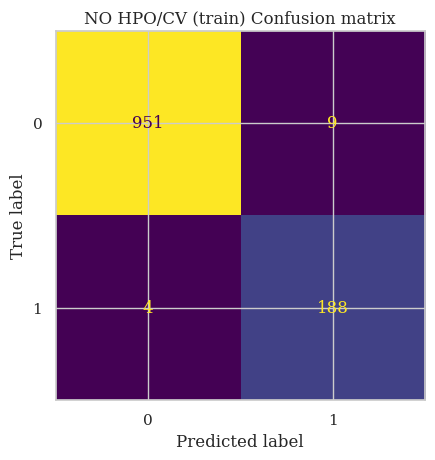

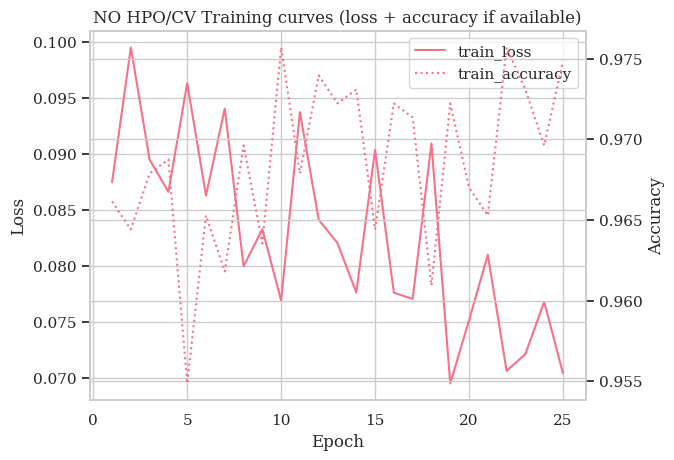

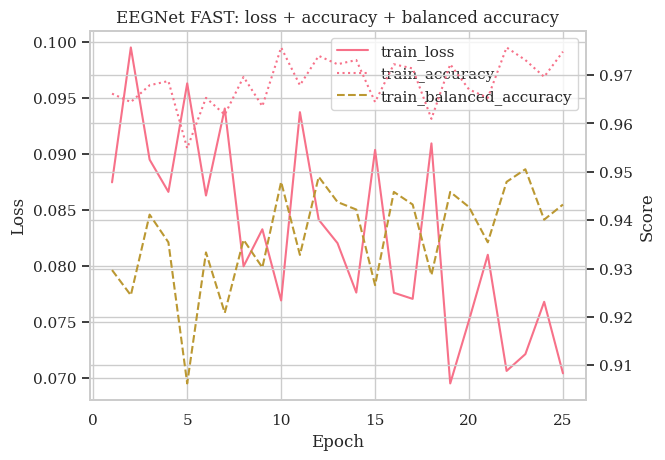

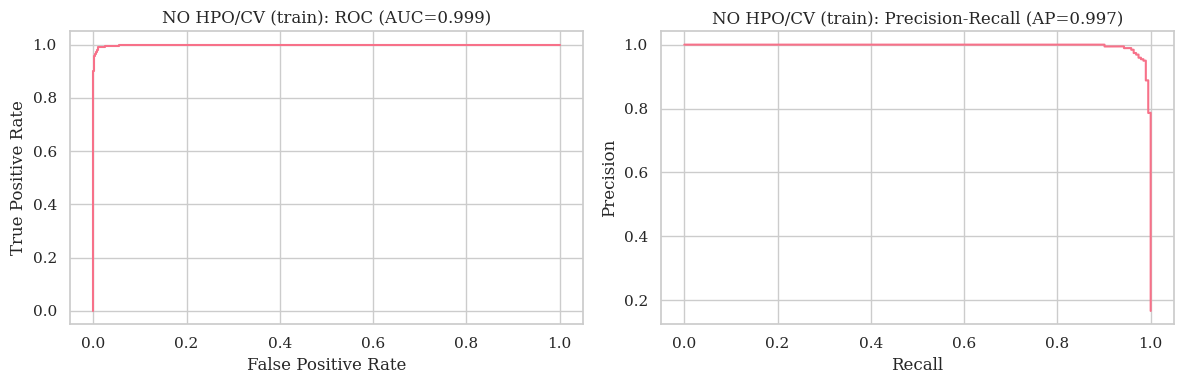

In [ ]:
# training plots (confusion matrix, loss+accuracy, ROC+PR, balanced accuracy)

y_true_tr, y_proba_tr, y_pred_tr = _get_proba_and_pred(clf_eegnet_fast, train_set)

print_basic_metrics(y_true_tr, y_proba_tr, y_pred_tr, header="NO HPO/CV (train)")

plot_confmat(
    y_true_tr,
    y_pred_tr,
    title="NO HPO/CV (train) Confusion matrix",
    normalize=None
)

plot_history_loss_and_accuracy(
    clf_eegnet_fast,
    title="NO HPO/CV Training curves (loss + accuracy if available)"
)

plot_history_loss_acc_bacc(
    clf_eegnet_fast, title="EEGNet FAST: loss + accuracy + balanced accuracy"
)

plot_roc_and_pr(
    y_true_tr,
    y_proba_tr,
    title_prefix="NO HPO/CV (train)"
)


Test plots

NO HPO/CV (test)
  accuracy:          0.9080
  balanced_accuracy: 0.8365
  roc_auc:           0.9144
  avg_precision:     0.7961


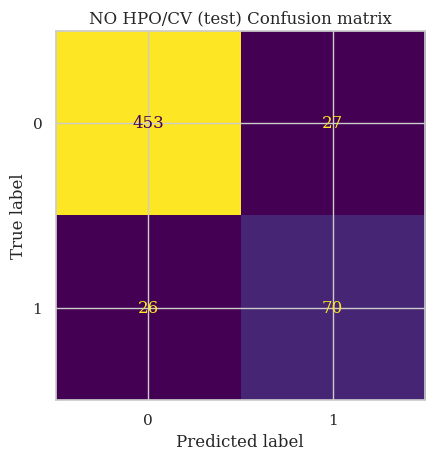

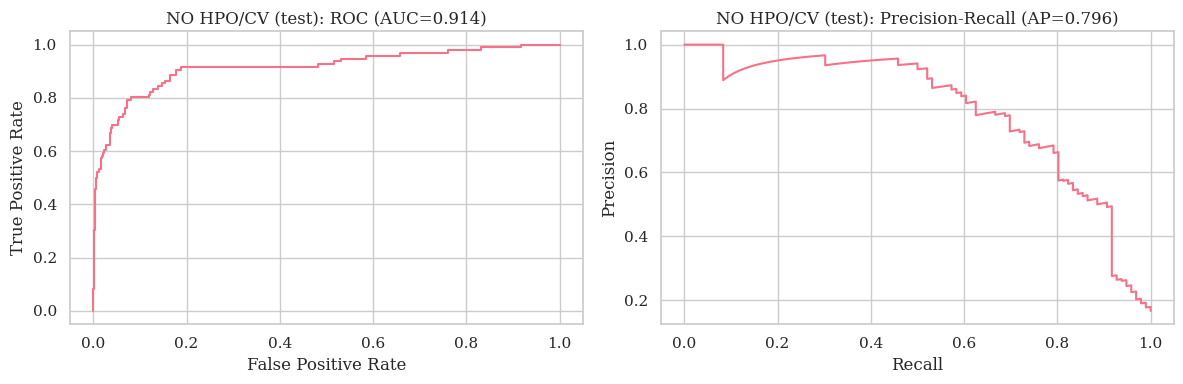

In [ ]:
y_true_te, y_proba_te, y_pred_te = _get_proba_and_pred(clf_eegnet_fast, test_set)

print_basic_metrics(y_true_te, y_proba_te, y_pred_te, header="NO HPO/CV (test)")

plot_confmat(
    y_true_te,
    y_pred_te,
    title="NO HPO/CV (test) Confusion matrix",
    normalize=None
)

plot_roc_and_pr(
    y_true_te,
    y_proba_te,
    title_prefix="NO HPO/CV (test)"
)


### HPO and CV

Training plots

HPO+CV (train)
  accuracy:          0.9191
  balanced_accuracy: 0.8902
  roc_auc:           0.9584
  avg_precision:     0.8595


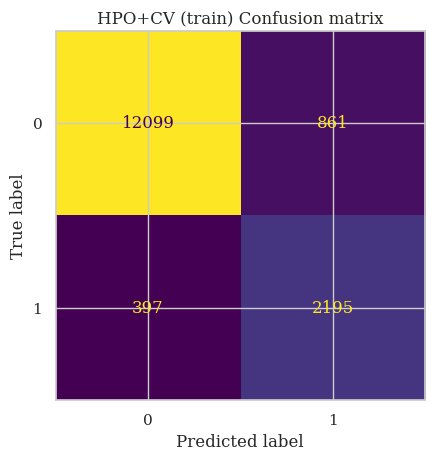

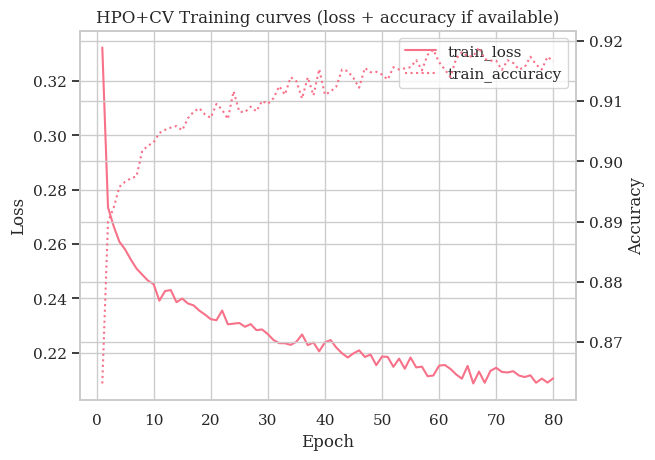

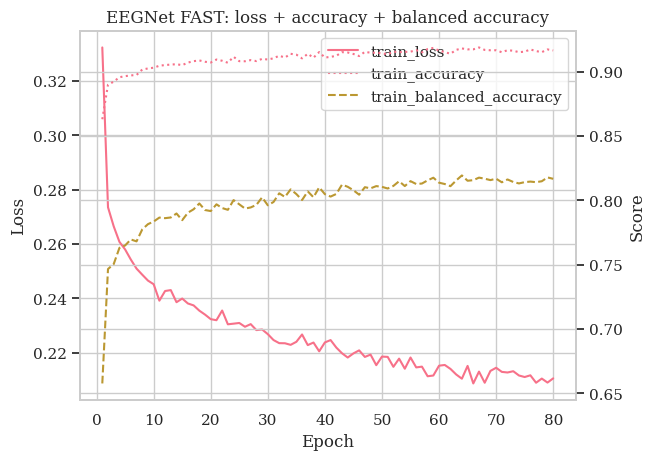

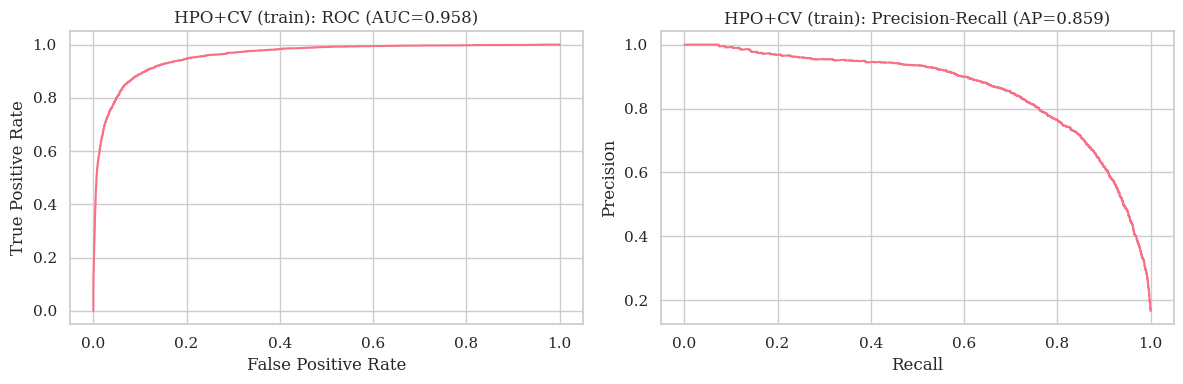

In [ ]:
y_true_tr, y_proba_tr, y_pred_tr = _get_proba_and_pred(final_clf_eegnet, train_set)

print_basic_metrics(y_true_tr, y_proba_tr, y_pred_tr, header="HPO+CV (train)")

plot_confmat(
    y_true_tr,
    y_pred_tr,
    title="HPO+CV (train) Confusion matrix",
    normalize=None
)

plot_history_loss_and_accuracy(
    final_clf_eegnet,
    title="HPO+CV Training curves (loss + accuracy if available)"
)

plot_history_loss_acc_bacc(
    final_clf_eegnet, title="EEGNet FAST: loss + accuracy + balanced accuracy"
)

plot_roc_and_pr(
    y_true_tr,
    y_proba_tr,
    title_prefix="HPO+CV (train)"
)


Test plots

HPO+CV (test)
  accuracy:          0.9178
  balanced_accuracy: 0.8840
  roc_auc:           0.9598
  avg_precision:     0.8672


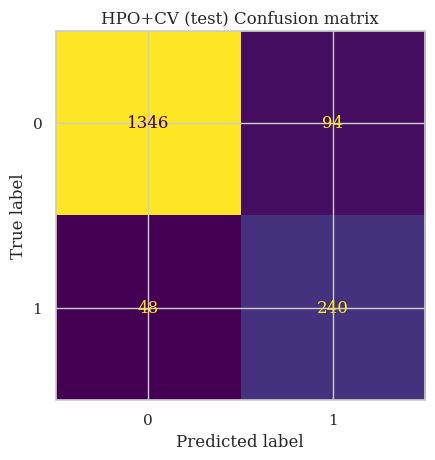

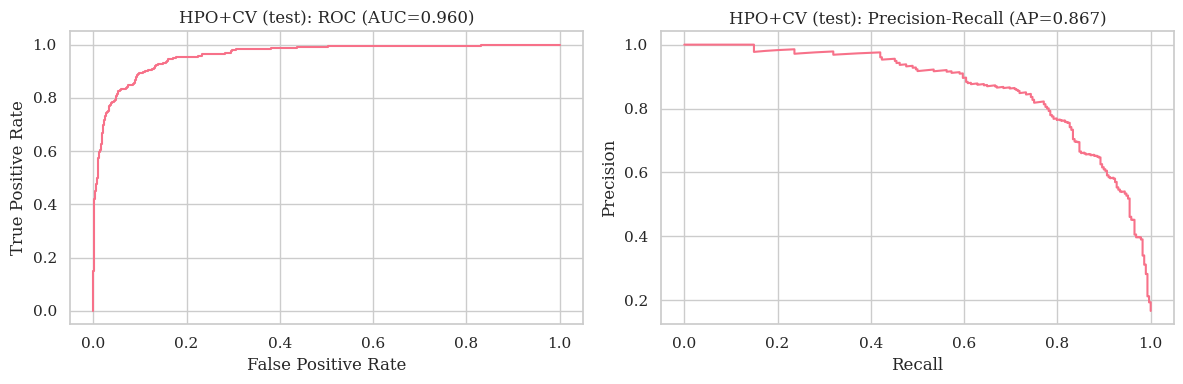

In [ ]:
y_true_te, y_proba_te, y_pred_te = _get_proba_and_pred(final_clf_eegnet, test_set)

print_basic_metrics(y_true_te, y_proba_te, y_pred_te, header="HPO+CV (test)")

plot_confmat(
    y_true_te,
    y_pred_te,
    title="HPO+CV (test) Confusion matrix",
    normalize=None
)

plot_roc_and_pr(
    y_true_te,
    y_proba_te,
    title_prefix="HPO+CV (test)"
)


# Fine-tuning

## Helper functions

### Create split inside the held out participant
- session 1+2 adaptation/valid, session 3 testing

- Use session 1 and 2 for adaptation and session 3 for testing

In [ ]:
from torch.utils.data import Subset

meta_test = test_set.get_metadata().reset_index(drop=True)

# Identify the held-out subject id in test_set (should be 1 unique subject)
heldout_subjects = meta_test["subject"].unique()
HELDOUT_SUBJECT = int(heldout_subjects[0])
print("HELDOUT_SUBJECT =", HELDOUT_SUBJECT)

# Pick sessions for adaptation vs evaluation
sessions_sorted = sorted(meta_test["session"].unique())
print("sessions_sorted:", sessions_sorted)

# Default: first two sessions adapt, last session test
adapt_sessions = sessions_sorted[:-1]
test_sessions  = [sessions_sorted[-1]]

adapt_idx = meta_test.index[meta_test["session"].isin(adapt_sessions)].to_numpy()
subjtest_idx = meta_test.index[meta_test["session"].isin(test_sessions)].to_numpy()

adapt_pool_ds = Subset(test_set, adapt_idx)
subject_test_ds = Subset(test_set, subjtest_idx)

print("Adapt pool windows:", len(adapt_pool_ds))
print("Subject test windows:", len(subject_test_ds))

# Labels for these subsets (pull from metadata to avoid iterating)
y_adapt = meta_test.loc[adapt_idx, "target"].to_numpy().astype(int)
y_subjtest = meta_test.loc[subjtest_idx, "target"].to_numpy().astype(int)

print("Adapt label counts:", {k: int(v) for k, v in zip(*np.unique(y_adapt, return_counts=True))})
print("Test  label counts:", {k: int(v) for k, v in zip(*np.unique(y_subjtest, return_counts=True))})

HELDOUT_SUBJECT = 10
sessions_sorted: ['0', '1', '2']
Adapt pool windows: 1152
Subject test windows: 576
Adapt label counts: {0: 960, 1: 192}
Test  label counts: {0: 480, 1: 96}


### Data split
- Session 1: adaptation
- Session 2: validation
- Session 3: testing

In [9]:
from torch.utils.data import Subset

meta_test = test_set.get_metadata().reset_index(drop=True)

# Identify the held-out subject id in test_set (should be 1 unique subject)
heldout_subjects = meta_test["subject"].unique()
HELDOUT_SUBJECT = int(heldout_subjects[0])
print("HELDOUT_SUBJECT =", HELDOUT_SUBJECT)

# Pick sessions for adaptation vs evaluation
sessions_sorted = sorted(meta_test["session"].unique())
print("sessions_sorted:", sessions_sorted)


adapt_sessions = [sessions_sorted[0]]
valid_sessions = [sessions_sorted[1]]
test_sessions  = [sessions_sorted[2]]

adapt_idx = meta_test.index[meta_test["session"].isin(adapt_sessions)].to_numpy()
subjtest_idx = meta_test.index[meta_test["session"].isin(test_sessions)].to_numpy()
valid_idx = meta_test.index[meta_test["session"].isin(valid_sessions)].to_numpy()

adapt_pool_ds = Subset(test_set, adapt_idx)
subject_test_ds = Subset(test_set, subjtest_idx)
valid_ds = Subset(test_set, valid_idx)

print("Adapt sessions:", sorted(meta_test.loc[adapt_idx, "session"].unique().tolist()))
print("Valid sessions:", sorted(meta_test.loc[valid_idx, "session"].unique().tolist()))
print("Test  sessions:", sorted(meta_test.loc[subjtest_idx, "session"].unique().tolist()))

print("Adapt pool windows:", len(adapt_pool_ds))
print("Validation windows:", len(valid_ds))
print("Subject test windows:", len(subject_test_ds))

# Labels for these subsets (pull from metadata to avoid iterating)
y_adapt = meta_test.loc[adapt_idx, "target"].to_numpy().astype(int)
y_subjtest = meta_test.loc[subjtest_idx, "target"].to_numpy().astype(int)
y_valid = meta_test.loc[valid_idx, "target"].to_numpy().astype(int)

print("Adapt label counts:", {k: int(v) for k, v in zip(*np.unique(y_adapt, return_counts=True))})
print("Test  label counts:", {k: int(v) for k, v in zip(*np.unique(y_subjtest, return_counts=True))})
print("Valid label counts:", {k: int(v) for k, v in zip(*np.unique(y_valid, return_counts=True))})




HELDOUT_SUBJECT = 10
sessions_sorted: ['0', '1', '2']
Adapt sessions: ['0']
Valid sessions: ['1']
Test  sessions: ['2']
Adapt pool windows: 576
Validation windows: 576
Subject test windows: 576
Adapt label counts: {0: 480, 1: 96}
Test  label counts: {0: 480, 1: 96}
Valid label counts: {0: 480, 1: 96}


### Subsamble the adaptation pool by percentage (stratified) + validation set

- this keeps the target and non-target balance roughly stable while you vary "how much data" is added
- Randomly taking 5% or 10% of windows can end up in being a lot of non-targets
    - all_indices: array of indices (relative to adapt_pool_ds / meta_test after filtering)
    - y: labels aligned with all_indices
    - frac: float in (0, 1]
    - rng: np.random.RandomState


In [10]:
def stratified_subsample_indices(all_indices, y, frac, rng):
    if not (0 < frac <= 1.0):
        raise ValueError("frac must be in (0, 1].")

    chosen = []
    for cls in np.unique(y):
        cls_mask = (y == cls)
        cls_idx = all_indices[cls_mask]
        n_take = max(1, int(np.ceil(frac * len(cls_idx))))
        # sample without replacement
        take = rng.choice(cls_idx, size=min(n_take, len(cls_idx)), replace=False)
        chosen.append(take)

    chosen = np.concatenate(chosen)
    rng.shuffle(chosen)
    return chosen

In [11]:
from torch.utils.data import Subset
import numpy as np

def stratified_train_valid_split_indices(all_indices, y, valid_frac, rng):
    """
    Returns (train_idx_rel, valid_idx_rel) indices RELATIVE to all_indices (0..len-1).
    Keeps class proportions (as much as possible).
    """

    train_rel = []
    valid_rel = []

    # all_indices is typically np.arange(len(ds_subset))
    # y must align with all_indices
    for cls in np.unique(y):
        cls_mask = (y == cls)
        cls_idx_rel = all_indices[cls_mask]  # relative indices for this class

        n_valid = max(1, int(np.floor(valid_frac * len(cls_idx_rel))))
        n_valid = min(n_valid, len(cls_idx_rel) - 1)  # keep at least 1 train sample if possible

        perm = rng.permutation(cls_idx_rel)
        valid_part = perm[:n_valid]
        train_part = perm[n_valid:]

        # if class is tiny, guard
        if len(train_part) == 0:
            train_part = valid_part[:1]
            valid_part = valid_part[1:]

        train_rel.append(train_part)
        valid_rel.append(valid_part)

    train_rel = np.concatenate(train_rel) if len(train_rel) else np.array([], dtype=int)
    valid_rel = np.concatenate(valid_rel) if len(valid_rel) else np.array([], dtype=int)

    rng.shuffle(train_rel)
    rng.shuffle(valid_rel)
    return train_rel, valid_rel


### Metric function

In [12]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score

def eval_clf_on_dataset(clf, ds, y_true):
    proba = clf.predict_proba(ds)
    y_pred = np.argmax(proba, axis=1)

    out = {
        "acc": float(accuracy_score(y_true, y_pred)),
        "bacc": float(balanced_accuracy_score(y_true, y_pred)),
    }

    # Only meaningful for binary P300
    if len(np.unique(y_true)) == 2:
        out["auc"] = float(roc_auc_score(y_true, proba[:, 1]))
        out["ap"]  = float(average_precision_score(y_true, proba[:, 1]))
    else:
        out["auc"] = np.nan
        out["ap"]  = np.nan

    return out

### Freeze helpers 
- freee everything and unfreeze only deeper layers

In [13]:
import re

def freeze_all(module):
    for _, p in module.named_parameters():
        p.requires_grad = False

def unfreeze_matching(module, regex_list):
    patterns = [re.compile(rgx) for rgx in regex_list]
    trainable = []
    for name, p in module.named_parameters():
        if any(rgx.search(name) for rgx in patterns):
            p.requires_grad = True
            trainable.append(name)
    return trainable

def freeze_all_but(module, trainable_regexes):
    freeze_all(module)
    trainable = unfreeze_matching(module, trainable_regexes)
    frozen = [n for n, p in module.named_parameters() if not p.requires_grad]
    return trainable, frozen

def print_trainable(module):
    n_train = 0
    n_total = 0
    for name, p in module.named_parameters():
        n_total += p.numel()
        if p.requires_grad:
            n_train += p.numel()
            print("TRAIN", name, tuple(p.shape))
    print("Trainable params:", n_train, "of", n_total)


## ShallowFBCSPNet

### HPO results

In [27]:
lr = 0.002718940016156451
MAX_EPOCHS = 80
batch_size = 128
weight_decay = 0.00010871003877839412
patience = 11
drop_prob = 0.4920220213261243
n_filters_time = 40
filter_time_length = 65
n_filters_spat = 32
pool_time_length = 25
pool_time_stride = pool_time_length // 2

In [28]:
import numpy as np
import torch

cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
print("device:", device)

if cuda:
    torch.backends.cudnn.benchmark = True
# set random seed to be able to roughly reproduce results
# note that with cudnn benchmark set to true, GPU indeterminism
# may still make results substantially different between runs
# to obtain more consistent results at the cost of increased computation time,
# you can set the cudnn_benchmark to False in 'set_random_seed'
# or remove 'torch.backends.cudnn.benchmark = True' 


device: cuda


### Path to saved weights 

In [29]:
import os

save_dir = "models_shallow"
seed = 2025
#run_id = "hpo_v1"
run_id = "hpo_13Epochs"

path_shallow = os.path.join(save_dir, f"shallow_{run_id}_seed{seed}.pkl")
print("Loading weights from:", path_shallow)
print("Exists:", os.path.exists(path_shallow))



Loading weights from: models_shallow/shallow_hpo_13Epochs_seed2025.pkl
Exists: True


### Build ShallowFBCSPNet

In [30]:
import torch

from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds

# for P300, infer number of classes from labels in train set
y_train = train_set.y if hasattr(train_set, "y") else np.array([train_set[i][1] for i in range(len(train_set))])
classes = np.unique(y_train)
n_classes = len(classes)

# Same as tutorial: infer input dims from one batch element
n_chans = train_set[0][0].shape[0]
n_times = train_set[0][0].shape[1]

print("Detected classes:", classes, "n_classes:", n_classes)
print("n_chans:", n_chans, "n_times:", n_times)

Detected classes: [0 1] n_classes: 2
n_chans: 8 n_times: 409


In [31]:
import torch
import numpy as np

from braindecode.models import ShallowFBCSPNet
from braindecode import EEGClassifier
from braindecode.util import set_random_seeds

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.helper import predefined_split

from sklearn.metrics import balanced_accuracy_score, make_scorer

train_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=True,
    name="train_bacc",
    lower_is_better=False,
)

valid_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=False,
    name="valid_bacc",
    lower_is_better=False,
)

def make_shallow_clf(
    n_chans,
    n_times,
    n_classes,
    device,
    lr,
    max_epochs,
    batch_size,
    weight_decay,
    patience,
    drop_prob,
    n_filters_time,
    filter_time_length,
    n_filters_spat,
    pool_time_length,
    pool_time_stride,
    valid_ds=None,
    monitor="valid_loss",
):
    model = ShallowFBCSPNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        drop_prob=drop_prob,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
    ).to(device)

    callbacks = [
        ("train_bacc", train_bacc_cb),
        ("valid_bacc", valid_bacc_cb),
    ]

    train_split = None
    if valid_ds is not None:
        train_split = predefined_split(valid_ds)
        callbacks.append(
            ("early_stopping", EarlyStopping(
                monitor=monitor,
                patience=patience,
                lower_is_better=True,
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True,
            ))
        )

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        iterator_train__drop_last=False,
        iterator_valid__drop_last=False,
        train_split=train_split,
        classes=list(range(n_classes)),
        callbacks=callbacks,
    )
    return clf


### Load saved general weights into classifier and evaluate baseline

In [32]:
set_random_seeds(seed=2026, cuda=cuda)

general_clf = make_shallow_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=lr,
    max_epochs=MAX_EPOCHS,          
    batch_size=batch_size,
    weight_decay=weight_decay,
    patience=patience,
    drop_prob=drop_prob,
    n_filters_time=n_filters_time,
    filter_time_length=filter_time_length,
    n_filters_spat=n_filters_spat,
    pool_time_length=pool_time_length,
    pool_time_stride=pool_time_stride,
    valid_ds=None,
)

general_clf.initialize()
general_clf.load_params(f_params=path_shallow)

baseline = eval_clf_on_dataset(general_clf, subject_test_ds, y_subjtest)
print("Baseline (loaded general model):", baseline)

print("First parameter names (for choosing freeze patterns):")
for name, _ in list(general_clf.module_.named_parameters())[:40]:
    print(name)


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


Baseline (loaded general model): {'acc': 0.921875, 'bacc': 0.8697916666666666, 'auc': 0.9437717013888889, 'ap': 0.8185351601648165}
First parameter names (for choosing freeze patterns):
conv_time_spat.conv_time.weight
conv_time_spat.conv_time.bias
conv_time_spat.conv_spat.weight
bnorm.weight
bnorm.bias
final_layer.conv_classifier.weight
final_layer.conv_classifier.bias


In [33]:
for name, _ in list(general_clf.module_.named_parameters()):
    print(name)

conv_time_spat.conv_time.weight
conv_time_spat.conv_time.bias
conv_time_spat.conv_spat.weight
bnorm.weight
bnorm.bias
final_layer.conv_classifier.weight
final_layer.conv_classifier.bias


### Fine-tune with increasing fractions
- Unroze last layer

- Learning curve to see how much subject data is enough before gains saturate.
- Doing a full fine-tuning
    - every personalisation run starts from exactly the same cross-subject solution


In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset

fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

# Fine-tuning settings
ft_lr = lr * 0.1          # smaller LR for subject-specific tuning
ft_max_epochs =  5       # cap epochs 
rng_master = np.random.RandomState(2026)

adapt_pool_indices = np.arange(len(adapt_pool_ds))
results = []

for frac in fractions:
    rng = np.random.RandomState(rng_master.randint(0, 10**9))

    # stratified sample from adaptation pool
    chosen_idx_rel = stratified_subsample_indices(
        all_indices=adapt_pool_indices,
        y=y_adapt,
        frac=frac,
        rng=rng
    )
    chosen_ds = Subset(adapt_pool_ds, chosen_idx_rel)

    # Use ALL chosen adaptation data for fine-tuning (no valid split)
    ft_train_ds = chosen_ds

    # Ensure we never have batch_size > dataset size (avoids 0 batches)
    ft_batch_size = max(1, min(batch_size, len(ft_train_ds)))
    print(f"frac={frac} | n_adapt={len(ft_train_ds)} | ft_batch_size={ft_batch_size}")


    # Build fine-tune classifier (no early stopping => valid_ds=None)
    set_random_seeds(seed=2026, cuda=cuda)

    ft_clf = make_shallow_clf(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=ft_lr,
        max_epochs=ft_max_epochs,
        batch_size=ft_batch_size,
        weight_decay=weight_decay,
        patience=patience,     # not used when valid_ds=None, but harmless
        drop_prob=drop_prob,
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
        valid_ds=None,         # disables predefined_split + early stopping
    )

    # init, then load your saved general weights
    ft_clf.initialize()
    ft_clf.load_params(f_params=path_shallow)

    # Freeze everything except classifier head
    trainable, frozen = freeze_all_but(
        ft_clf.module_,
        trainable_regexes=[
            r"^final_layer\.conv_classifier\.",
        ],
    )

    # Rebuild optimizer after freezing
    ft_clf.initialize_optimizer()

    # Enable warm_start to continue training from loaded weights
    # tells skorch not to reinitialize between .fit() calls
    ft_clf.set_params(warm_start=True)

    if frac == fractions[0]:
        print("Trainable layers (head-only):")
        print_trainable(ft_clf.module_)
        print("Example frac:", frac, "| n_adapt:", len(chosen_ds))

    # Fine-tune on chosen adaptation data
    # continute training from loaded weights
    ft_clf.partial_fit(ft_train_ds, y=None)

    # Evaluate on fixed held-out session test split
    metrics = eval_clf_on_dataset(ft_clf, subject_test_ds, y_subjtest)
    row = {"frac": frac, "n_adapt": int(len(chosen_ds)), **metrics}
    results.append(row)

    print(
        f"frac={frac:>4} | n_adapt={len(chosen_ds):>4} | "
        f"bacc={row['bacc']:.3f} | acc={row['acc']:.3f} | "
        f"auc={row['auc'] if not np.isnan(row['auc']) else 'nan'} | "
        f"ap={row['ap'] if not np.isnan(row['ap']) else 'nan'}"
    )

df_results_head_only = pd.DataFrame(results)
df_results_head_only


frac=0.01 | n_adapt=12 | ft_batch_size=12
Trainable layers (head-only):
TRAIN final_layer.conv_classifier.weight (2, 32, 27, 1)
TRAIN final_layer.conv_classifier.bias (2,)
Trainable params: 1730 of 14674
Example frac: 0.01 | n_adapt: 12
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        1.0000        0.0627  0.0069
      2        1.0000        0.0713  0.0048
      3        1.0000        0.0411  0.0044
      4        1.0000        0.0292  0.0044


      5        1.0000        0.0443  0.0044


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


frac=0.01 | n_adapt=  12 | bacc=0.861 | acc=0.915 | auc=0.9424696180555556 | ap=0.814012798143496
frac=0.02 | n_adapt=24 | ft_batch_size=24
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8750        0.1180  0.0034
      2        0.7250        0.2369  0.0025
      3        0.7500        0.1676  0.0024
      4        0.7250        0.2115  0.0027
      5        0.7250        0.2262  0.0026
frac=0.02 | n_adapt=  24 | bacc=0.864 | acc=0.918 | auc=0.9455946180555556 | ap=0.8215953588487718
frac=0.05 | n_adapt=58 | ft_batch_size=58
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8688        0.1888  0.0041
      2        0.8688        0.2136  0.0038
      3        0.8479        0.2155  0.0048
      4        0.8792        0.1730  0.0037
      5        0.9396        0.1532  0.0078
frac=0.05 | n_adapt=  58 | bacc=0.870 | acc=0.922 | auc=0.9444444444444444 | ap=0.8197604122269203
frac

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(
/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(
/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.7823        0.4728  0.0097
      2        0.7625        0.4120  0.0080
      3        0.7635        0.3418  0.0089
      4        0.7833        0.3316  0.0100
      5        0.7979        0.2904  0.0085
frac= 0.1 | n_adapt= 116 | bacc=0.854 | acc=0.924 | auc=0.9454427083333333 | ap=0.827080989637268
frac=0.2 | n_adapt=231 | ft_batch_size=128
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8584        0.2384  0.0165
      2        0.8327        0.2306  0.0160
      3        0.8636        0.2080  0.0159
      4        0.8944        0.1832  0.0169
      5        0.8892        0.2049  0.0109
frac= 0.2 | n_adapt= 231 | bacc=0.844 | acc=0.927 | auc=0.9453342013888889 | ap=0.8269678951782166
frac=0.4 | n_adapt=461 | ft_batch_size=128


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(
/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8506        0.2402  0.0220
      2        0.8545        0.2196  0.0218
      3        0.8493        0.2170  0.0234
      4        0.8558        0.2114  0.0289
      5        0.8402        0.2154  0.0323
frac= 0.4 | n_adapt= 461 | bacc=0.855 | acc=0.932 | auc=0.9471137152777778 | ap=0.8337651347445647
frac=0.6 | n_adapt=692 | ft_batch_size=128
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8593        0.2363  0.0463
      2        0.8386        0.2407  0.0455


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      3        0.8404        0.2128  0.0319
      4        0.8464        0.2102  0.0323
      5        0.8318        0.2225  0.0368
frac= 0.6 | n_adapt= 692 | bacc=0.859 | acc=0.932 | auc=0.9506727430555556 | ap=0.8490811302515898
frac=0.8 | n_adapt=922 | ft_batch_size=128
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8402        0.2366  0.0628


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2        0.8447        0.2236  0.0639
      3        0.8071        0.2184  0.0606
      4        0.8357        0.1973  0.0448
      5        0.8506        0.2057  0.0446
frac= 0.8 | n_adapt= 922 | bacc=0.848 | acc=0.927 | auc=0.9492838541666666 | ap=0.843517564591809
frac=1.0 | n_adapt=1152 | ft_batch_size=128
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8365        0.2278  0.0743


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2        0.8219        0.2392  0.0752
      3        0.8406        0.2211  0.0650
      4        0.8625        0.1964  0.0628
      5        0.8458        0.2023  0.0620
frac= 1.0 | n_adapt=1152 | bacc=0.874 | acc=0.936 | auc=0.9530598958333334 | ap=0.8547604786677823


,frac,n_adapt,acc,bacc,auc,ap
0,0.01,12,0.914931,0.861458,0.942470,0.814013
1,0.02,24,0.918403,0.863542,0.945595,0.821595
2,0.05,58,0.921875,0.869792,0.944444,0.819760
3,0.10,116,0.923611,0.854167,0.945443,0.827081
4,0.20,231,0.927083,0.843750,0.945334,0.826968
5,0.40,461,0.932292,0.855208,0.947114,0.833765
6,0.60,692,0.932292,0.859375,0.950673,0.849081
7,0.80,922,0.927083,0.847917,0.949284,0.843518
8,1.00,1152,0.935764,0.873958,0.953060,0.854760


### Fine-tune (validation)
- x% of adaptation used for valid

In [ ]:
# head only (current baseline)
UNFREEZE_REGEXES = [
    r"^final_layer\.conv_classifier\.",
]

# r"^final_layer\.conv_classifier\."
#  r"^bnorm\."
# r"^conv_time_spat\."
# r".*",   # all parameters trainable



In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset

fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

# Fine-tuning settings
ft_lr = lr * 0.1
ft_max_epochs = 50           # allow early stopping to decide actual stop
#ft_max_epochs =  80           # when more layers unfrozen
valid_frac = 0.2             # 80/20 split within adaptation subset
patience_ft = 5              # early stopping patience for fine-tuning
#patience_ft = 10              # when more layers unfrozen
rng_master = np.random.RandomState(2026)

adapt_pool_indices = np.arange(len(adapt_pool_ds))
results = []

for frac in fractions:
    rng = np.random.RandomState(rng_master.randint(0, 10**9))

    # stratified sample from adaptation pool (relative indices into adapt_pool_ds)
    chosen_idx_rel = stratified_subsample_indices(
        all_indices=adapt_pool_indices,
        y=y_adapt,
        frac=frac,
        rng=rng
    )
    chosen_ds = Subset(adapt_pool_ds, chosen_idx_rel)

    # Build y for chosen_ds from y_adapt using the chosen relative indices
    y_chosen = y_adapt[chosen_idx_rel]

    # Create stratified train/valid split inside chosen_ds
    chosen_rel = np.arange(len(chosen_ds))
    train_rel, valid_rel = stratified_train_valid_split_indices(
        all_indices=chosen_rel,
        y=y_chosen,
        valid_frac=valid_frac,
        rng=rng
    )

    ft_train_ds = Subset(chosen_ds, train_rel)
    ft_valid_ds = Subset(chosen_ds, valid_rel)

    # Safety: avoid empty valid set
    if len(ft_valid_ds) == 0:
        # fall back: no early stopping
        ft_valid_ds = None

    # Ensure batch size <= train size
    ft_batch_size = max(1, min(batch_size, len(ft_train_ds)))
    print(
        f"frac={frac} | n_adapt={len(chosen_ds)} | train={len(ft_train_ds)} | valid={0 if ft_valid_ds is None else len(ft_valid_ds)} "
        f"| ft_batch_size={ft_batch_size}"
    )

    # Build fine-tune classifier with early stopping (valid_ds provided)
    set_random_seeds(seed=2026, cuda=cuda)

    ft_clf = make_shallow_clf(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=ft_lr,
        max_epochs=ft_max_epochs,
        batch_size=ft_batch_size,
        weight_decay=weight_decay,
        patience=patience_ft,
        drop_prob=drop_prob,
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
        valid_ds=ft_valid_ds,        # enables predefined_split + early stopping
        monitor="valid_loss",        # EarlyStopping in your make_shallow_clf uses lower_is_better=True
    )

    # init, then load your saved general weights
    ft_clf.initialize()
    ft_clf.load_params(f_params=path_shallow)

    # Freeze everything except your selected layers (edit only UNFREEZE_REGEXES above)
    trainable, frozen = freeze_all_but(
        ft_clf.module_,
        trainable_regexes=UNFREEZE_REGEXES,
    )

    # Rebuild optimizer after freezing
    ft_clf.initialize_optimizer()

    # Warm start so partial_fit continues from loaded weights
    ft_clf.set_params(warm_start=True)

    if frac == fractions[0]:
        print("Trainable layers (current plan):")
        print_trainable(ft_clf.module_)
        print("UNFREEZE_REGEXES =", UNFREEZE_REGEXES)

    # Fine-tune on adaptation-train subset (valid is used internally for early stopping)
    ft_clf.partial_fit(ft_train_ds, y=None)

    # Evaluate on fixed held-out session test split
    metrics = eval_clf_on_dataset(ft_clf, subject_test_ds, y_subjtest)
    row = {"frac": frac, "n_adapt": int(len(chosen_ds)), **metrics}
    results.append(row)

    print(
        f"frac={frac:>4} | n_adapt={len(chosen_ds):>4} | "
        f"bacc={row['bacc']:.3f} | acc={row['acc']:.3f} | "
        f"auc={row['auc'] if not np.isnan(row['auc']) else 'nan'} | "
        f"ap={row['ap'] if not np.isnan(row['ap']) else 'nan'}"
    )

df_results = pd.DataFrame(results)
df_results


frac=0.01 | n_adapt=6 | train=5 | valid=1 | ft_batch_size=5
Trainable layers (current plan):
TRAIN final_layer.conv_classifier.weight (2, 32, 27, 1)
TRAIN final_layer.conv_classifier.bias (2,)
Trainable params: 1730 of 14674
UNFREEZE_REGEXES = ['^final_layer\\.conv_classifier\\.']


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.5000        0.6760       1.0000        1.0000        0.0011  0.2036
      2        1.0000        0.1454       1.0000        1.0000        0.0011  0.0032
      3        0.5000        0.3158       1.0000        1.0000        0.0011  0.0037
      4        0.5000        0.3380       1.0000        1.0000        0.0012  0.0033
      5        0.5000        0.8732       1.0000        1.0000        0.0012  0.0065


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/scratch/s4776178/projects/p300

Stopping since valid_loss has not improved in the last 5 epochs.
Restoring best model from epoch 1.
frac=0.01 | n_adapt=   6 | bacc=0.869 | acc=0.920 | auc=0.9440321180555555 | ap=0.8195800314770867
frac=0.02 | n_adapt=12 | train=9 | valid=3 | ft_batch_size=9
  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.9375        0.2126       1.0000        1.0000        0.1630  0.1344
      2        0.4375        0.2873       1.0000        1.0000        0.1604  0.0050


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      3        0.9375        0.0980       1.0000        1.0000        0.1580  0.0043
      4        1.0000        0.0801       1.0000        1.0000        0.1561  0.0046
      5        0.9375        0.2795       1.0000        1.0000        0.1547  0.0065
      6        1.0000        0.0595       1.0000        1.0000        0.1537  0.0052
      7        0.9375        0.2168       1.0000        1.0000        0.1526  0.0057
      8        1.0000        0.0908       1.0000        1.0000        0.1513  0.0052
      9        1.0000        0.0699       1.0000        1.0000        0.1502  0.0064
     10        1.0000        0.0701       1.0000        1.0000        0.1496  0.0106
     11        1.0000        0.0616       1.0000        1.0000        0.1494  0.0141
     12        1.0000        0.0484       1.0000        1.0000        0.1492  0.0138
     13        1.0000        0.0418       1.0000        1.0000        0.1490  0.0119
     14        1.0000        0.0607       1.0000        1.0000   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      8        0.8750        0.1409       1.0000        1.0000        0.1172  0.0057
      9        0.8750        0.0838       1.0000        1.0000        0.1158  0.0049
     10        0.9750        0.1372       1.0000        1.0000        0.1146  0.0125
     11        0.9750        0.0629       1.0000        1.0000        0.1136  0.0121
     12        0.9750        0.0962       1.0000        1.0000        0.1129  0.0138
     13        0.9750        0.1048       1.0000        1.0000        0.1124  0.0122
     14        1.0000        0.0566       1.0000        1.0000        0.1118  0.0121
     15        1.0000        0.0703       1.0000        1.0000        0.1113  0.0138
     16        1.0000        0.0597       1.0000        1.0000        0.1109  0.0146
     17        0.9750        0.1147       1.0000        1.0000        0.1104  0.0122
     18        1.0000        0.0409       1.0000        1.0000        0.1101  0.0138
     19        1.0000        0.0280       1.0000        1.0000   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.7997        0.1873       0.9091        0.7500        0.4817  0.2920
      2        0.7869        0.2137       0.9091        0.7500        0.4866  0.0064
      3        0.9375        0.1672       0.9091        0.7500        0.4911  0.0056
      4        0.8750        0.1389       0.9091        0.7500        0.4960  0.0063
      5        0.8622        0.1729       0.9091        0.7500        0.5005  0.0068
Stopping since valid_loss has not improved in the last 5 epochs.
Restoring best model from epoch 1.
frac= 0.1 | n_adapt=  58 | bacc=0.870 | acc=0.922 | auc=0.9441623263888889 | ap=0.8199020783318378
frac=0.2 | n_adapt=116 | train=93 | valid=23 | ft_batch_size=93


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8308        0.2010       0.9130        0.8487        0.4475  0.4408
      2        0.8555        0.1527       0.9130        0.8487        0.4471  0.0136
      3        0.9180        0.1449       0.9130        0.8487        0.4458  0.0139
      4        0.8673        0.1824       0.9130        0.8487        0.4447  0.0139
      5        0.8555        0.1816       0.9130        0.8487        0.4433  0.0118
      6        0.8243        0.1906       0.9130        0.8487        0.4415  0.0118
      7        0.8933        0.1830       0.9130        0.8487        0.4400  0.0140
      8        0.8685        0.1557       0.9130        0.8487        0.4385  0.0118
      9        0.8243        0.1511       0.9130        0.8487        0.4373  0.0118
     10        0.8803        0.1445       0.9130        0.8487   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      4        0.8210        0.2380       0.9333        0.9023        0.1211  0.0190
      5        0.8080        0.2334       0.9333        0.9023        0.1193  0.0197
      6        0.8119        0.2435       0.9333        0.9023        0.1181  0.0192
      7        0.8425        0.2460       0.9333        0.9023        0.1166  0.0190
      8        0.7741        0.2355       0.9333        0.9023        0.1161  0.0197
      9        0.8490        0.2357       0.9333        0.9023        0.1155  0.0255
     10        0.8458        0.2019       0.9333        0.9023        0.1148  0.0191
     11        0.8086        0.2246       0.9333        0.9023        0.1144  0.0242
     12        0.8366        0.2418       0.9333        0.9023        0.1135  0.0194
     13        0.8679        0.2033       0.9333        0.9023        0.1127  0.0193
     14        0.8431        0.1796       0.9333        0.9023        0.1121  0.0196
     15        0.7865        0.2456       0.9333        0.9023   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8401        0.2470       0.9412        0.9282        0.2149  0.2988
      2        0.8505        0.2506       0.9412        0.9282        0.2091  0.0227
      3        0.8720        0.2003       0.9412        0.9282        0.2022  0.0230
      4        0.8442        0.2337       0.9412        0.9282        0.1977  0.0213
      5        0.8442        0.2053       0.9412        0.9282        0.1953  0.0258
      6        0.8296        0.2081       0.9412        0.9282        0.1930  0.0297
      7        0.8613        0.1999       0.9412        0.9282        0.1918  0.0299
      8        0.8676        0.1932       0.9412        0.9282        0.1893  0.0276
      9        0.8891        0.1912       0.9412        0.9282        0.1879  0.0270
     10        0.8613        0.2018       0.9412        0.9282   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8321        0.2682       0.9231        0.8469        0.1658  0.3806
      2        0.8386        0.2435       0.9231        0.8469        0.1665  0.0326
      3        0.8417        0.2490       0.9231        0.8469        0.1674  0.0316
      4        0.8547        0.2108       0.9231        0.8469        0.1683  0.0326
      5        0.8402        0.1858       0.9121        0.8136        0.1689  0.0327
Stopping since valid_loss has not improved in the last 5 epochs.
Restoring best model from epoch 1.
frac= 0.8 | n_adapt= 461 | bacc=0.863 | acc=0.924 | auc=0.944921875 | ap=0.8248309988915479
frac=1.0 | n_adapt=576 | train=461 | valid=115 | ft_batch_size=128


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8544        0.2937       0.9217        0.8265        0.1551  0.3516
      2        0.8519        0.2235       0.9217        0.8265        0.1609  0.0402
      3        0.8402        0.2536       0.9130        0.8002        0.1661  0.0404
      4        0.8532        0.2495       0.9130        0.8002        0.1678  0.0406
      5        0.8246        0.2176       0.9130        0.8002        0.1690  0.0346
Stopping since valid_loss has not improved in the last 5 epochs.
Restoring best model from epoch 1.
frac= 1.0 | n_adapt= 576 | bacc=0.848 | acc=0.920 | auc=0.9445095486111111 | ap=0.8232129142662911


,frac,n_adapt,acc,bacc,auc,ap
0,0.01,6,0.920139,0.868750,0.944032,0.819580
1,0.02,12,0.914931,0.840625,0.941276,0.810421
2,0.05,29,0.904514,0.809375,0.941341,0.792168
3,0.10,58,0.921875,0.869792,0.944162,0.819902
4,0.20,116,0.934028,0.877083,0.950217,0.850109
5,0.40,231,0.932292,0.876042,0.949696,0.844446
6,0.60,346,0.921875,0.853125,0.949175,0.845935
7,0.80,461,0.923611,0.862500,0.944922,0.824831
8,1.00,576,0.920139,0.847917,0.944510,0.823213


### Fine-tune (session 1, 2, 3 split)

In [55]:
# head only (ycurrent baseline)
UNFREEZE_REGEXES = [
    r"^final_layer\.conv_classifier\.",
    r"^bnorm\.",
    r"^conv_time_spat\."
]

# r"^final_layer\.conv_classifier\."
#  r"^bnorm\."
# r"^conv_time_spat\."
# r".*",   # all parameters trainable

In [56]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset

fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

# Fine-tuning settings
ft_lr = lr * 0.01
#ft_max_epochs = 50           # allow early stopping to decide actual stop
ft_max_epochs =  80           # when more layers unfrozen
#patience_ft = 5              # early stopping patience for fine-tuning
patience_ft = 10              # when more layers unfrozen
rng_master = np.random.RandomState(2026)

adapt_pool_indices = np.arange(len(adapt_pool_ds))
results = []

# session 2 used for validation
ft_valid_ds = valid_ds

for frac in fractions:
    rng = np.random.RandomState(rng_master.randint(0, 10**9))

    # stratified sample from adaptation pool (relative indices into adapt_pool_ds)
    chosen_idx_rel = stratified_subsample_indices(
        all_indices=adapt_pool_indices,
        y=y_adapt,
        frac=frac,
        rng=rng
    )
    chosen_ds = Subset(adapt_pool_ds, chosen_idx_rel)

    ft_train_ds = chosen_ds

    # Ensure batch size <= train size
    ft_batch_size = max(1, min(batch_size, len(ft_train_ds)))
    print(
        f"frac={frac} | n_adapt={len(chosen_ds)} | valid={0 if ft_valid_ds is None else len(ft_valid_ds)} "
        f"| ft_batch_size={ft_batch_size}"
    )

    # Build fine-tune classifier with early stopping (valid_ds provided)
    set_random_seeds(seed=2026, cuda=cuda)

    ft_clf = make_shallow_clf(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=ft_lr,
        max_epochs=ft_max_epochs,
        batch_size=ft_batch_size,
        weight_decay=weight_decay,
        patience=patience_ft,
        drop_prob=drop_prob,
        n_filters_time=n_filters_time,
        filter_time_length=filter_time_length,
        n_filters_spat=n_filters_spat,
        pool_time_length=pool_time_length,
        pool_time_stride=pool_time_stride,
        valid_ds=ft_valid_ds,        # enables predefined_split + early stopping
        monitor="valid_loss",        # EarlyStopping in your make_shallow_clf uses lower_is_better=True
    )

    # init, then load your saved general weights
    ft_clf.initialize()
    ft_clf.load_params(f_params=path_shallow)

    # Freeze everything except your selected layers (edit only UNFREEZE_REGEXES above)
    trainable, frozen = freeze_all_but(
        ft_clf.module_,
        trainable_regexes=UNFREEZE_REGEXES,
    )

    # Rebuild optimizer after freezing
    ft_clf.initialize_optimizer()

    # Warm start so partial_fit continues from loaded weights
    ft_clf.set_params(warm_start=True)

    if frac == fractions[0]:
        print("Trainable layers (current plan):")
        print_trainable(ft_clf.module_)
        print("UNFREEZE_REGEXES =", UNFREEZE_REGEXES)

    # Fine-tune on adaptation-train subset (valid is used internally for early stopping)
    ft_clf.partial_fit(ft_train_ds, y=None)

    # Evaluate on fixed held-out session test split
    metrics = eval_clf_on_dataset(ft_clf, subject_test_ds, y_subjtest)
    row = {"frac": frac, "n_adapt": int(len(chosen_ds)), **metrics}
    results.append(row)

    print(
        f"frac={frac:>4} | n_adapt={len(chosen_ds):>4} | "
        f"bacc={row['bacc']:.3f} | acc={row['acc']:.3f} | "
        f"auc={row['auc'] if not np.isnan(row['auc']) else 'nan'} | "
        f"ap={row['ap'] if not np.isnan(row['ap']) else 'nan'}"
    )

df_results = pd.DataFrame(results)
df_results


frac=0.01 | n_adapt=6 | valid=576 | ft_batch_size=6
Trainable layers (current plan):
TRAIN conv_time_spat.conv_time.weight (40, 1, 65, 1)
TRAIN conv_time_spat.conv_time.bias (40,)
TRAIN conv_time_spat.conv_spat.weight (32, 40, 1, 8)
TRAIN bnorm.weight (32,)
TRAIN bnorm.bias (32,)
TRAIN final_layer.conv_classifier.weight (2, 32, 27, 1)
TRAIN final_layer.conv_classifier.bias (2,)
Trainable params: 14674 of 14674
UNFREEZE_REGEXES = ['^final_layer\\.conv_classifier\\.', '^bnorm\\.', '^conv_time_spat\\.']


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.5000        0.5981       0.9219        0.8615        0.2102  0.5075
      2        0.5000        0.4091       0.9201        0.8562        0.2103  0.1422
      3        0.5000        0.5092       0.9219        0.8615        0.2104  0.0986
      4        0.5000        0.3415       0.9201        0.8604        0.2105  0.1560
      5        0.5000        0.5004       0.9201        0.8604        0.2105  0.1804
      6        0.5000        0.7751       0.9201        0.8604        0.2106  0.1298
      7        0.5000        0.4502       0.9201        0.8604        0.2106  0.3808
      8        1.0000        0.1219       0.9201        0.8604        0.2107  0.1860
      9        0.5000        0.4051       0.9201        0.8604        0.2107  0.1809
     10        0.5000        0.5099       0.9201        0.8604   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      3        0.7500        0.2544       0.9219        0.8573        0.2106  0.0633
      4        0.9500        0.1305       0.9219        0.8573        0.2107  0.1033
      5        0.9500        0.2500       0.9219        0.8573        0.2108  0.1028
      6        0.9500        0.1663       0.9201        0.8562        0.2110  0.1034
      7        0.9500        0.1535       0.9167        0.8500        0.2111  0.0586
      8        1.0000        0.0714       0.9167        0.8500        0.2112  0.1123
      9        0.9500        0.1802       0.9167        0.8500        0.2114  0.1066
     10        0.9000        0.1829       0.9167        0.8500        0.2115  0.1031
Stopping since valid_loss has not improved in the last 10 epochs.
Restoring best model from epoch 1.
frac=0.02 | n_adapt=  12 | bacc=0.865 | acc=0.920 | auc=0.9437717013888889 | ap=0.818551220236851
frac=0.05 | n_adapt=29 | valid=576 | ft_batch_size=29
  epoch    train_bacc    train_loss    valid_acc    valid_bacc    v

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      3        0.7792        0.1628       0.9236        0.8583        0.2096  0.0350
      4        0.8792        0.2073       0.9236        0.8583        0.2095  0.0435
      5        0.8792        0.2668       0.9236        0.8625        0.2094  0.0759
      6        0.9000        0.1620       0.9219        0.8615        0.2093  0.1134
      7        0.8792        0.1019       0.9219        0.8615        0.2092  0.1088
      8        1.0000        0.0682       0.9219        0.8615        0.2091  0.1106
      9        0.9000        0.1315       0.9219        0.8615        0.2089  0.0478
     10        0.8792        0.2047       0.9219        0.8615        0.2088  0.0480
     11        0.8792        0.1594       0.9219        0.8615        0.2087  0.0493
     12        0.9000        0.1288       0.9219        0.8615        0.2086  0.0490
     13        0.8583        0.1632       0.9219        0.8615        0.2085  0.0492
     14        0.8792        0.1566       0.9219        0.8615   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      3        0.7896        0.2567       0.9271        0.8688        0.2092  0.0352
      4        0.7792        0.2525       0.9271        0.8688        0.2089  0.0364
      5        0.7792        0.2776       0.9253        0.8635        0.2085  0.0350
      6        0.7292        0.3452       0.9253        0.8635        0.2083  0.0350
      7        0.8187        0.2777       0.9236        0.8625        0.2080  0.0354
      8        0.8000        0.2814       0.9236        0.8625        0.2077  0.0348
      9        0.8792        0.2378       0.9236        0.8625        0.2075  0.0296
     10        0.8396        0.3324       0.9236        0.8625        0.2072  0.0296
     11        0.8292        0.2736       0.9236        0.8625        0.2070  0.0353
     12        0.8000        0.2091       0.9236        0.8625        0.2068  0.0464
     13        0.8792        0.2574       0.9236        0.8625        0.2066  0.0608
     14        0.8187        0.2340       0.9236        0.8625   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2        0.8792        0.1928       0.9253        0.8635        0.2093  1.2350
      3        0.9490        0.2016       0.9236        0.8583        0.2088  0.0362
      4        0.8438        0.2803       0.9236        0.8583        0.2084  0.0342
      5        0.8844        0.2188       0.9236        0.8583        0.2081  0.0390
      6        0.8490        0.2454       0.9253        0.8635        0.2077  0.0322
      7        0.8490        0.2384       0.9253        0.8635        0.2073  0.0304
      8        0.8635        0.2425       0.9253        0.8635        0.2069  0.0277
      9        0.8240        0.2048       0.9253        0.8635        0.2066  0.0317
     10        0.8740        0.2015       0.9253        0.8635        0.2062  0.0327
     11        0.8688        0.2469       0.9236        0.8625        0.2059  0.0279
     12        0.8240        0.2384       0.9236        0.8625        0.2055  0.0275
     13        0.8792        0.2789       0.9236        0.8625   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      2        0.7967        0.2633       0.9236        0.8583        0.2089  0.0452
      3        0.8199        0.2614       0.9253        0.8635        0.2084  0.0526
      4        0.8586        0.2274       0.9236        0.8625        0.2079  0.0574
      5        0.7893        0.3060       0.9236        0.8625        0.2075  0.0554
      6        0.8610        0.2279       0.9219        0.8573        0.2070  0.0578
      7        0.8303        0.2205       0.9201        0.8562        0.2065  0.0553
      8        0.8197        0.2431       0.9201        0.8562        0.2061  0.0479
      9        0.8147        0.2765       0.9201        0.8562        0.2056  0.0404
     10        0.8327        0.2461       0.9219        0.8573        0.2052  0.0424
     11        0.8560        0.2334       0.9201        0.8521        0.2047  0.0411
     12        0.8123        0.2722       0.9201        0.8562        0.2042  0.0420
     13        0.8123        0.2428       0.9201        0.8562   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


      3        0.8773        0.2585       0.9219        0.8615        0.2078  0.0483
      4        0.8653        0.2160       0.9219        0.8615        0.2070  0.0496
      5        0.8912        0.2309       0.9219        0.8615        0.2063  0.0486
      6        0.8636        0.2419       0.9219        0.8573        0.2056  0.0486
      7        0.8809        0.2121       0.9201        0.8521        0.2048  0.0476
      8        0.8670        0.2178       0.9201        0.8521        0.2040  0.0429
      9        0.8394        0.2096       0.9201        0.8521        0.2032  0.0452
     10        0.8670        0.2133       0.9219        0.8573        0.2024  0.0533
     11        0.8602        0.2311       0.9219        0.8573        0.2016  0.0609
     12        0.8705        0.2181       0.9219        0.8573        0.2007  0.0669
     13        0.8567        0.1875       0.9236        0.8583        0.1999  0.0655
     14        0.8619        0.2121       0.9236        0.8583   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8415        0.2485       0.9236        0.8625        0.2088  0.4171
      2        0.8116        0.2447       0.9219        0.8615        0.2079  0.0552
      3        0.8610        0.2401       0.9219        0.8615        0.2069  0.0557
      4        0.8506        0.2406       0.9219        0.8615        0.2059  0.0549
      5        0.8337        0.2530       0.9219        0.8615        0.2049  0.0542
      6        0.8597        0.2126       0.9219        0.8615        0.2036  0.0543
      7        0.8662        0.2136       0.9219        0.8615        0.2024  0.0547
      8        0.8662        0.2257       0.9219        0.8615        0.2012  0.0555
      9        0.8597        0.2291       0.9236        0.8625        0.2001  0.0516
     10        0.8753        0.2082       0.9219        0.8573   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8552        0.2446       0.9236        0.8625        0.2085  0.9922
      2        0.8656        0.2279       0.9236        0.8625        0.2069  0.0806
      3        0.8740        0.2393       0.9219        0.8615        0.2056  0.0753
      4        0.8531        0.2387       0.9201        0.8562        0.2040  0.0658
      5        0.8302        0.2517       0.9201        0.8562        0.2025  0.0628
      6        0.8635        0.2474       0.9219        0.8573        0.2010  0.0626
      7        0.8688        0.2396       0.9219        0.8573        0.1995  0.0627
      8        0.8562        0.2241       0.9253        0.8594        0.1981  0.0628
      9        0.8729        0.1925       0.9253        0.8594        0.1968  0.0576
     10        0.8573        0.2272       0.9271        0.8604   

,frac,n_adapt,acc,bacc,auc,ap
0,0.01,6,0.920139,0.868750,0.944184,0.819649
1,0.02,12,0.920139,0.864583,0.943772,0.818551
2,0.05,29,0.918403,0.867708,0.948850,0.833860
3,0.10,58,0.920139,0.872917,0.952062,0.853885
4,0.20,116,0.928819,0.873958,0.954036,0.861531
5,0.40,231,0.934028,0.872917,0.956185,0.864140
6,0.60,346,0.937500,0.875000,0.957856,0.876361
7,0.80,461,0.935764,0.865625,0.960091,0.885761
8,1.00,576,0.934028,0.864583,0.961458,0.889358


### Plot personalisation learning curve

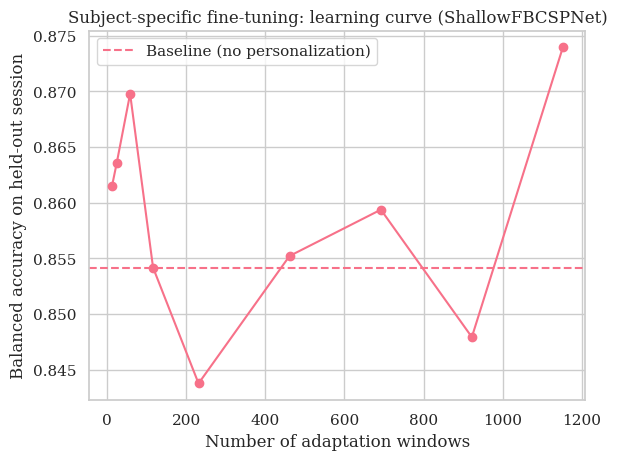

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_results_head_only["n_adapt"], df_results_head_only["bacc"], marker="o")
plt.axhline(baseline["bacc"], linestyle="--", label="Baseline (no personalization)")
plt.xlabel("Number of adaptation windows")
plt.ylabel("Balanced accuracy on held-out session")
plt.title("Subject-specific fine-tuning: learning curve (ShallowFBCSPNet)")
plt.legend()
plt.show()

## EEGNet

### HPO results

In [19]:
# EEGNet best params (from HPO)
lr = 0.00035245793071781275
MAX_EPOCHS = 80
batch_size = 32
weight_decay = 7.4259271410164125e-06
drop_prob = 0.5941040909682417
F1 = 32
D = 4
kernel_length = 64
depthwise_kernel_length = 8
patience = 8

In [20]:
import numpy as np
import torch

cuda = torch.cuda.is_available()
device = "cuda" if cuda else "cpu"
print("device:", device)


device: cuda


### Path to saved weights

In [21]:
import os

save_dir = "models_eegnet"
seed = 2025
#run_id = "hpo_v1"
run_id = "hpo_v15epochs"

path_eegnet = os.path.join(save_dir, f"eegnet_{run_id}_seed{seed}.pkl")
print("Loading weights from:", path_eegnet)
print("Exists:", os.path.exists(path_eegnet))


Loading weights from: models_eegnet/eegnet_hpo_v15epochs_seed2025.pkl
Exists: True


### Build EEGNet

In [22]:
import torch
import numpy as np
from collections import Counter

from braindecode.models import EEGNet
from braindecode import EEGClassifier

X0 = train_set[0][0]  # get first window data
if isinstance(X0, np.ndarray):
    X0 = torch.tensor(X0)

# Sometimes people end up with (1, n_chans, n_times) depending on transforms
if X0.ndim == 3 and X0.shape[0] == 1:
    X0 = X0.squeeze(0)

if X0.ndim != 2:
    raise RuntimeError(f"Expected 2D data (n_chans, n_times), got shape: {tuple(X0.shape)}")

n_chans = int(X0.shape[0])
n_times = int(X0.shape[1])

# infer label columns name from metadata
meta_train = train_set.get_metadata()
label_col = "target" if "target" in meta_train.columns else "label"
y_train = meta_train[label_col].to_numpy().astype(int)

classes = np.unique(y_train)
n_classes = int(classes.size)

print("Label column:", label_col)
print("Classes found:", classes, "n_classes:", n_classes)
print("EEGNet input dims:", "n_chans =", n_chans, "n_times =", n_times)
print("Train label counts:", Counter(y_train))


Label column: target
Classes found: [0 1] n_classes: 2
EEGNet input dims: n_chans = 8 n_times = 409
Train label counts: Counter({0: 12960, 1: 2592})


In [23]:
import torch
from braindecode import EEGClassifier
from braindecode.util import set_random_seeds
from braindecode.models import EEGNet

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.helper import predefined_split
from sklearn.metrics import balanced_accuracy_score, make_scorer

train_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=True,
    name="train_bacc",
    lower_is_better=False,
)

valid_bacc_cb = EpochScoring(
    scoring=make_scorer(balanced_accuracy_score),
    on_train=False,
    name="valid_bacc",
    lower_is_better=False,
)

def make_eegnet_clf(
    n_chans,
    n_times,
    n_classes,
    device,
    lr,
    max_epochs,
    batch_size,
    weight_decay,
    patience,
    drop_prob,
    F1,
    D,
    kernel_length,
    depthwise_kernel_length,
    valid_ds=None,
    monitor="valid_loss",
):
    model = EEGNet(
        n_chans=n_chans,
        n_outputs=n_classes,
        n_times=n_times,
        final_conv_length="auto",
        drop_prob=drop_prob,
        F1=F1,
        D=D,
        kernel_length=kernel_length,
        depthwise_kernel_length=depthwise_kernel_length,
    ).to(device)

    callbacks = [
        ("train_bacc", train_bacc_cb),
        ("valid_bacc", valid_bacc_cb),
    ]

    train_split = None
    if valid_ds is not None:
        train_split = predefined_split(valid_ds)
        callbacks.append(
            ("early_stopping", EarlyStopping(
                monitor=monitor,
                patience=patience,
                lower_is_better=True,
                threshold=1e-4,
                threshold_mode="rel",
                load_best=True,
            ))
        )

    clf = EEGClassifier(
        model,
        criterion=torch.nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        optimizer__lr=lr,
        optimizer__weight_decay=weight_decay,
        batch_size=batch_size,
        max_epochs=max_epochs,
        device=device,
        iterator_train__shuffle=True,
        iterator_train__drop_last=False,
        iterator_valid__drop_last=False,
        train_split=train_split,
        classes=list(range(n_classes)),
        callbacks=callbacks,
    )
    return clf


### Load general weights into classifier and evaluate baseline

In [24]:
set_random_seeds(seed=2026, cuda=cuda)

general_clf_eegnet = make_eegnet_clf(
    n_chans=n_chans,
    n_times=n_times,
    n_classes=n_classes,
    device=device,
    lr=lr,
    max_epochs=MAX_EPOCHS,
    batch_size=batch_size,
    weight_decay=weight_decay,
    patience=patience,
    drop_prob=drop_prob,
    F1=F1,
    D=D,
    kernel_length=kernel_length,
    depthwise_kernel_length=depthwise_kernel_length,
    valid_ds=None,
)

general_clf_eegnet.initialize()
general_clf_eegnet.load_params(f_params=path_eegnet)

baseline = eval_clf_on_dataset(general_clf_eegnet, subject_test_ds, y_subjtest)
print("Baseline (loaded general EEGNet):", baseline)

print("First parameter names (pick freeze regex from these):")
for name, _ in list(general_clf_eegnet.module_.named_parameters()):
    print(name)


Baseline (loaded general EEGNet): {'acc': 0.8819444444444444, 'bacc': 0.8541666666666667, 'auc': 0.9359375000000001, 'ap': 0.8096491550020138}
First parameter names (pick freeze regex from these):
conv_temporal.weight
bnorm_temporal.weight
bnorm_temporal.bias
conv_spatial.parametrizations.weight.original
bnorm_1.weight
bnorm_1.bias
conv_separable_depth.weight
conv_separable_point.weight
bnorm_2.weight
bnorm_2.bias
final_layer.conv_classifier.weight
final_layer.conv_classifier.bias


### Fine-tune with increasing fractions
- Unfroze last layer

In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset
from braindecode.util import set_random_seeds

fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

# Fine-tuning settings
ft_lr = lr * 0.1
ft_max_epochs = 5
rng_master = np.random.RandomState(2026)

adapt_pool_indices = np.arange(len(adapt_pool_ds))
results = []

# Head-only regex (confirmed from your printed param names)
HEAD_REGEX = r"^final_layer\.conv_classifier\."

for frac in fractions:
    rng = np.random.RandomState(rng_master.randint(0, 10**9))

    # Stratified sample from adaptation pool (indices relative to adapt_pool_ds)
    chosen_idx_rel = stratified_subsample_indices(
        all_indices=adapt_pool_indices,
        y=y_adapt,
        frac=frac,
        rng=rng
    )
    chosen_ds = Subset(adapt_pool_ds, chosen_idx_rel)
    ft_train_ds = chosen_ds

    # Avoid 0-batch edge case
    ft_batch_size = max(1, min(batch_size, len(ft_train_ds)))
    print(f"frac={frac} | n_adapt={len(ft_train_ds)} | ft_batch_size={ft_batch_size}")

    # Fresh clf + deterministic seeds
    set_random_seeds(seed=2026, cuda=cuda)

    ft_clf = make_eegnet_clf(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=ft_lr,
        max_epochs=ft_max_epochs,
        batch_size=ft_batch_size,
        weight_decay=weight_decay,
        patience=patience,  # not used if valid_ds=None
        drop_prob=drop_prob,
        F1=F1,
        D=D,
        kernel_length=kernel_length,
        depthwise_kernel_length=depthwise_kernel_length,
        valid_ds=None,      # no early stopping in fine-tuning
    )

    # Initialize, load general weights
    ft_clf.initialize()
    ft_clf.load_params(f_params=path_eegnet)

    # Freeze everything except classifier head
    trainable, frozen = freeze_all_but(
        ft_clf.module_,
        trainable_regexes=[HEAD_REGEX],
    )

    # Rebuild optimizer so it only includes trainable params
    ft_clf.initialize_optimizer()

    # Continue training from loaded weights
    ft_clf.set_params(warm_start=True)

    if frac == fractions[0]:
        print("Trainable layers (EEGNet head-only):")
        print_trainable(ft_clf.module_)
        print("HEAD_REGEX =", HEAD_REGEX)

    # Fine-tune on chosen adaptation data
    ft_clf.partial_fit(ft_train_ds, y=None)

    # Evaluate on held-out session test split
    metrics = eval_clf_on_dataset(ft_clf, subject_test_ds, y_subjtest)
    row = {"frac": frac, "n_adapt": int(len(chosen_ds)), **metrics}
    results.append(row)

    print(
        f"frac={frac:>4} | n_adapt={len(chosen_ds):>4} | "
        f"bacc={row['bacc']:.3f} | acc={row['acc']:.3f} | "
        f"auc={row['auc'] if not np.isnan(row['auc']) else 'nan'} | "
        f"ap={row['ap'] if not np.isnan(row['ap']) else 'nan'}"
    )

df_results_eegnet_head_only = pd.DataFrame(results)
df_results_eegnet_head_only


frac=0.01 | n_adapt=12 | ft_batch_size=12
Trainable layers (EEGNet head-only):
TRAIN final_layer.conv_classifier.weight (2, 128, 1, 12)
TRAIN final_layer.conv_classifier.bias (2,)
Trainable params: 3074 of 24130
HEAD_REGEX = ^final_layer\.conv_classifier\.


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.7500        0.1993  0.2416
      2        1.0000        0.0883  0.0060
      3        1.0000        0.0970  0.0065
      4        0.7500        0.1199  0.0066
      5        0.7500        0.1616  0.0066
frac=0.01 | n_adapt=  12 | bacc=0.853 | acc=0.880 | auc=0.9361762152777778 | ap=0.8109746517611385
frac=0.02 | n_adapt=24 | ft_batch_size=24


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.7250        0.2154  1.2902
      2        0.7500        0.2155  0.0067
      3        0.7250        0.1960  0.0070
      4        0.7500        0.1795  0.0069
      5        0.7500        0.1991  0.0070
frac=0.02 | n_adapt=  24 | bacc=0.853 | acc=0.880 | auc=0.9365885416666667 | ap=0.8114663503141561
frac=0.05 | n_adapt=58 | ft_batch_size=32
  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8292        0.1526  0.0778
      2        0.9000        0.1976  0.0126
      3        0.8792        0.1858  0.0118
      4        0.8396        0.1968  0.0119


      5        0.9000        0.1612  0.0097


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


frac=0.05 | n_adapt=  58 | bacc=0.852 | acc=0.878 | auc=0.9369140625 | ap=0.8123467308946088
frac=0.1 | n_adapt=116 | ft_batch_size=32


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.7490        0.3544  0.2136
      2        0.7896        0.2923  0.0255
      3        0.7594        0.3022  0.0243
      4        0.7292        0.2863  0.0248
      5        0.7844        0.3513  0.0255
frac= 0.1 | n_adapt= 116 | bacc=0.859 | acc=0.884 | auc=0.9375217013888888 | ap=0.8142280704442234
frac=0.2 | n_adapt=231 | ft_batch_size=32


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8510        0.1925  0.2670
      2        0.8764        0.2167  0.0500
      3        0.8740        0.1936  0.0496
      4        0.8407        0.1918  0.0506
      5        0.8714        0.2067  0.0500
frac= 0.2 | n_adapt= 231 | bacc=0.860 | acc=0.885 | auc=0.9388671875 | ap=0.8174985828209281
frac=0.4 | n_adapt=461 | ft_batch_size=32


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8207        0.2297  0.1939
      2        0.8376        0.2333  0.0676
      3        0.8558        0.2139  0.0714
      4        0.8545        0.2254  0.0934
      5        0.8506        0.2076  0.0947
frac= 0.4 | n_adapt= 461 | bacc=0.859 | acc=0.884 | auc=0.9413845486111112 | ap=0.8248406570864009
frac=0.6 | n_adapt=692 | ft_batch_size=32


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8257        0.2085  0.1389
      2        0.8257        0.2060  0.1384
      3        0.8490        0.2010  0.1381
      4        0.8421        0.2048  0.0941
      5        0.8413        0.2047  0.1216
frac= 0.6 | n_adapt= 692 | bacc=0.864 | acc=0.884 | auc=0.9439019097222222 | ap=0.8314404611348727
frac=0.8 | n_adapt=922 | ft_batch_size=32


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8214        0.2192  0.1823
      2        0.8363        0.2022  0.1815
      3        0.8538        0.2015  0.1821
      4        0.8460        0.1987  0.1818
      5        0.8532        0.1822  0.1819
frac= 0.8 | n_adapt= 922 | bacc=0.863 | acc=0.882 | auc=0.9446397569444444 | ap=0.8345197235840274
frac=1.0 | n_adapt=1152 | ft_batch_size=32


/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss     dur
-------  ------------  ------------  ------
      1        0.8266        0.2112  0.2073
      2        0.8453        0.2029  0.2245
      3        0.8505        0.2148  0.1839
      4        0.8349        0.2014  0.2165
      5        0.8354        0.1980  0.2207
frac= 1.0 | n_adapt=1152 | bacc=0.864 | acc=0.884 | auc=0.9468967013888889 | ap=0.8428183694046032


,frac,n_adapt,acc,bacc,auc,ap
0,0.01,12,0.880208,0.853125,0.936176,0.810975
1,0.02,24,0.880208,0.853125,0.936589,0.811466
2,0.05,58,0.878472,0.852083,0.936914,0.812347
3,0.10,116,0.883681,0.859375,0.937522,0.814228
4,0.20,231,0.885417,0.860417,0.938867,0.817499
5,0.40,461,0.883681,0.859375,0.941385,0.824841
6,0.60,692,0.883681,0.863542,0.943902,0.831440
7,0.80,922,0.881944,0.862500,0.944640,0.834520
8,1.00,1152,0.883681,0.863542,0.946897,0.842818


### Fine-tune (session 1,2,3)

In [53]:
# head only (current baseline)
UNFREEZE_REGEXES_EEGNET = [
    r"^final_layer\.conv_classifier\.bias$",
    r"^final_layer\.conv_classifier\.weight$",
    r"^bnorm_2\.weight$",
    r"^bnorm_2\.bias$",
    r"^conv_separable_depth\.weight$",
    r"^conv_separable_point\.weight$",
    r"^bnorm_1\.weight$",
    r"^bnorm_1\.bias$",
    r"^conv_spatial\.parametrizations\.weight\.original$",
    r"^conv_temporal\.weight$",
    r"^bnorm_temporal\.weight$",
    r"^bnorm_temporal\.bias$",

]

# r"^conv_temporal\.weight$",
# r"^bnorm_temporal\.weight$",
# r"^bnorm_temporal\.bias$",
# r"^conv_spatial\.parametrizations\.weight\.original$",
# r"^bnorm_1\.weight$",
# r"^bnorm_1\.bias$",
# r"^conv_separable_depth\.weight$",
# r"^conv_separable_point\.weight$",
# r"^bnorm_2\.weight$",
# r"^bnorm_2\.bias$",
# r"^final_layer\.conv_classifier\.weight$",
# r"^final_layer\.conv_classifier\.bias$",


In [ ]:
import numpy as np
import pandas as pd
from torch.utils.data import Subset
from braindecode.util import set_random_seeds

fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

# Fine-tuning settings
ft_lr = lr * 0.1
ft_max_epochs = 80
patience_ft = 10
rng_master = np.random.RandomState(2026)

adapt_pool_indices = np.arange(len(adapt_pool_ds))
results = []

# Fixed validation set: session 2
ft_valid_ds = valid_ds
if len(ft_valid_ds) == 0:
    ft_valid_ds = None  # safety fallback

for frac in fractions:
    rng = np.random.RandomState(rng_master.randint(0, 10**9))

    # Stratified sample from adaptation pool (indices relative to adapt_pool_ds)
    chosen_idx_rel = stratified_subsample_indices(
        all_indices=adapt_pool_indices,
        y=y_adapt,
        frac=frac,
        rng=rng
    )
    chosen_ds = Subset(adapt_pool_ds, chosen_idx_rel)
    ft_train_ds = chosen_ds

    # Avoid 0-batch edge case
    ft_batch_size = max(1, min(batch_size, len(ft_train_ds)))
    print(
        f"frac={frac} | n_adapt={len(ft_train_ds)} | valid={0 if ft_valid_ds is None else len(ft_valid_ds)} | "
        f"ft_batch_size={ft_batch_size}"
    )

    # Fresh clf + deterministic seeds
    set_random_seeds(seed=2026, cuda=cuda)

    ft_clf = make_eegnet_clf(
        n_chans=n_chans,
        n_times=n_times,
        n_classes=n_classes,
        device=device,
        lr=ft_lr,
        max_epochs=ft_max_epochs,
        batch_size=ft_batch_size,
        weight_decay=weight_decay,
        patience=patience,     # should be used now if your make_eegnet_clf wires EarlyStopping
        drop_prob=drop_prob,
        F1=F1,
        D=D,
        kernel_length=kernel_length,
        depthwise_kernel_length=depthwise_kernel_length,
        valid_ds=ft_valid_ds,  # <-- use fixed session-2 validation
        # monitor="valid_loss", # <-- add this ONLY if your make_eegnet_clf accepts it
    )

    # Initialize, load general weights
    ft_clf.initialize()
    ft_clf.load_params(f_params=path_eegnet)

    # Freeze everything except classifier head
    trainable, frozen = freeze_all_but(
        ft_clf.module_,
        trainable_regexes=UNFREEZE_REGEXES_EEGNET,
    )

    # Rebuild optimizer so it only includes trainable params
    ft_clf.initialize_optimizer()

    # Continue training from loaded weights
    ft_clf.set_params(warm_start=True)

    if frac == fractions[0]:
        print("Trainable layers (EEGNet head-only):")
        print_trainable(ft_clf.module_)
        print("HEAD_REGEX =", UNFREEZE_REGEXES_EEGNET)

    # Fine-tune on chosen adaptation data; validation is used internally (predefined_split)
    ft_clf.partial_fit(ft_train_ds, y=None)

    # Evaluate on held-out session test split (session 3)
    metrics = eval_clf_on_dataset(ft_clf, subject_test_ds, y_subjtest)
    row = {"frac": frac, "n_adapt": int(len(chosen_ds)), **metrics}
    results.append(row)

    print(
        f"frac={frac:>4} | n_adapt={len(chosen_ds):>4} | "
        f"bacc={row['bacc']:.3f} | acc={row['acc']:.3f} | "
        f"auc={row['auc'] if not np.isnan(row['auc']) else 'nan'} | "
        f"ap={row['ap'] if not np.isnan(row['ap']) else 'nan'}"
    )

df_results_eegnet = pd.DataFrame(results)
df_results_eegnet


frac=0.01 | n_adapt=6 | valid=576 | ft_batch_size=6
Trainable layers (EEGNet head-only):
TRAIN conv_temporal.weight (32, 1, 1, 64)
TRAIN bnorm_temporal.weight (32,)
TRAIN bnorm_temporal.bias (32,)
TRAIN conv_spatial.parametrizations.weight.original (128, 1, 8, 1)
TRAIN bnorm_1.weight (128,)
TRAIN bnorm_1.bias (128,)
TRAIN conv_separable_depth.weight (128, 1, 1, 8)
TRAIN conv_separable_point.weight (128, 128, 1, 1)
TRAIN bnorm_2.weight (128,)
TRAIN bnorm_2.bias (128,)
TRAIN final_layer.conv_classifier.weight (2, 128, 1, 12)
TRAIN final_layer.conv_classifier.bias (2,)
Trainable params: 24130 of 24130
HEAD_REGEX = ['^final_layer\\.conv_classifier\\.bias$', '^final_layer\\.conv_classifier\\.weight$', '^bnorm_2\\.weight$', '^bnorm_2\\.bias$', '^conv_separable_depth\\.weight$', '^conv_separable_point\\.weight$', '^bnorm_1\\.weight$', '^bnorm_1\\.bias$', '^conv_spatial\\.parametrizations\\.weight\\.original$', '^conv_temporal\\.weight$', '^bnorm_temporal\\.weight$', '^bnorm_temporal\\.bias$']

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.5000        0.1966       0.9097        0.8792        0.2300  0.4944
      2        0.5000        0.2155       0.9080        0.8823        0.2288  0.6493
      3        0.5000        0.2419       0.9132        0.8938        0.2282  0.2702
      4        0.5000        0.4334       0.9184        0.8969        0.2282  0.4801
      5        0.5000        0.1641       0.9132        0.8896        0.2288  0.3448
      6        1.0000        0.0681       0.9149        0.8948        0.2299  0.3366
      7        1.0000        0.0676       0.9184        0.9052        0.2313  0.4985
      8        1.0000        0.1082       0.9132        0.9021        0.2329  0.4325
      9        1.0000        0.0661       0.9132        0.9021        0.2349  0.4634
     10        1.0000        0.0249       0.9149        0.9073   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        1.0000        0.0535       0.9115        0.8677        0.2318  0.3129
      2        1.0000        0.1074       0.9080        0.8615        0.2302  0.1088
      3        1.0000        0.0392       0.9080        0.8615        0.2286  0.2501
      4        1.0000        0.0563       0.9080        0.8615        0.2274  0.1339
      5        1.0000        0.0679       0.9080        0.8615        0.2271  0.2538
      6        1.0000        0.0264       0.9132        0.8646        0.2269  0.2641
      7        1.0000        0.0477       0.9132        0.8562        0.2261  0.2649
      8        1.0000        0.0266       0.9097        0.8542        0.2257  0.1418
      9        1.0000        0.0335       0.9080        0.8531        0.2255  0.2479
     10        1.0000        0.0505       0.9080        0.8531   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8792        0.1755       0.9149        0.8823        0.2275  0.1141
      2        0.8792        0.1613       0.9167        0.8875        0.2231  0.1264
      3        0.9000        0.1353       0.9149        0.8865        0.2197  0.1322
      4        0.8792        0.0915       0.9201        0.8979        0.2171  0.1329
      5        0.8792        0.1008       0.9236        0.9042        0.2149  0.1324
      6        0.9000        0.0670       0.9253        0.9135        0.2132  0.1327
      7        0.9792        0.0655       0.9271        0.9146        0.2119  0.0768
      8        0.9792        0.0789       0.9288        0.9156        0.2105  0.1221
      9        0.9792        0.0585       0.9253        0.9135        0.2090  0.1288
     10        1.0000        0.0564       0.9219        0.9115   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8396        0.1928       0.9149        0.8823        0.2276  0.2217
      2        0.7896        0.1936       0.9149        0.8823        0.2240  0.1201
      3        0.8500        0.1776       0.9167        0.8917        0.2216  0.1182
      4        0.8396        0.1623       0.9184        0.9010        0.2203  0.1166
      5        0.8396        0.1669       0.9219        0.9073        0.2196  0.1164
      6        0.8896        0.1304       0.9236        0.9125        0.2192  0.1206
      7        0.8396        0.1293       0.9219        0.9115        0.2195  0.1186
      8        0.8896        0.1554       0.9236        0.9167        0.2205  0.1063
      9        1.0000        0.0807       0.9236        0.9167        0.2219  0.0751
     10        0.8500        0.1054       0.9219        0.9156   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.7937        0.2497       0.9236        0.8875        0.2241  1.2805
      2        0.8042        0.2420       0.9219        0.8865        0.2174  0.0932
      3        0.8240        0.2146       0.9253        0.8927        0.2120  0.1117
      4        0.8490        0.1894       0.9288        0.9073        0.2074  0.1116
      5        0.8490        0.1953       0.9358        0.9156        0.2037  0.1104
      6        0.8594        0.1627       0.9375        0.9167        0.2007  0.1136
      7        0.8792        0.1744       0.9392        0.9219        0.1984  0.1183
      8        0.8542        0.1515       0.9427        0.9281        0.1967  0.1137
      9        0.8740        0.1462       0.9427        0.9281        0.1953  0.0970
     10        0.9146        0.1204       0.9410        0.9271   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8458        0.1976       0.9253        0.8802        0.2181  0.4262
      2        0.8405        0.2076       0.9306        0.8917        0.2060  0.1288
      3        0.8612        0.1853       0.9410        0.9062        0.1963  0.1612
      4        0.8586        0.1887       0.9427        0.9156        0.1888  0.1674
      5        0.8716        0.1540       0.9444        0.9208        0.1830  0.1657
      6        0.8742        0.1424       0.9479        0.9229        0.1789  0.1688
      7        0.8818        0.1258       0.9479        0.9229        0.1761  0.1694
      8        0.8844        0.1310       0.9479        0.9271        0.1743  0.1690
      9        0.8998        0.1257       0.9427        0.9156        0.1729  0.1172
     10        0.8920        0.1255       0.9444        0.9208   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8654        0.2139       0.9236        0.8875        0.2155  0.3133
      2        0.8533        0.1681       0.9323        0.9010        0.2018  0.2152
      3        0.8809        0.1573       0.9410        0.9187        0.1933  0.2148
      4        0.8723        0.1451       0.9497        0.9406        0.1874  0.2145
      5        0.9103        0.1332       0.9462        0.9385        0.1838  0.1412
      6        0.8879        0.1230       0.9410        0.9271        0.1814  0.1814
      7        0.8965        0.1101       0.9444        0.9333        0.1794  0.2066
      8        0.9241        0.1102       0.9462        0.9344        0.1775  0.2095
      9        0.9275        0.0983       0.9479        0.9354        0.1754  0.2074
     10        0.9396        0.1051       0.9531        0.9427   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8259        0.2031       0.9306        0.8917        0.2081  0.8453
      2        0.8857        0.1501       0.9392        0.9219        0.1923  0.1988
      3        0.8922        0.1464       0.9444        0.9292        0.1834  0.2147
      4        0.9104        0.1243       0.9479        0.9396        0.1772  0.2643
      5        0.9311        0.1082       0.9479        0.9354        0.1728  0.2569
      6        0.9130        0.1156       0.9479        0.9313        0.1692  0.2580
      7        0.9220        0.1133       0.9479        0.9313        0.1659  0.2582
      8        0.9441        0.0920       0.9497        0.9281        0.1611  0.2475
      9        0.9493        0.0921       0.9514        0.9292        0.1576  0.1763
     10        0.9324        0.0940       0.9531        0.9302   

/scratch/s4776178/projects/p300-personalisation-hyperscanning/.venv/lib/python3.11/site-packages/braindecode/util.py:52: UserWarning: torch.backends.cudnn.benchmark was set to True which may results in lack of reproducibility. In some cases to ensure reproducibility you may need to set torch.backends.cudnn.benchmark to False.
  warn(


  epoch    train_bacc    train_loss    valid_acc    valid_bacc    valid_loss     dur
-------  ------------  ------------  -----------  ------------  ------------  ------
      1        0.8615        0.1910       0.9358        0.9073        0.2029  0.4128
      2        0.8865        0.1513       0.9444        0.9208        0.1847  0.3055
      3        0.8823        0.1372       0.9479        0.9271        0.1748  0.3093
      4        0.9240        0.1132       0.9514        0.9333        0.1691  0.2331
      5        0.9177        0.1099       0.9479        0.9271        0.1655  0.2657
      6        0.9115        0.1119       0.9462        0.9260        0.1632  0.2944
      7        0.9198        0.1013       0.9497        0.9323        0.1618  0.3150
      8        0.9406        0.0876       0.9549        0.9354        0.1583  0.2346
      9        0.9365        0.0908       0.9566        0.9365        0.1551  0.2778
     10        0.9396        0.0863       0.9601        0.9427   

,frac,n_adapt,acc,bacc,auc,ap
0,0.01,6,0.883681,0.855208,0.943859,0.832389
1,0.02,12,0.880208,0.832292,0.934440,0.801533
2,0.05,29,0.899306,0.877083,0.960221,0.880713
3,0.10,58,0.880208,0.861458,0.950564,0.856881
4,0.20,116,0.913194,0.881250,0.958051,0.868588
5,0.40,231,0.937500,0.920833,0.969727,0.918044
6,0.60,346,0.930556,0.916667,0.975977,0.926263
7,0.80,461,0.940972,0.922917,0.972852,0.924336
8,1.00,576,0.947917,0.931250,0.977279,0.935928


### Plot personalisation learning curve

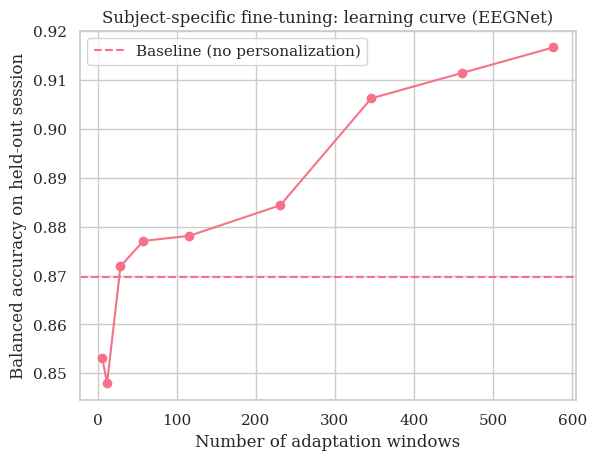

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df_results_eegnet["n_adapt"], df_results_eegnet["bacc"], marker="o")
plt.axhline(baseline["bacc"], linestyle="--", label="Baseline (no personalization)")
plt.xlabel("Number of adaptation windows")
plt.ylabel("Balanced accuracy on held-out session")
plt.title("Subject-specific fine-tuning: learning curve (EEGNet)")
plt.legend()
plt.show()


# Fine-tune LOSO loop

## Helpers

### Imports

In [ ]:
import numpy as np
import re
from torch.utils.data import Subset
from sklearn.metrics import (
    balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score
)

### Stratified subsampling

In [ ]:
def stratified_subsample_indices(all_indices, y, frac, rng):
    if not (0 < frac <= 1.0):
        raise ValueError("frac must be in (0, 1].")
    chosen = []
    for cls in np.unique(y):
        cls_mask = (y == cls)
        cls_idx = all_indices[cls_mask]
        n_take = max(1, int(np.ceil(frac * len(cls_idx))))
        take = rng.choice(cls_idx, size=min(n_take, len(cls_idx)), replace=False)
        chosen.append(take)
    chosen = np.concatenate(chosen)
    rng.shuffle(chosen)
    return chosen

### Metrics

In [ ]:
def eval_clf_on_dataset(clf, ds, y_true):
    proba = clf.predict_proba(ds)
    y_pred = np.argmax(proba, axis=1)

    out = {
        "acc": float(accuracy_score(y_true, y_pred)),
        "bacc": float(balanced_accuracy_score(y_true, y_pred)),
    }

    if len(np.unique(y_true)) == 2:
        out["auc"] = float(roc_auc_score(y_true, proba[:, 1]))
        out["ap"]  = float(average_precision_score(y_true, proba[:, 1]))
    else:
        out["auc"] = np.nan
        out["ap"]  = np.nan
    return out

### Freezing layers

In [ ]:
def freeze_all(module):
    for _, p in module.named_parameters():
        p.requires_grad = False

def unfreeze_matching(module, regex_list):
    patterns = [re.compile(rgx) for rgx in regex_list]
    trainable = []
    for name, p in module.named_parameters():
        if any(rgx.search(name) for rgx in patterns):
            p.requires_grad = True
            trainable.append(name)
    return trainable

def freeze_all_but(module, trainable_regexes):
    freeze_all(module)
    trainable = unfreeze_matching(module, trainable_regexes)
    frozen = [n for n, p in module.named_parameters() if not p.requires_grad]
    return trainable, frozen

def print_trainable(module):
    n_train = 0
    n_total = 0
    for name, p in module.named_parameters():
        n_total += p.numel()
        if p.requires_grad:
            n_train += p.numel()
            print("TRAIN", name, tuple(p.shape))
    print("Trainable params:", n_train, "of", n_total)

## Subject/session split

In [ ]:
def make_subject_session_splits(windows_dataset, subject_id):
    meta = windows_dataset.get_metadata().reset_index(drop=True)

    subj_mask = meta["subject"].astype(int) == int(subject_id)
    meta_subj = meta.loc[subj_mask].reset_index(drop=False)  # keep original indices in column "index"

    sessions_sorted = sorted(meta_subj["session"].unique().tolist())
    if len(sessions_sorted) != 3:
        raise ValueError(f"Subject {subject_id} has sessions={sessions_sorted}, expected exactly 3.")

    adapt_sess, valid_sess, test_sess = sessions_sorted[0], sessions_sorted[1], sessions_sorted[2]

    idx_adapt = meta_subj.loc[meta_subj["session"] == adapt_sess, "index"].to_numpy()
    idx_valid = meta_subj.loc[meta_subj["session"] == valid_sess, "index"].to_numpy()
    idx_test  = meta_subj.loc[meta_subj["session"] == test_sess,  "index"].to_numpy()

    adapt_ds = Subset(windows_dataset, idx_adapt)
    valid_ds = Subset(windows_dataset, idx_valid)
    test_ds  = Subset(windows_dataset, idx_test)

    y_adapt = meta.loc[idx_adapt, "target"].to_numpy().astype(int)
    y_valid = meta.loc[idx_valid, "target"].to_numpy().astype(int)
    y_test  = meta.loc[idx_test,  "target"].to_numpy().astype(int)

    info = {
        "subject": int(subject_id),
        "sessions_sorted": sessions_sorted,
        "adapt_session": adapt_sess,
        "valid_session": valid_sess,
        "test_session": test_sess,
        "n_adapt_pool": int(len(adapt_ds)),
        "n_valid": int(len(valid_ds)),
        "n_test": int(len(test_ds)),
        "adapt_label_counts": {int(k): int(v) for k, v in zip(*np.unique(y_adapt, return_counts=True))},
        "valid_label_counts": {int(k): int(v) for k, v in zip(*np.unique(y_valid, return_counts=True))},
        "test_label_counts":  {int(k): int(v) for k, v in zip(*np.unique(y_test,  return_counts=True))},
    }
    return adapt_ds, valid_ds, test_ds, y_adapt, y_valid, y_test, info


## ShallowFBCSPNet

### Unfreezing configuration

In [ ]:
UNFREEZE_CONFIGS = {
    "head_only": [
        r"^final_layer\.conv_classifier\.",
    ],
    "head_plus_bnorm": [
        r"^final_layer\.conv_classifier\.",
        r"^bnorm\.",
    ],
    "head_plus_early": [
        r"^final_layer\.conv_classifier\.",
        r"^bnorm\.",
        r"^conv_time_spat\.",
    ],
    
    # "all": [r".*"],
}


### LOSO personalisaiton

In [ ]:
import pandas as pd
import numpy as np

def run_loso_personalization(
    windows_dataset,
    subjects,
    fractions,
    unfreeze_configs,
    make_shallow_clf,
    path_shallow,
    seed=2026,
    device="cpu",
    cuda=False,
    # base training hyperparams (your existing vars)
    lr=0.0027,
    max_epochs=80,
    batch_size=128,
    weight_decay=1e-4,
    patience=11,
    drop_prob=0.5,
    n_filters_time=40,
    filter_time_length=65,
    n_filters_spat=32,
    pool_time_length=25,
    pool_time_stride=12,
    # fine-tuning settings
    ft_lr_mult=0.01,
    ft_max_epochs=80,
    patience_ft=10,
    monitor="valid_loss",
):
    # infer shapes and classes once
    y_all = windows_dataset.y if hasattr(windows_dataset, "y") else np.array([windows_dataset[i][1] for i in range(len(windows_dataset))])
    classes = np.unique(y_all)
    n_classes = len(classes)

    x0 = windows_dataset[0][0]
    n_chans, n_times = x0.shape[0], x0.shape[1]

    rng_master = np.random.RandomState(seed)

    rows = []

    for subj in subjects:
        adapt_pool_ds, valid_ds, test_ds, y_adapt, y_valid, y_test, info = make_subject_session_splits(windows_dataset, subj)

        # baseline: general model (no personalization) on this subject test session
        general_clf = make_shallow_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            max_epochs=max_epochs,
            batch_size=batch_size,
            weight_decay=weight_decay,
            patience=patience,
            drop_prob=drop_prob,
            n_filters_time=n_filters_time,
            filter_time_length=filter_time_length,
            n_filters_spat=n_filters_spat,
            pool_time_length=pool_time_length,
            pool_time_stride=pool_time_stride,
            valid_ds=None,
        )
        general_clf.initialize()
        general_clf.load_params(f_params=path_shallow)

        baseline_metrics = eval_clf_on_dataset(general_clf, test_ds, y_test)

        # loop configs
        for cfg_name, regexes in unfreeze_configs.items():
            # precompute indices for stratified sampling inside adapt_pool_ds
            adapt_pool_indices = np.arange(len(adapt_pool_ds))

            for frac in fractions:
                # deterministic seed per (subj, cfg, frac)
                local_seed = rng_master.randint(0, 10**9) ^ (int(subj) * 10007) ^ (hash(cfg_name) & 0xFFFFFFFF) ^ int(frac * 1e6)
                rng = np.random.RandomState(local_seed)

                chosen_rel = stratified_subsample_indices(
                    all_indices=adapt_pool_indices,
                    y=y_adapt,
                    frac=frac,
                    rng=rng,
                )
                ft_train_ds = Subset(adapt_pool_ds, chosen_rel)

                ft_batch_size = max(1, min(batch_size, len(ft_train_ds)))

                ft_clf = make_shallow_clf(
                    n_chans=n_chans,
                    n_times=n_times,
                    n_classes=n_classes,
                    device=device,
                    lr=lr * ft_lr_mult,
                    max_epochs=ft_max_epochs,
                    batch_size=ft_batch_size,
                    weight_decay=weight_decay,
                    patience=patience_ft,
                    drop_prob=drop_prob,
                    n_filters_time=n_filters_time,
                    filter_time_length=filter_time_length,
                    n_filters_spat=n_filters_spat,
                    pool_time_length=pool_time_length,
                    pool_time_stride=pool_time_stride,
                    valid_ds=valid_ds,
                    monitor=monitor,
                )

                ft_clf.initialize()
                ft_clf.load_params(f_params=path_shallow)

                trainable, frozen = freeze_all_but(ft_clf.module_, trainable_regexes=regexes)
                ft_clf.initialize_optimizer()
                ft_clf.set_params(warm_start=True)

                ft_clf.partial_fit(ft_train_ds, y=None)

                metrics = eval_clf_on_dataset(ft_clf, test_ds, y_test)

                rows.append({
                    "subject": int(subj),
                    "cfg": cfg_name,
                    "frac": float(frac),
                    "n_adapt": int(len(ft_train_ds)),
                    "baseline_acc": baseline_metrics["acc"],
                    "baseline_bacc": baseline_metrics["bacc"],
                    "baseline_auc": baseline_metrics.get("auc", np.nan),
                    "baseline_ap": baseline_metrics.get("ap", np.nan),
                    "acc": metrics["acc"],
                    "bacc": metrics["bacc"],
                    "auc": metrics.get("auc", np.nan),
                    "ap": metrics.get("ap", np.nan),
                    "adapt_session": info["adapt_session"],
                    "valid_session": info["valid_session"],
                    "test_session": info["test_session"],
                    "n_adapt_pool": info["n_adapt_pool"],
                    "n_valid": info["n_valid"],
                    "n_test": info["n_test"],
                })

        print(
            f"done subject={subj} | sessions={info['sessions_sorted']} | "
            f"adapt/valid/test sizes={info['n_adapt_pool']}/{info['n_valid']}/{info['n_test']} | "
            f"baseline bacc={baseline_metrics['bacc']:.3f}"
        )

    df_all = pd.DataFrame(rows)

    # Summary 1: best per subject per cfg (by bacc)
    idx_best = df_all.groupby(["subject", "cfg"])["bacc"].idxmax()
    df_best = df_all.loc[idx_best].copy().sort_values(["cfg", "subject"])

    # Summary 2: averages across subjects per cfg (best per subject)
    df_avg_best = (
        df_best.groupby("cfg")[["baseline_bacc", "bacc", "baseline_acc", "acc", "baseline_auc", "auc", "baseline_ap", "ap"]]
        .mean()
        .reset_index()
        .rename(columns={
            "baseline_bacc": "mean_baseline_bacc",
            "bacc": "mean_best_bacc",
            "baseline_acc": "mean_baseline_acc",
            "acc": "mean_best_acc",
            "baseline_auc": "mean_baseline_auc",
            "auc": "mean_best_auc",
            "baseline_ap": "mean_baseline_ap",
            "ap": "mean_best_ap",
        })
    )

    return df_all, df_best, df_avg_best

### Run loop

In [ ]:
# subjects list from your windows dataset metadata
meta = windows_dataset.get_metadata()
subjects = sorted(meta["subject"].unique().astype(int).tolist())
print("subjects:", subjects)

fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

df_all, df_best, df_avg_best = run_loso_personalization(
    windows_dataset=windows_dataset,
    subjects=subjects,
    fractions=fractions,
    unfreeze_configs=UNFREEZE_CONFIGS,
    make_shallow_clf=make_shallow_clf,
    path_shallow=path_shallow,
    seed=2026,
    device=device,
    cuda=cuda,

    lr=lr,
    max_epochs=MAX_EPOCHS,
    batch_size=batch_size,
    weight_decay=weight_decay,
    patience=patience,
    drop_prob=drop_prob,
    n_filters_time=n_filters_time,
    filter_time_length=filter_time_length,
    n_filters_spat=n_filters_spat,
    pool_time_length=pool_time_length,
    pool_time_stride=pool_time_stride,

    ft_lr_mult=0.01,
    ft_max_epochs=80,
    patience_ft=10,
    monitor="valid_loss",
)

df_all.head(), df_best.head(), df_avg_best

### Table

In [ ]:
# Wide table of best bacc per subject, per unfreeze cfg
table_bacc = df_best.pivot(index="subject", columns="cfg", values="bacc")
table_base = df_best.drop_duplicates("subject").set_index("subject")["baseline_bacc"]

table = table_bacc.copy()
table.insert(0, "baseline_bacc", table_base)

# add an average row
avg_row = pd.DataFrame(table.mean(axis=0)).T
avg_row.index = ["MEAN"]
table_with_mean = pd.concat([table, avg_row], axis=0)

table_with_mean

### Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_subject_curve(df_all, subject, cfg):
    d = df_all[(df_all["subject"] == subject) & (df_all["cfg"] == cfg)].sort_values("n_adapt")
    if len(d) == 0:
        print("No rows for subject/cfg")
        return

    baseline_bacc = float(d["baseline_bacc"].iloc[0])

    plt.figure()
    plt.plot(d["n_adapt"], d["bacc"], marker="o")
    plt.axhline(baseline_bacc, linestyle="--", label="Baseline (general model)")
    plt.xlabel("Number of adaptation windows")
    plt.ylabel("Balanced accuracy on held-out session 3")
    plt.title(f"Subject {subject} | {cfg}")
    plt.legend()

# example
plot_subject_curve(df_all, subject=subjects[0], cfg="head_only")


## EEGNet


### Unfreezing configuration

In [ ]:
UNFREEZE_CONFIGS_EEGNET = {
    # Only classifier head
    "head_only": [
        r"^final_layer\.conv_classifier\.weight$",
        r"^final_layer\.conv_classifier\.bias$",
    ],

    # Head + last block (typical quick personalization)
    "head_plus_sep": [
        r"^final_layer\.conv_classifier\.(weight|bias)$",
        r"^conv_separable_depth\.weight$",
        r"^conv_separable_point\.weight$",
        r"^bnorm_2\.(weight|bias)$",
    ],

    # Head + sep + spatial conv
    "head_plus_sep_plus_spatial": [
        r"^final_layer\.conv_classifier\.(weight|bias)$",
        r"^conv_separable_depth\.weight$",
        r"^conv_separable_point\.weight$",
        r"^bnorm_2\.(weight|bias)$",
        r"^conv_spatial\.",            
        r"^bnorm_1\.(weight|bias)$",
    ],

    # Everything (upper bound)
    "all": [
        r".*",
    ],
}


### LOSO personalisation

In [ ]:
import pandas as pd
import numpy as np
from braindecode.util import set_random_seeds
from torch.utils.data import Subset

def run_loso_personalization_eegnet(
    windows_dataset,
    subjects,
    fractions,
    unfreeze_configs,
    make_eegnet_clf,
    path_eegnet,
    seed=2026,
    device="cpu",
    cuda=False,

    # general model training params (from your HPO)
    lr=3.5245793071781275e-4,
    max_epochs=80,
    batch_size=32,
    weight_decay=7.4259271410164125e-06,
    patience=8,
    drop_prob=0.5941040909682417,
    F1=32,
    D=4,
    kernel_length=64,
    depthwise_kernel_length=8,

    # fine-tuning params
    ft_lr_mult=0.1,
    ft_max_epochs=80,
    patience_ft=10,
    monitor="valid_loss",
):
    # infer input dims + classes once (from the windows_dataset)
    X0 = windows_dataset[0][0]
    if isinstance(X0, np.ndarray):
        n_chans, n_times = X0.shape[-2], X0.shape[-1]
    else:
        n_chans, n_times = int(X0.shape[-2]), int(X0.shape[-1])

    y_all = windows_dataset.y if hasattr(windows_dataset, "y") else np.array([windows_dataset[i][1] for i in range(len(windows_dataset))])
    classes = np.unique(y_all)
    n_classes = int(classes.size)

    rng_master = np.random.RandomState(seed)
    rows = []

    for subj in subjects:
        adapt_pool_ds, valid_ds, test_ds, y_adapt, y_valid, y_test, info = make_subject_session_splits(windows_dataset, subj)

        # Baseline general EEGNet on session-3 test
        set_random_seeds(seed=seed, cuda=cuda)
        general_clf = make_eegnet_clf(
            n_chans=n_chans,
            n_times=n_times,
            n_classes=n_classes,
            device=device,
            lr=lr,
            max_epochs=max_epochs,
            batch_size=batch_size,
            weight_decay=weight_decay,
            patience=patience,
            drop_prob=drop_prob,
            F1=F1,
            D=D,
            kernel_length=kernel_length,
            depthwise_kernel_length=depthwise_kernel_length,
            valid_ds=None,
            monitor=monitor,
        )
        general_clf.initialize()
        general_clf.load_params(f_params=path_eegnet)

        baseline_metrics = eval_clf_on_dataset(general_clf, test_ds, y_test)

        # personalization runs
        adapt_pool_indices = np.arange(len(adapt_pool_ds))

        for cfg_name, regexes in unfreeze_configs.items():
            for frac in fractions:
                # stable deterministic seed per (subj, cfg, frac) WITHOUT python hash randomness
                cfg_id = list(unfreeze_configs.keys()).index(cfg_name)
                local_seed = (seed * 1000003) ^ (int(subj) * 10007) ^ (cfg_id * 30011) ^ int(frac * 1e6)
                rng = np.random.RandomState(local_seed)

                chosen_rel = stratified_subsample_indices(
                    all_indices=adapt_pool_indices,
                    y=y_adapt,
                    frac=frac,
                    rng=rng,
                )
                ft_train_ds = Subset(adapt_pool_ds, chosen_rel)

                ft_valid_ds = valid_ds if len(valid_ds) > 0 else None
                ft_batch_size = max(1, min(batch_size, len(ft_train_ds)))

                set_random_seeds(seed=seed, cuda=cuda)
                ft_clf = make_eegnet_clf(
                    n_chans=n_chans,
                    n_times=n_times,
                    n_classes=n_classes,
                    device=device,
                    lr=lr * ft_lr_mult,
                    max_epochs=ft_max_epochs,
                    batch_size=ft_batch_size,
                    weight_decay=weight_decay,
                    patience=patience_ft,         # use patience_ft during fine-tuning
                    drop_prob=drop_prob,
                    F1=F1,
                    D=D,
                    kernel_length=kernel_length,
                    depthwise_kernel_length=depthwise_kernel_length,
                    valid_ds=ft_valid_ds,
                    monitor=monitor,
                )

                ft_clf.initialize()
                ft_clf.load_params(f_params=path_eegnet)

                trainable, frozen = freeze_all_but(ft_clf.module_, trainable_regexes=regexes)
                ft_clf.initialize_optimizer()
                ft_clf.set_params(warm_start=True)

                # debug once per subject/cfg
                # if frac == fractions[0] and cfg_name == list(unfreeze_configs.keys())[0]:
                #     print("Trainable for first run:")
                #     print_trainable(ft_clf.module_)

                ft_clf.partial_fit(ft_train_ds, y=None)

                metrics = eval_clf_on_dataset(ft_clf, test_ds, y_test)

                rows.append({
                    "subject": int(subj),
                    "cfg": cfg_name,
                    "frac": float(frac),
                    "n_adapt": int(len(ft_train_ds)),

                    "baseline_acc": baseline_metrics["acc"],
                    "baseline_bacc": baseline_metrics["bacc"],
                    "baseline_auc": baseline_metrics.get("auc", np.nan),
                    "baseline_ap": baseline_metrics.get("ap", np.nan),

                    "acc": metrics["acc"],
                    "bacc": metrics["bacc"],
                    "auc": metrics.get("auc", np.nan),
                    "ap": metrics.get("ap", np.nan),

                    "adapt_session": info["adapt_session"],
                    "valid_session": info["valid_session"],
                    "test_session": info["test_session"],
                    "n_adapt_pool": info["n_adapt_pool"],
                    "n_valid": info["n_valid"],
                    "n_test": info["n_test"],
                })

        print(
            f"done subject={subj} | sessions={info['sessions_sorted']} | "
            f"adapt/valid/test sizes={info['n_adapt_pool']}/{info['n_valid']}/{info['n_test']} | "
            f"baseline bacc={baseline_metrics['bacc']:.3f}"
        )

    df_all = pd.DataFrame(rows)

    idx_best = df_all.groupby(["subject", "cfg"])["bacc"].idxmax()
    df_best = df_all.loc[idx_best].copy().sort_values(["cfg", "subject"])

    df_avg_best = (
        df_best.groupby("cfg")[["baseline_bacc", "bacc", "baseline_acc", "acc", "baseline_auc", "auc", "baseline_ap", "ap"]]
        .mean()
        .reset_index()
        .rename(columns={
            "baseline_bacc": "mean_baseline_bacc",
            "bacc": "mean_best_bacc",
            "baseline_acc": "mean_baseline_acc",
            "acc": "mean_best_acc",
            "baseline_auc": "mean_baseline_auc",
            "auc": "mean_best_auc",
            "baseline_ap": "mean_baseline_ap",
            "ap": "mean_best_ap",
        })
    )

    return df_all, df_best, df_avg_best


### Run loop

In [ ]:
meta = windows_dataset.get_metadata()
subjects = sorted(meta["subject"].unique().astype(int).tolist())

fractions = [0.01, 0.02, 0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]

df_all_eegnet, df_best_eegnet, df_avg_best_eegnet = run_loso_personalization_eegnet(
    windows_dataset=windows_dataset,
    subjects=subjects,
    fractions=fractions,
    unfreeze_configs=UNFREEZE_CONFIGS_EEGNET,
    make_eegnet_clf=make_eegnet_clf,
    path_eegnet=path_eegnet,
    seed=2026,
    device=device,
    cuda=cuda,

    lr=lr,
    max_epochs=MAX_EPOCHS,
    batch_size=batch_size,
    weight_decay=weight_decay,
    patience=patience,
    drop_prob=drop_prob,
    F1=F1,
    D=D,
    kernel_length=kernel_length,
    depthwise_kernel_length=depthwise_kernel_length,

    ft_lr_mult=0.1,
    ft_max_epochs=80,
    patience_ft=10,
    monitor="valid_loss",
)

df_avg_best_eegnet


### Table

In [ ]:
table_bacc = df_best_eegnet.pivot(index="subject", columns="cfg", values="bacc")
table_base = df_best_eegnet.drop_duplicates("subject").set_index("subject")["baseline_bacc"]

table = table_bacc.copy()
table.insert(0, "baseline_bacc", table_base)

table.loc["MEAN"] = table.mean(axis=0)
table


### Plot

In [ ]:
import matplotlib.pyplot as plt

def plot_subject_curve(df_all, subject, cfg):
    d = df_all[(df_all["subject"] == subject) & (df_all["cfg"] == cfg)].sort_values("n_adapt")
    baseline_bacc = float(d["baseline_bacc"].iloc[0])

    plt.figure()
    plt.plot(d["n_adapt"], d["bacc"], marker="o")
    plt.axhline(baseline_bacc, linestyle="--", label="Baseline (general EEGNet)")
    plt.xlabel("Number of adaptation windows")
    plt.ylabel("Balanced accuracy on session 3")
    plt.title(f"EEGNet personalization | subject={subject} | cfg={cfg}")
    plt.legend()
    plt.show()

plot_subject_curve(df_all_eegnet, subject=subjects[0], cfg="head_only")
